<a href="https://colab.research.google.com/github/quanndm/kltn/blob/dev/notebooks/main_cot.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Init - import library - download data

In [1]:
!rm -rf kltn
!rm -rf sample_data
!git clone -b dev https://github.com/quanndm/kltn.git

Cloning into 'kltn'...
remote: Enumerating objects: 664, done.
remote: Counting objects: 100% (221/221), done.
remote: Compressing objects: 100% (154/154), done.
remote: Total 664 (delta 140), reused 137 (delta 67), pack-reused 443 (from 1)
Receiving objects: 100% (664/664), 3.66 MiB | 7.30 MiB/s, done.
Resolving deltas: 100% (421/421), done.


In [2]:
from kltn.init.install_dependencies import install_packages, load_config
install_packages("./kltn")
config = load_config("./kltn/parameters.yaml")


In [3]:
import torch
import matplotlib.pyplot as plt
import numpy as np
from google.colab import drive

from kltn import *
from kltn.datasets.get_datasets import get_datasets_lits
from kltn.utils.logger import init_logger
from kltn.utils.train_val_epochs import trainer, val_epoch
from kltn.utils.metrics import DiceLossWSigmoid, DiceLossWSoftmax, DiceMetric
from kltn.models.model_factory import ModelFactory
from kltn.utils.visualize_results import visualize_results

In [4]:
drive.flush_and_unmount()
drive.mount("/content/drive")

Mounted at /content/drive


In [5]:
LOGGER = init_logger(config["log_path"])
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [6]:
from kltn.datasets.prepare_data import prepare_dataset_LiTS
prepare_dataset_LiTS(dir_name=config["source_folder_lits"])

0.00% complete (down: 0.0 kB/s up: 0.0 kB/s peers: 1) downloading LITS17 (https://academictorrents.com/announce.php)[127.0.0.1:6881] v1 skipping tracker announce (unreachable) "" (1)
LITS17 (https://ipv6.academictorrents.com/announce.php)[127.0.0.1:6881] v1 skipping tracker announce (unreachable) "" (1)
LITS17 (https://academictorrents.com/announce.php)[172.28.0.12:6881] v1 unspecified system error "" (1)
LITS17 (https://ipv6.academictorrents.com/announce.php)[172.28.0.12:6881] v1 unspecified system error "" (1)
LITS17 (udp://tracker.opentrackr.org:1337/announce)[127.0.0.1:6881] v1 skipping tracker announce (unreachable) "" (1)
1.61% complete (down: 22368.5 kB/s up: 642.4 kB/s peers: 8) downloading LITS17 (https://academictorrents.com/announce.php)[127.0.0.1:6881] v1 skipping tracker announce (unreachable) "" (2)
LITS17 (https://ipv6.academictorrents.com/announce.php)[127.0.0.1:6881] v1 skipping tracker announce (unreachable) "" (2)
LITS17 (https://academictorrents.com/announce.php)[17

## Load data

In [6]:
full_train_dataset, val_dataset = get_datasets_lits(source_folder=config["source_folder_lits"], seed=123, fold_number=2)
print(len(full_train_dataset), len(val_dataset))

105 26


In [7]:
train_loader = torch.utils.data.DataLoader(full_train_dataset, batch_size=1, shuffle=True,
                                           num_workers=1, pin_memory=True, drop_last=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=1, shuffle=False,
                                         pin_memory=True, num_workers=1)

print("Train dataset number of batch:", len(train_loader))
print("Val dataset number of batch:", len(val_loader))

Train dataset number of batch: 105
Val dataset number of batch: 26


In [8]:
for batch in train_loader:
    # Assuming your input data is a 5D tensor (batch_size, channels, deep, height, width)
    data_shape = batch['image'].shape
    label_shape = batch['label'].shape
    print("Data shape in the first batch:", data_shape)
    print("Label shape in the first batch:", label_shape)
    break  # Print only the first batch

Data shape in the first batch: torch.Size([1, 1, 128, 128, 128])
Label shape in the first batch: torch.Size([1, 1, 128, 128, 128])


## Visual data

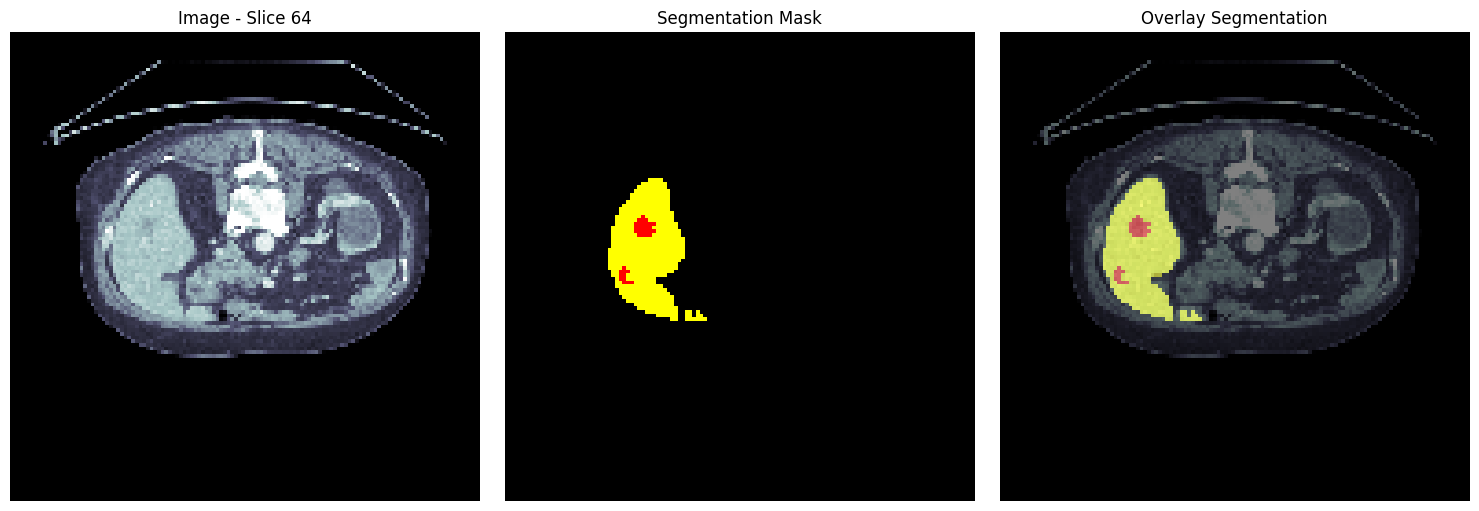

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.colors as mcolors

# Define colormap for segmentation classes
cmap = mcolors.ListedColormap(["black", "yellow", "red", "green", "blue", "purple"])
bounds = [0, 1, 2, 3, 4, 5]
norm = mcolors.BoundaryNorm(bounds, cmap.N)

for batch in train_loader:
    image_sample = batch['image']  # Shape: [1, 1, 128, 128, 128]
    label_sample = batch['label']  # Shape: [1, 1, 128, 128, 128]

    slice_idx = image_sample.shape[2] // 2

    img_slice = image_sample[0, 0, slice_idx, :, :].numpy()
    label_slice = label_sample[0, 0, slice_idx, :, :].numpy()

    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    axes[0].imshow(img_slice, cmap=plt.cm.bone)
    axes[0].set_title(f"Image - Slice {slice_idx}")
    axes[0].axis("off")


    axes[1].imshow(label_slice, cmap=cmap, norm=norm)
    axes[1].set_title("Segmentation Mask")
    axes[1].axis("off")


    axes[2].imshow(img_slice, cmap=plt.cm.bone)
    axes[2].imshow(label_slice, cmap=cmap, norm=norm, alpha=0.5)
    axes[2].set_title("Overlay Segmentation")
    axes[2].axis("off")

    plt.tight_layout()
    plt.show()
    break

## Model

In [9]:
model = ModelFactory.get_model("unet3d_cot",in_channels=1, n_classes=3, n_channels=16).to(device)
print('Number of network parameters:', sum(param.numel() for param in model.parameters()))

Number of network parameters: 1704867


## Training

In [10]:
criterion = DiceLossWSoftmax().to(device)

dice_acc = DiceMetric(include_background=False, reduction='mean_batch', get_not_nans=True)

optimizer = torch.optim.AdamW(model.parameters(), lr=float(config["learning_rate"]), weight_decay=float(config["weight_decay"]))
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=int(config["max_epochs"]), eta_min = float(config["eta_min"]))

In [11]:
LOGGER.info("[TRAINER] Start TRAIN process...")

(val_acc_max, best_epoch, dices_liver, dices_tumor, dices_avg, loss_epochs, trains_epoch, total_time
) = trainer(
    model = model,
    train_loader = train_loader,
    val_loader = val_loader,
    optimizer = optimizer,
    loss_func = criterion,
    acc_func = dice_acc,
    scheduler = scheduler,
    batch_size = config["batch_size"],
    max_epochs = config["max_epochs"],
    start_epoch = config["start_epoch"],
    val_every = config["val_every"],
    path_save_model = config["path_save_model_state"],
    logger = LOGGER,
    )

[TRAINER] Start TRAIN process...
INFO:kltn.utils.logger:[TRAINER] Start TRAIN process...

==============================Training epoch 1==============================
INFO:kltn.utils.logger:
==============================Training epoch 1==============================


Epoch 1/100 1/105 loss: 0.8905 time 15.38s
Epoch 1/100 2/105 loss: 0.8680 time 7.40s
Epoch 1/100 3/105 loss: 0.8379 time 4.27s
Epoch 1/100 4/105 loss: 0.8247 time 10.30s
Epoch 1/100 5/105 loss: 0.8170 time 7.05s
Epoch 1/100 6/105 loss: 0.8098 time 9.02s
Epoch 1/100 7/105 loss: 0.7980 time 1.26s
Epoch 1/100 8/105 loss: 0.7915 time 13.19s
Epoch 1/100 9/105 loss: 0.7850 time 6.43s
Epoch 1/100 10/105 loss: 0.7790 time 6.11s
Epoch 1/100 11/105 loss: 0.7741 time 2.29s
Epoch 1/100 12/105 loss: 0.7687 time 4.23s
Epoch 1/100 13/105 loss: 0.7654 time 15.75s
Epoch 1/100 14/105 loss: 0.7611 time 17.72s
Epoch 1/100 15/105 loss: 0.7567 time 2.25s
Epoch 1/100 16/105 loss: 0.7528 time 4.94s
Epoch 1/100 17/105 loss: 0.7489 time 8.36s
Epoch 1/100 18/105 loss: 0.7456 time 5.22s
Epoch 1/100 19/105 loss: 0.7420 time 3.00s
Epoch 1/100 20/105 loss: 0.7388 time 2.82s
Epoch 1/100 21/105 loss: 0.7358 time 1.76s
Epoch 1/100 22/105 loss: 0.7326 time 14.87s
Epoch 1/100 23/105 loss: 0.7297 time 17.04s
Epoch 1/100 2

Final training epochs: 1/100 ---[loss: 0.5826] ---[time 692.14s]
INFO:kltn.utils.logger:Final training epochs: 1/100 ---[loss: 0.5826] ---[time 692.14s]

********************Epoch 1 Validation********************
INFO:kltn.utils.logger:
********************Epoch 1 Validation********************


Epoch 1/100 105/105 loss: 0.5826 time 7.56s


Val 1/100 1/26, Dice_Liver: 0.530619, Dice_Tumor: 0.000000, Dice_Avg: 0.265310, time 12.71s
INFO:kltn.utils.logger:Val 1/100 1/26, Dice_Liver: 0.530619, Dice_Tumor: 0.000000, Dice_Avg: 0.265310, time 12.71s
Val 1/100 2/26, Dice_Liver: 0.662521, Dice_Tumor: 0.000000, Dice_Avg: 0.331261, time 0.49s
INFO:kltn.utils.logger:Val 1/100 2/26, Dice_Liver: 0.662521, Dice_Tumor: 0.000000, Dice_Avg: 0.331261, time 0.49s
Val 1/100 3/26, Dice_Liver: 0.667839, Dice_Tumor: 0.000000, Dice_Avg: 0.333920, time 5.31s
INFO:kltn.utils.logger:Val 1/100 3/26, Dice_Liver: 0.667839, Dice_Tumor: 0.000000, Dice_Avg: 0.333920, time 5.31s
Val 1/100 4/26, Dice_Liver: 0.572590, Dice_Tumor: 0.000000, Dice_Avg: 0.286295, time 12.82s
INFO:kltn.utils.logger:Val 1/100 4/26, Dice_Liver: 0.572590, Dice_Tumor: 0.000000, Dice_Avg: 0.286295, time 12.82s
Val 1/100 5/26, Dice_Liver: 0.585591, Dice_Tumor: 0.000000, Dice_Avg: 0.292795, time 1.87s
INFO:kltn.utils.logger:Val 1/100 5/26, Dice_Liver: 0.585591, Dice_Tumor: 0.000000, Di

New best (0.000000 --> 0.296660). At epoch 1


Epoch 1/100 ---[loss: 0.5826] ---[val_dice: 0.296660] ---[time 156.02s]
INFO:kltn.utils.logger:Epoch 1/100 ---[loss: 0.5826] ---[val_dice: 0.296660] ---[time 156.02s]

==============================Training epoch 2==============================
INFO:kltn.utils.logger:
==============================Training epoch 2==============================


Epoch 2/100 1/105 loss: 0.4808 time 4.94s
Epoch 2/100 2/105 loss: 0.4626 time 2.05s
Epoch 2/100 3/105 loss: 0.4521 time 1.86s
Epoch 2/100 4/105 loss: 0.4448 time 1.44s
Epoch 2/100 5/105 loss: 0.4460 time 12.71s
Epoch 2/100 6/105 loss: 0.4401 time 1.60s
Epoch 2/100 7/105 loss: 0.4376 time 13.73s
Epoch 2/100 8/105 loss: 0.4409 time 2.23s
Epoch 2/100 9/105 loss: 0.4389 time 1.67s
Epoch 2/100 10/105 loss: 0.4363 time 7.58s
Epoch 2/100 11/105 loss: 0.4365 time 9.13s
Epoch 2/100 12/105 loss: 0.4342 time 2.89s
Epoch 2/100 13/105 loss: 0.4331 time 8.13s
Epoch 2/100 14/105 loss: 0.4344 time 9.07s
Epoch 2/100 15/105 loss: 0.4344 time 13.22s
Epoch 2/100 16/105 loss: 0.4349 time 2.64s
Epoch 2/100 17/105 loss: 0.4331 time 8.64s
Epoch 2/100 18/105 loss: 0.4329 time 7.25s
Epoch 2/100 19/105 loss: 0.4324 time 10.84s
Epoch 2/100 20/105 loss: 0.4312 time 9.98s
Epoch 2/100 21/105 loss: 0.4297 time 4.62s
Epoch 2/100 22/105 loss: 0.4283 time 2.65s
Epoch 2/100 23/105 loss: 0.4269 time 4.32s
Epoch 2/100 24/1

Final training epochs: 2/100 ---[loss: 0.3853] ---[time 642.84s]
INFO:kltn.utils.logger:Final training epochs: 2/100 ---[loss: 0.3853] ---[time 642.84s]

********************Epoch 2 Validation********************
INFO:kltn.utils.logger:
********************Epoch 2 Validation********************


Epoch 2/100 105/105 loss: 0.3853 time 4.24s


Val 2/100 1/26, Dice_Liver: 0.720645, Dice_Tumor: 0.000000, Dice_Avg: 0.360323, time 10.99s
INFO:kltn.utils.logger:Val 2/100 1/26, Dice_Liver: 0.720645, Dice_Tumor: 0.000000, Dice_Avg: 0.360323, time 10.99s
Val 2/100 2/26, Dice_Liver: 0.793830, Dice_Tumor: 0.000000, Dice_Avg: 0.396915, time 1.39s
INFO:kltn.utils.logger:Val 2/100 2/26, Dice_Liver: 0.793830, Dice_Tumor: 0.000000, Dice_Avg: 0.396915, time 1.39s
Val 2/100 3/26, Dice_Liver: 0.784377, Dice_Tumor: 0.000000, Dice_Avg: 0.392189, time 5.14s
INFO:kltn.utils.logger:Val 2/100 3/26, Dice_Liver: 0.784377, Dice_Tumor: 0.000000, Dice_Avg: 0.392189, time 5.14s
Val 2/100 4/26, Dice_Liver: 0.748047, Dice_Tumor: 0.000000, Dice_Avg: 0.374023, time 12.15s
INFO:kltn.utils.logger:Val 2/100 4/26, Dice_Liver: 0.748047, Dice_Tumor: 0.000000, Dice_Avg: 0.374023, time 12.15s
Val 2/100 5/26, Dice_Liver: 0.775018, Dice_Tumor: 0.000000, Dice_Avg: 0.387509, time 1.77s
INFO:kltn.utils.logger:Val 2/100 5/26, Dice_Liver: 0.775018, Dice_Tumor: 0.000000, Di

New best (0.296660 --> 0.368529). At epoch 2
Epoch 3/100 1/105 loss: 0.3397 time 9.06s
Epoch 3/100 2/105 loss: 0.3630 time 11.23s
Epoch 3/100 3/105 loss: 0.3589 time 7.46s
Epoch 3/100 4/105 loss: 0.3527 time 5.25s
Epoch 3/100 5/105 loss: 0.3489 time 2.80s
Epoch 3/100 6/105 loss: 0.3446 time 5.84s
Epoch 3/100 7/105 loss: 0.3445 time 12.00s
Epoch 3/100 8/105 loss: 0.3456 time 11.49s
Epoch 3/100 9/105 loss: 0.3439 time 5.75s
Epoch 3/100 10/105 loss: 0.3417 time 6.66s
Epoch 3/100 11/105 loss: 0.3415 time 1.58s
Epoch 3/100 12/105 loss: 0.3419 time 4.88s
Epoch 3/100 13/105 loss: 0.3415 time 8.46s
Epoch 3/100 14/105 loss: 0.3426 time 9.06s
Epoch 3/100 15/105 loss: 0.3404 time 2.73s
Epoch 3/100 16/105 loss: 0.3393 time 2.83s
Epoch 3/100 17/105 loss: 0.3401 time 8.79s
Epoch 3/100 18/105 loss: 0.3389 time 1.43s
Epoch 3/100 19/105 loss: 0.3388 time 1.63s
Epoch 3/100 20/105 loss: 0.3377 time 10.22s
Epoch 3/100 21/105 loss: 0.3382 time 4.44s
Epoch 3/100 22/105 loss: 0.3378 time 11.28s
Epoch 3/100 2

Final training epochs: 3/100 ---[loss: 0.3287] ---[time 632.39s]
INFO:kltn.utils.logger:Final training epochs: 3/100 ---[loss: 0.3287] ---[time 632.39s]

********************Epoch 3 Validation********************
INFO:kltn.utils.logger:
********************Epoch 3 Validation********************


Epoch 3/100 105/105 loss: 0.3287 time 4.58s


Val 3/100 1/26, Dice_Liver: 0.812295, Dice_Tumor: 0.000000, Dice_Avg: 0.406148, time 12.16s
INFO:kltn.utils.logger:Val 3/100 1/26, Dice_Liver: 0.812295, Dice_Tumor: 0.000000, Dice_Avg: 0.406148, time 12.16s
Val 3/100 2/26, Dice_Liver: 0.835848, Dice_Tumor: 0.000000, Dice_Avg: 0.417924, time 1.33s
INFO:kltn.utils.logger:Val 3/100 2/26, Dice_Liver: 0.835848, Dice_Tumor: 0.000000, Dice_Avg: 0.417924, time 1.33s
Val 3/100 3/26, Dice_Liver: 0.832191, Dice_Tumor: 0.000000, Dice_Avg: 0.416096, time 5.97s
INFO:kltn.utils.logger:Val 3/100 3/26, Dice_Liver: 0.832191, Dice_Tumor: 0.000000, Dice_Avg: 0.416096, time 5.97s
Val 3/100 4/26, Dice_Liver: 0.825411, Dice_Tumor: 0.000000, Dice_Avg: 0.412706, time 12.73s
INFO:kltn.utils.logger:Val 3/100 4/26, Dice_Liver: 0.825411, Dice_Tumor: 0.000000, Dice_Avg: 0.412706, time 12.73s
Val 3/100 5/26, Dice_Liver: 0.833907, Dice_Tumor: 0.000000, Dice_Avg: 0.416953, time 1.96s
INFO:kltn.utils.logger:Val 3/100 5/26, Dice_Liver: 0.833907, Dice_Tumor: 0.000000, Di

New best (0.368529 --> 0.411888). At epoch 3
Epoch 4/100 1/105 loss: 0.3270 time 2.51s
Epoch 4/100 2/105 loss: 0.3132 time 13.08s
Epoch 4/100 3/105 loss: 0.3135 time 15.25s
Epoch 4/100 4/105 loss: 0.3160 time 9.73s
Epoch 4/100 5/105 loss: 0.3134 time 2.13s
Epoch 4/100 6/105 loss: 0.3106 time 1.04s
Epoch 4/100 7/105 loss: 0.3093 time 2.32s
Epoch 4/100 8/105 loss: 0.3094 time 8.85s
Epoch 4/100 9/105 loss: 0.3094 time 1.48s
Epoch 4/100 10/105 loss: 0.3094 time 9.65s
Epoch 4/100 11/105 loss: 0.3096 time 4.45s
Epoch 4/100 12/105 loss: 0.3126 time 4.74s
Epoch 4/100 13/105 loss: 0.3137 time 6.01s
Epoch 4/100 14/105 loss: 0.3149 time 13.03s
Epoch 4/100 15/105 loss: 0.3160 time 13.87s
Epoch 4/100 16/105 loss: 0.3148 time 10.32s
Epoch 4/100 17/105 loss: 0.3143 time 2.48s
Epoch 4/100 18/105 loss: 0.3150 time 4.29s
Epoch 4/100 19/105 loss: 0.3163 time 5.17s
Epoch 4/100 20/105 loss: 0.3164 time 1.54s
Epoch 4/100 21/105 loss: 0.3164 time 3.08s
Epoch 4/100 22/105 loss: 0.3161 time 9.07s
Epoch 4/100 2

Final training epochs: 4/100 ---[loss: 0.3120] ---[time 665.65s]
INFO:kltn.utils.logger:Final training epochs: 4/100 ---[loss: 0.3120] ---[time 665.65s]

********************Epoch 4 Validation********************
INFO:kltn.utils.logger:
********************Epoch 4 Validation********************


Epoch 4/100 105/105 loss: 0.3120 time 11.58s


Val 4/100 1/26, Dice_Liver: 0.824738, Dice_Tumor: 0.000000, Dice_Avg: 0.412369, time 11.73s
INFO:kltn.utils.logger:Val 4/100 1/26, Dice_Liver: 0.824738, Dice_Tumor: 0.000000, Dice_Avg: 0.412369, time 11.73s
Val 4/100 2/26, Dice_Liver: 0.839792, Dice_Tumor: 0.000000, Dice_Avg: 0.419896, time 1.36s
INFO:kltn.utils.logger:Val 4/100 2/26, Dice_Liver: 0.839792, Dice_Tumor: 0.000000, Dice_Avg: 0.419896, time 1.36s
Val 4/100 3/26, Dice_Liver: 0.832619, Dice_Tumor: 0.000000, Dice_Avg: 0.416309, time 5.45s
INFO:kltn.utils.logger:Val 4/100 3/26, Dice_Liver: 0.832619, Dice_Tumor: 0.000000, Dice_Avg: 0.416309, time 5.45s
Val 4/100 4/26, Dice_Liver: 0.845562, Dice_Tumor: 0.000000, Dice_Avg: 0.422781, time 12.84s
INFO:kltn.utils.logger:Val 4/100 4/26, Dice_Liver: 0.845562, Dice_Tumor: 0.000000, Dice_Avg: 0.422781, time 12.84s
Val 4/100 5/26, Dice_Liver: 0.854116, Dice_Tumor: 0.000000, Dice_Avg: 0.427058, time 2.01s
INFO:kltn.utils.logger:Val 4/100 5/26, Dice_Liver: 0.854116, Dice_Tumor: 0.000000, Di

New best (0.411888 --> 0.419057). At epoch 4
Epoch 5/100 1/105 loss: 0.2934 time 10.96s
Epoch 5/100 2/105 loss: 0.3016 time 4.50s
Epoch 5/100 3/105 loss: 0.2955 time 7.02s
Epoch 5/100 4/105 loss: 0.2988 time 2.85s
Epoch 5/100 5/105 loss: 0.2979 time 2.24s
Epoch 5/100 6/105 loss: 0.2993 time 9.75s
Epoch 5/100 7/105 loss: 0.2987 time 6.29s
Epoch 5/100 8/105 loss: 0.3015 time 4.74s
Epoch 5/100 9/105 loss: 0.3020 time 9.70s
Epoch 5/100 10/105 loss: 0.3012 time 10.56s
Epoch 5/100 11/105 loss: 0.3000 time 4.13s
Epoch 5/100 12/105 loss: 0.3006 time 10.80s
Epoch 5/100 13/105 loss: 0.2992 time 14.08s
Epoch 5/100 14/105 loss: 0.2995 time 1.81s
Epoch 5/100 15/105 loss: 0.2984 time 5.76s
Epoch 5/100 16/105 loss: 0.2989 time 4.43s
Epoch 5/100 17/105 loss: 0.2995 time 2.57s
Epoch 5/100 18/105 loss: 0.2994 time 1.96s
Epoch 5/100 19/105 loss: 0.3000 time 1.37s
Epoch 5/100 20/105 loss: 0.2998 time 4.78s
Epoch 5/100 21/105 loss: 0.2990 time 1.30s
Epoch 5/100 22/105 loss: 0.3002 time 1.80s
Epoch 5/100 23

Final training epochs: 5/100 ---[loss: 0.3043] ---[time 651.14s]
INFO:kltn.utils.logger:Final training epochs: 5/100 ---[loss: 0.3043] ---[time 651.14s]

********************Epoch 5 Validation********************
INFO:kltn.utils.logger:
********************Epoch 5 Validation********************


Epoch 5/100 105/105 loss: 0.3043 time 3.25s


Val 5/100 1/26, Dice_Liver: 0.767270, Dice_Tumor: 0.000000, Dice_Avg: 0.383635, time 11.34s
INFO:kltn.utils.logger:Val 5/100 1/26, Dice_Liver: 0.767270, Dice_Tumor: 0.000000, Dice_Avg: 0.383635, time 11.34s
Val 5/100 2/26, Dice_Liver: 0.782343, Dice_Tumor: 0.000000, Dice_Avg: 0.391171, time 1.39s
INFO:kltn.utils.logger:Val 5/100 2/26, Dice_Liver: 0.782343, Dice_Tumor: 0.000000, Dice_Avg: 0.391171, time 1.39s
Val 5/100 3/26, Dice_Liver: 0.715621, Dice_Tumor: 0.000000, Dice_Avg: 0.357811, time 5.58s
INFO:kltn.utils.logger:Val 5/100 3/26, Dice_Liver: 0.715621, Dice_Tumor: 0.000000, Dice_Avg: 0.357811, time 5.58s
Val 5/100 4/26, Dice_Liver: 0.739216, Dice_Tumor: 0.000000, Dice_Avg: 0.369608, time 13.15s
INFO:kltn.utils.logger:Val 5/100 4/26, Dice_Liver: 0.739216, Dice_Tumor: 0.000000, Dice_Avg: 0.369608, time 13.15s
Val 5/100 5/26, Dice_Liver: 0.758510, Dice_Tumor: 0.000000, Dice_Avg: 0.379255, time 1.87s
INFO:kltn.utils.logger:Val 5/100 5/26, Dice_Liver: 0.758510, Dice_Tumor: 0.000000, Di

Epoch 6/100 1/105 loss: 0.2915 time 12.90s
Epoch 6/100 2/105 loss: 0.2930 time 13.06s
Epoch 6/100 3/105 loss: 0.3004 time 2.83s
Epoch 6/100 4/105 loss: 0.2985 time 10.46s
Epoch 6/100 5/105 loss: 0.2977 time 10.29s
Epoch 6/100 6/105 loss: 0.2980 time 1.94s
Epoch 6/100 7/105 loss: 0.2964 time 5.76s
Epoch 6/100 8/105 loss: 0.2986 time 8.84s
Epoch 6/100 9/105 loss: 0.2988 time 8.88s
Epoch 6/100 10/105 loss: 0.3016 time 9.60s
Epoch 6/100 11/105 loss: 0.2997 time 2.22s
Epoch 6/100 12/105 loss: 0.3014 time 1.26s
Epoch 6/100 13/105 loss: 0.3034 time 1.60s
Epoch 6/100 14/105 loss: 0.3049 time 3.37s
Epoch 6/100 15/105 loss: 0.3057 time 1.22s
Epoch 6/100 16/105 loss: 0.3052 time 2.42s
Epoch 6/100 17/105 loss: 0.3044 time 12.87s
Epoch 6/100 18/105 loss: 0.3035 time 12.70s
Epoch 6/100 19/105 loss: 0.3054 time 4.77s
Epoch 6/100 20/105 loss: 0.3043 time 7.06s
Epoch 6/100 21/105 loss: 0.3050 time 14.21s
Epoch 6/100 22/105 loss: 0.3050 time 1.48s
Epoch 6/100 23/105 loss: 0.3042 time 2.54s
Epoch 6/100 2

Final training epochs: 6/100 ---[loss: 0.3009] ---[time 655.64s]
INFO:kltn.utils.logger:Final training epochs: 6/100 ---[loss: 0.3009] ---[time 655.64s]

********************Epoch 6 Validation********************
INFO:kltn.utils.logger:
********************Epoch 6 Validation********************


Epoch 6/100 105/105 loss: 0.3009 time 7.73s


Val 6/100 1/26, Dice_Liver: 0.798770, Dice_Tumor: 0.000000, Dice_Avg: 0.399385, time 11.88s
INFO:kltn.utils.logger:Val 6/100 1/26, Dice_Liver: 0.798770, Dice_Tumor: 0.000000, Dice_Avg: 0.399385, time 11.88s
Val 6/100 2/26, Dice_Liver: 0.843539, Dice_Tumor: 0.000000, Dice_Avg: 0.421770, time 1.46s
INFO:kltn.utils.logger:Val 6/100 2/26, Dice_Liver: 0.843539, Dice_Tumor: 0.000000, Dice_Avg: 0.421770, time 1.46s
Val 6/100 3/26, Dice_Liver: 0.841201, Dice_Tumor: 0.000000, Dice_Avg: 0.420601, time 5.35s
INFO:kltn.utils.logger:Val 6/100 3/26, Dice_Liver: 0.841201, Dice_Tumor: 0.000000, Dice_Avg: 0.420601, time 5.35s
Val 6/100 4/26, Dice_Liver: 0.764107, Dice_Tumor: 0.000000, Dice_Avg: 0.382053, time 12.09s
INFO:kltn.utils.logger:Val 6/100 4/26, Dice_Liver: 0.764107, Dice_Tumor: 0.000000, Dice_Avg: 0.382053, time 12.09s
Val 6/100 5/26, Dice_Liver: 0.792586, Dice_Tumor: 0.000000, Dice_Avg: 0.396293, time 2.04s
INFO:kltn.utils.logger:Val 6/100 5/26, Dice_Liver: 0.792586, Dice_Tumor: 0.000000, Di

Epoch 7/100 1/105 loss: 0.2953 time 6.26s
Epoch 7/100 2/105 loss: 0.2881 time 6.39s
Epoch 7/100 3/105 loss: 0.2861 time 7.88s
Epoch 7/100 4/105 loss: 0.2867 time 13.74s
Epoch 7/100 5/105 loss: 0.2934 time 10.01s
Epoch 7/100 6/105 loss: 0.2918 time 9.63s
Epoch 7/100 7/105 loss: 0.2908 time 11.86s
Epoch 7/100 8/105 loss: 0.2941 time 4.76s
Epoch 7/100 9/105 loss: 0.2956 time 5.20s
Epoch 7/100 10/105 loss: 0.2944 time 6.96s
Epoch 7/100 11/105 loss: 0.2946 time 6.67s
Epoch 7/100 12/105 loss: 0.2945 time 8.52s
Epoch 7/100 13/105 loss: 0.2942 time 5.45s
Epoch 7/100 14/105 loss: 0.2934 time 5.77s
Epoch 7/100 15/105 loss: 0.2922 time 5.12s
Epoch 7/100 16/105 loss: 0.2953 time 3.29s
Epoch 7/100 17/105 loss: 0.2960 time 12.48s
Epoch 7/100 18/105 loss: 0.2949 time 15.64s
Epoch 7/100 19/105 loss: 0.2945 time 2.23s
Epoch 7/100 20/105 loss: 0.2952 time 2.30s
Epoch 7/100 21/105 loss: 0.2941 time 9.84s
Epoch 7/100 22/105 loss: 0.2939 time 8.19s
Epoch 7/100 23/105 loss: 0.2937 time 7.54s
Epoch 7/100 24/

Final training epochs: 7/100 ---[loss: 0.2949] ---[time 644.31s]
INFO:kltn.utils.logger:Final training epochs: 7/100 ---[loss: 0.2949] ---[time 644.31s]

********************Epoch 7 Validation********************
INFO:kltn.utils.logger:
********************Epoch 7 Validation********************


Epoch 7/100 105/105 loss: 0.2949 time 1.21s


Val 7/100 1/26, Dice_Liver: 0.847607, Dice_Tumor: 0.000000, Dice_Avg: 0.423804, time 11.38s
INFO:kltn.utils.logger:Val 7/100 1/26, Dice_Liver: 0.847607, Dice_Tumor: 0.000000, Dice_Avg: 0.423804, time 11.38s
Val 7/100 2/26, Dice_Liver: 0.870611, Dice_Tumor: 0.000000, Dice_Avg: 0.435305, time 1.44s
INFO:kltn.utils.logger:Val 7/100 2/26, Dice_Liver: 0.870611, Dice_Tumor: 0.000000, Dice_Avg: 0.435305, time 1.44s
Val 7/100 3/26, Dice_Liver: 0.851689, Dice_Tumor: 0.000000, Dice_Avg: 0.425845, time 5.47s
INFO:kltn.utils.logger:Val 7/100 3/26, Dice_Liver: 0.851689, Dice_Tumor: 0.000000, Dice_Avg: 0.425845, time 5.47s
Val 7/100 4/26, Dice_Liver: 0.868935, Dice_Tumor: 0.000000, Dice_Avg: 0.434468, time 12.73s
INFO:kltn.utils.logger:Val 7/100 4/26, Dice_Liver: 0.868935, Dice_Tumor: 0.000000, Dice_Avg: 0.434468, time 12.73s
Val 7/100 5/26, Dice_Liver: 0.883650, Dice_Tumor: 0.000000, Dice_Avg: 0.441825, time 2.04s
INFO:kltn.utils.logger:Val 7/100 5/26, Dice_Liver: 0.883650, Dice_Tumor: 0.000000, Di

New best (0.419057 --> 0.435168). At epoch 7
Epoch 8/100 1/105 loss: 0.2736 time 9.53s
Epoch 8/100 2/105 loss: 0.2772 time 9.87s
Epoch 8/100 3/105 loss: 0.2783 time 1.46s
Epoch 8/100 4/105 loss: 0.2791 time 9.43s
Epoch 8/100 5/105 loss: 0.2797 time 1.85s
Epoch 8/100 6/105 loss: 0.2799 time 2.34s
Epoch 8/100 7/105 loss: 0.2827 time 2.01s
Epoch 8/100 8/105 loss: 0.2842 time 6.59s
Epoch 8/100 9/105 loss: 0.2831 time 15.36s
Epoch 8/100 10/105 loss: 0.2833 time 13.17s
Epoch 8/100 11/105 loss: 0.2864 time 0.87s
Epoch 8/100 12/105 loss: 0.2862 time 13.03s
Epoch 8/100 13/105 loss: 0.2873 time 2.02s
Epoch 8/100 14/105 loss: 0.2876 time 2.94s
Epoch 8/100 15/105 loss: 0.2872 time 5.69s
Epoch 8/100 16/105 loss: 0.2866 time 2.43s
Epoch 8/100 17/105 loss: 0.2859 time 5.82s
Epoch 8/100 18/105 loss: 0.2888 time 1.52s
Epoch 8/100 19/105 loss: 0.2882 time 10.88s
Epoch 8/100 20/105 loss: 0.2882 time 10.48s
Epoch 8/100 21/105 loss: 0.2875 time 9.30s
Epoch 8/100 22/105 loss: 0.2858 time 2.30s
Epoch 8/100 2

Final training epochs: 8/100 ---[loss: 0.2922] ---[time 662.26s]
INFO:kltn.utils.logger:Final training epochs: 8/100 ---[loss: 0.2922] ---[time 662.26s]

********************Epoch 8 Validation********************
INFO:kltn.utils.logger:
********************Epoch 8 Validation********************


Epoch 8/100 105/105 loss: 0.2922 time 1.96s


Val 8/100 1/26, Dice_Liver: 0.834712, Dice_Tumor: 0.000000, Dice_Avg: 0.417356, time 12.40s
INFO:kltn.utils.logger:Val 8/100 1/26, Dice_Liver: 0.834712, Dice_Tumor: 0.000000, Dice_Avg: 0.417356, time 12.40s
Val 8/100 2/26, Dice_Liver: 0.870875, Dice_Tumor: 0.000000, Dice_Avg: 0.435438, time 1.52s
INFO:kltn.utils.logger:Val 8/100 2/26, Dice_Liver: 0.870875, Dice_Tumor: 0.000000, Dice_Avg: 0.435438, time 1.52s
Val 8/100 3/26, Dice_Liver: 0.876334, Dice_Tumor: 0.000000, Dice_Avg: 0.438167, time 5.74s
INFO:kltn.utils.logger:Val 8/100 3/26, Dice_Liver: 0.876334, Dice_Tumor: 0.000000, Dice_Avg: 0.438167, time 5.74s
Val 8/100 4/26, Dice_Liver: 0.872743, Dice_Tumor: 0.000000, Dice_Avg: 0.436372, time 13.14s
INFO:kltn.utils.logger:Val 8/100 4/26, Dice_Liver: 0.872743, Dice_Tumor: 0.000000, Dice_Avg: 0.436372, time 13.14s
Val 8/100 5/26, Dice_Liver: 0.884060, Dice_Tumor: 0.000000, Dice_Avg: 0.442030, time 1.71s
INFO:kltn.utils.logger:Val 8/100 5/26, Dice_Liver: 0.884060, Dice_Tumor: 0.000000, Di

Epoch 9/100 1/105 loss: 0.2741 time 10.17s
Epoch 9/100 2/105 loss: 0.2656 time 2.97s
Epoch 9/100 3/105 loss: 0.2714 time 8.66s
Epoch 9/100 4/105 loss: 0.2767 time 3.51s
Epoch 9/100 5/105 loss: 0.2806 time 2.50s
Epoch 9/100 6/105 loss: 0.2881 time 1.54s
Epoch 9/100 7/105 loss: 0.2872 time 4.16s
Epoch 9/100 8/105 loss: 0.2884 time 6.49s
Epoch 9/100 9/105 loss: 0.2865 time 6.77s
Epoch 9/100 10/105 loss: 0.2863 time 1.51s
Epoch 9/100 11/105 loss: 0.2859 time 2.07s
Epoch 9/100 12/105 loss: 0.2850 time 15.46s
Epoch 9/100 13/105 loss: 0.2834 time 7.64s
Epoch 9/100 14/105 loss: 0.2847 time 0.99s
Epoch 9/100 15/105 loss: 0.2843 time 13.63s
Epoch 9/100 16/105 loss: 0.2835 time 3.03s
Epoch 9/100 17/105 loss: 0.2831 time 2.35s
Epoch 9/100 18/105 loss: 0.2835 time 1.00s
Epoch 9/100 19/105 loss: 0.2842 time 9.37s
Epoch 9/100 20/105 loss: 0.2857 time 2.45s
Epoch 9/100 21/105 loss: 0.2849 time 6.02s
Epoch 9/100 22/105 loss: 0.2849 time 3.16s
Epoch 9/100 23/105 loss: 0.2850 time 5.60s
Epoch 9/100 24/10

Final training epochs: 9/100 ---[loss: 0.2888] ---[time 652.39s]
INFO:kltn.utils.logger:Final training epochs: 9/100 ---[loss: 0.2888] ---[time 652.39s]

********************Epoch 9 Validation********************
INFO:kltn.utils.logger:
********************Epoch 9 Validation********************


Epoch 9/100 105/105 loss: 0.2888 time 2.14s


Val 9/100 1/26, Dice_Liver: 0.824649, Dice_Tumor: 0.000000, Dice_Avg: 0.412325, time 9.74s
INFO:kltn.utils.logger:Val 9/100 1/26, Dice_Liver: 0.824649, Dice_Tumor: 0.000000, Dice_Avg: 0.412325, time 9.74s
Val 9/100 2/26, Dice_Liver: 0.873987, Dice_Tumor: 0.000000, Dice_Avg: 0.436993, time 1.57s
INFO:kltn.utils.logger:Val 9/100 2/26, Dice_Liver: 0.873987, Dice_Tumor: 0.000000, Dice_Avg: 0.436993, time 1.57s
Val 9/100 3/26, Dice_Liver: 0.881164, Dice_Tumor: 0.000000, Dice_Avg: 0.440582, time 5.30s
INFO:kltn.utils.logger:Val 9/100 3/26, Dice_Liver: 0.881164, Dice_Tumor: 0.000000, Dice_Avg: 0.440582, time 5.30s
Val 9/100 4/26, Dice_Liver: 0.858127, Dice_Tumor: 0.000000, Dice_Avg: 0.429063, time 13.58s
INFO:kltn.utils.logger:Val 9/100 4/26, Dice_Liver: 0.858127, Dice_Tumor: 0.000000, Dice_Avg: 0.429063, time 13.58s
Val 9/100 5/26, Dice_Liver: 0.869861, Dice_Tumor: 0.000000, Dice_Avg: 0.434930, time 1.76s
INFO:kltn.utils.logger:Val 9/100 5/26, Dice_Liver: 0.869861, Dice_Tumor: 0.000000, Dice

Epoch 10/100 1/105 loss: 0.2406 time 3.27s
Epoch 10/100 2/105 loss: 0.2612 time 9.93s
Epoch 10/100 3/105 loss: 0.2671 time 1.99s
Epoch 10/100 4/105 loss: 0.2800 time 3.34s
Epoch 10/100 5/105 loss: 0.2818 time 5.85s
Epoch 10/100 6/105 loss: 0.2855 time 2.15s
Epoch 10/100 7/105 loss: 0.2847 time 1.05s
Epoch 10/100 8/105 loss: 0.2811 time 2.74s
Epoch 10/100 9/105 loss: 0.2819 time 13.21s
Epoch 10/100 10/105 loss: 0.2825 time 8.80s
Epoch 10/100 11/105 loss: 0.2827 time 3.88s
Epoch 10/100 12/105 loss: 0.2832 time 1.71s
Epoch 10/100 13/105 loss: 0.2839 time 10.27s
Epoch 10/100 14/105 loss: 0.2833 time 14.33s
Epoch 10/100 15/105 loss: 0.2824 time 6.31s
Epoch 10/100 16/105 loss: 0.2812 time 5.83s
Epoch 10/100 17/105 loss: 0.2811 time 14.98s
Epoch 10/100 18/105 loss: 0.2815 time 5.46s
Epoch 10/100 19/105 loss: 0.2812 time 9.62s
Epoch 10/100 20/105 loss: 0.2820 time 1.92s
Epoch 10/100 21/105 loss: 0.2815 time 13.30s
Epoch 10/100 22/105 loss: 0.2814 time 13.82s
Epoch 10/100 23/105 loss: 0.2826 ti

Final training epochs: 10/100 ---[loss: 0.2853] ---[time 647.85s]
INFO:kltn.utils.logger:Final training epochs: 10/100 ---[loss: 0.2853] ---[time 647.85s]

********************Epoch 10 Validation********************
INFO:kltn.utils.logger:
********************Epoch 10 Validation********************


Epoch 10/100 105/105 loss: 0.2853 time 2.63s


Val 10/100 1/26, Dice_Liver: 0.839584, Dice_Tumor: 0.000000, Dice_Avg: 0.419792, time 10.89s
INFO:kltn.utils.logger:Val 10/100 1/26, Dice_Liver: 0.839584, Dice_Tumor: 0.000000, Dice_Avg: 0.419792, time 10.89s
Val 10/100 2/26, Dice_Liver: 0.878710, Dice_Tumor: 0.000000, Dice_Avg: 0.439355, time 1.35s
INFO:kltn.utils.logger:Val 10/100 2/26, Dice_Liver: 0.878710, Dice_Tumor: 0.000000, Dice_Avg: 0.439355, time 1.35s
Val 10/100 3/26, Dice_Liver: 0.876831, Dice_Tumor: 0.000000, Dice_Avg: 0.438416, time 5.23s
INFO:kltn.utils.logger:Val 10/100 3/26, Dice_Liver: 0.876831, Dice_Tumor: 0.000000, Dice_Avg: 0.438416, time 5.23s
Val 10/100 4/26, Dice_Liver: 0.878384, Dice_Tumor: 0.000000, Dice_Avg: 0.439192, time 12.78s
INFO:kltn.utils.logger:Val 10/100 4/26, Dice_Liver: 0.878384, Dice_Tumor: 0.000000, Dice_Avg: 0.439192, time 12.78s
Val 10/100 5/26, Dice_Liver: 0.890046, Dice_Tumor: 0.000000, Dice_Avg: 0.445023, time 2.21s
INFO:kltn.utils.logger:Val 10/100 5/26, Dice_Liver: 0.890046, Dice_Tumor: 0.

New best (0.435168 --> 0.444989). At epoch 10
Epoch 11/100 1/105 loss: 0.2873 time 8.63s
Epoch 11/100 2/105 loss: 0.2857 time 1.95s
Epoch 11/100 3/105 loss: 0.2927 time 2.54s
Epoch 11/100 4/105 loss: 0.2873 time 1.66s
Epoch 11/100 5/105 loss: 0.2859 time 2.50s
Epoch 11/100 6/105 loss: 0.2834 time 12.47s
Epoch 11/100 7/105 loss: 0.2837 time 16.64s
Epoch 11/100 8/105 loss: 0.2840 time 5.22s
Epoch 11/100 9/105 loss: 0.2830 time 13.47s
Epoch 11/100 10/105 loss: 0.2844 time 2.71s
Epoch 11/100 11/105 loss: 0.2850 time 1.39s
Epoch 11/100 12/105 loss: 0.2836 time 7.80s
Epoch 11/100 13/105 loss: 0.2837 time 11.58s
Epoch 11/100 14/105 loss: 0.2820 time 2.78s
Epoch 11/100 15/105 loss: 0.2835 time 1.76s
Epoch 11/100 16/105 loss: 0.2837 time 6.77s
Epoch 11/100 17/105 loss: 0.2848 time 0.99s
Epoch 11/100 18/105 loss: 0.2853 time 4.48s
Epoch 11/100 19/105 loss: 0.2843 time 1.72s
Epoch 11/100 20/105 loss: 0.2825 time 10.19s
Epoch 11/100 21/105 loss: 0.2838 time 3.04s
Epoch 11/100 22/105 loss: 0.2830 t

Final training epochs: 11/100 ---[loss: 0.2853] ---[time 645.75s]
INFO:kltn.utils.logger:Final training epochs: 11/100 ---[loss: 0.2853] ---[time 645.75s]

********************Epoch 11 Validation********************
INFO:kltn.utils.logger:
********************Epoch 11 Validation********************


Epoch 11/100 105/105 loss: 0.2853 time 1.27s


Val 11/100 1/26, Dice_Liver: 0.843461, Dice_Tumor: 0.000537, Dice_Avg: 0.421999, time 11.45s
INFO:kltn.utils.logger:Val 11/100 1/26, Dice_Liver: 0.843461, Dice_Tumor: 0.000537, Dice_Avg: 0.421999, time 11.45s
Val 11/100 2/26, Dice_Liver: 0.881455, Dice_Tumor: 0.149068, Dice_Avg: 0.515262, time 1.43s
INFO:kltn.utils.logger:Val 11/100 2/26, Dice_Liver: 0.881455, Dice_Tumor: 0.149068, Dice_Avg: 0.515262, time 1.43s
Val 11/100 3/26, Dice_Liver: 0.882524, Dice_Tumor: 0.163487, Dice_Avg: 0.523006, time 6.02s
INFO:kltn.utils.logger:Val 11/100 3/26, Dice_Liver: 0.882524, Dice_Tumor: 0.163487, Dice_Avg: 0.523006, time 6.02s
Val 11/100 4/26, Dice_Liver: 0.768293, Dice_Tumor: 0.122616, Dice_Avg: 0.445454, time 12.95s
INFO:kltn.utils.logger:Val 11/100 4/26, Dice_Liver: 0.768293, Dice_Tumor: 0.122616, Dice_Avg: 0.445454, time 12.95s
Val 11/100 5/26, Dice_Liver: 0.799883, Dice_Tumor: 0.099106, Dice_Avg: 0.449495, time 1.84s
INFO:kltn.utils.logger:Val 11/100 5/26, Dice_Liver: 0.799883, Dice_Tumor: 0.

New best (0.444989 --> 0.457655). At epoch 11
Epoch 12/100 1/105 loss: 0.3059 time 2.48s
Epoch 12/100 2/105 loss: 0.2888 time 2.52s
Epoch 12/100 3/105 loss: 0.2917 time 7.17s
Epoch 12/100 4/105 loss: 0.2891 time 8.11s
Epoch 12/100 5/105 loss: 0.2877 time 8.68s
Epoch 12/100 6/105 loss: 0.2912 time 3.41s
Epoch 12/100 7/105 loss: 0.2877 time 12.26s
Epoch 12/100 8/105 loss: 0.2892 time 3.04s
Epoch 12/100 9/105 loss: 0.2818 time 3.66s
Epoch 12/100 10/105 loss: 0.2826 time 10.80s
Epoch 12/100 11/105 loss: 0.2756 time 11.69s
Epoch 12/100 12/105 loss: 0.2770 time 6.59s
Epoch 12/100 13/105 loss: 0.2773 time 15.00s
Epoch 12/100 14/105 loss: 0.2781 time 1.19s
Epoch 12/100 15/105 loss: 0.2776 time 11.88s
Epoch 12/100 16/105 loss: 0.2748 time 1.46s
Epoch 12/100 17/105 loss: 0.2755 time 12.07s
Epoch 12/100 18/105 loss: 0.2771 time 6.75s
Epoch 12/100 19/105 loss: 0.2780 time 2.17s
Epoch 12/100 20/105 loss: 0.2768 time 6.07s
Epoch 12/100 21/105 loss: 0.2821 time 1.53s
Epoch 12/100 22/105 loss: 0.2820 

Final training epochs: 12/100 ---[loss: 0.2801] ---[time 656.70s]
INFO:kltn.utils.logger:Final training epochs: 12/100 ---[loss: 0.2801] ---[time 656.70s]

********************Epoch 12 Validation********************
INFO:kltn.utils.logger:
********************Epoch 12 Validation********************


Epoch 12/100 105/105 loss: 0.2801 time 9.14s


Val 12/100 1/26, Dice_Liver: 0.841951, Dice_Tumor: 0.000787, Dice_Avg: 0.421369, time 11.15s
INFO:kltn.utils.logger:Val 12/100 1/26, Dice_Liver: 0.841951, Dice_Tumor: 0.000787, Dice_Avg: 0.421369, time 11.15s
Val 12/100 2/26, Dice_Liver: 0.882596, Dice_Tumor: 0.089704, Dice_Avg: 0.486150, time 1.31s
INFO:kltn.utils.logger:Val 12/100 2/26, Dice_Liver: 0.882596, Dice_Tumor: 0.089704, Dice_Avg: 0.486150, time 1.31s
Val 12/100 3/26, Dice_Liver: 0.879669, Dice_Tumor: 0.120346, Dice_Avg: 0.500007, time 5.27s
INFO:kltn.utils.logger:Val 12/100 3/26, Dice_Liver: 0.879669, Dice_Tumor: 0.120346, Dice_Avg: 0.500007, time 5.27s
Val 12/100 4/26, Dice_Liver: 0.888098, Dice_Tumor: 0.090259, Dice_Avg: 0.489179, time 13.08s
INFO:kltn.utils.logger:Val 12/100 4/26, Dice_Liver: 0.888098, Dice_Tumor: 0.090259, Dice_Avg: 0.489179, time 13.08s
Val 12/100 5/26, Dice_Liver: 0.898288, Dice_Tumor: 0.072207, Dice_Avg: 0.485248, time 2.05s
INFO:kltn.utils.logger:Val 12/100 5/26, Dice_Liver: 0.898288, Dice_Tumor: 0.

New best (0.457655 --> 0.483454). At epoch 12
Epoch 13/100 1/105 loss: 0.2611 time 7.82s
Epoch 13/100 2/105 loss: 0.2609 time 6.57s
Epoch 13/100 3/105 loss: 0.2734 time 5.51s
Epoch 13/100 4/105 loss: 0.2762 time 8.96s
Epoch 13/100 5/105 loss: 0.2857 time 3.47s
Epoch 13/100 6/105 loss: 0.2778 time 2.28s
Epoch 13/100 7/105 loss: 0.2776 time 3.59s
Epoch 13/100 8/105 loss: 0.2736 time 12.21s
Epoch 13/100 9/105 loss: 0.2756 time 2.05s
Epoch 13/100 10/105 loss: 0.2768 time 2.21s
Epoch 13/100 11/105 loss: 0.2767 time 2.97s
Epoch 13/100 12/105 loss: 0.2756 time 10.26s
Epoch 13/100 13/105 loss: 0.2780 time 10.46s
Epoch 13/100 14/105 loss: 0.2779 time 8.41s
Epoch 13/100 15/105 loss: 0.2738 time 5.46s
Epoch 13/100 16/105 loss: 0.2775 time 1.28s
Epoch 13/100 17/105 loss: 0.2785 time 7.97s
Epoch 13/100 18/105 loss: 0.2797 time 2.16s
Epoch 13/100 19/105 loss: 0.2808 time 1.40s
Epoch 13/100 20/105 loss: 0.2817 time 8.32s
Epoch 13/100 21/105 loss: 0.2796 time 9.77s
Epoch 13/100 22/105 loss: 0.2795 tim

Final training epochs: 13/100 ---[loss: 0.2770] ---[time 647.43s]
INFO:kltn.utils.logger:Final training epochs: 13/100 ---[loss: 0.2770] ---[time 647.43s]

********************Epoch 13 Validation********************
INFO:kltn.utils.logger:
********************Epoch 13 Validation********************


Epoch 13/100 105/105 loss: 0.2770 time 10.34s


Val 13/100 1/26, Dice_Liver: 0.855875, Dice_Tumor: 0.000347, Dice_Avg: 0.428111, time 11.37s
INFO:kltn.utils.logger:Val 13/100 1/26, Dice_Liver: 0.855875, Dice_Tumor: 0.000347, Dice_Avg: 0.428111, time 11.37s
Val 13/100 2/26, Dice_Liver: 0.875595, Dice_Tumor: 0.169230, Dice_Avg: 0.522413, time 1.22s
INFO:kltn.utils.logger:Val 13/100 2/26, Dice_Liver: 0.875595, Dice_Tumor: 0.169230, Dice_Avg: 0.522413, time 1.22s
Val 13/100 3/26, Dice_Liver: 0.882235, Dice_Tumor: 0.239331, Dice_Avg: 0.560783, time 5.30s
INFO:kltn.utils.logger:Val 13/100 3/26, Dice_Liver: 0.882235, Dice_Tumor: 0.239331, Dice_Avg: 0.560783, time 5.30s
Val 13/100 4/26, Dice_Liver: 0.890923, Dice_Tumor: 0.179498, Dice_Avg: 0.535210, time 12.89s
INFO:kltn.utils.logger:Val 13/100 4/26, Dice_Liver: 0.890923, Dice_Tumor: 0.179498, Dice_Avg: 0.535210, time 12.89s
Val 13/100 5/26, Dice_Liver: 0.901013, Dice_Tumor: 0.144976, Dice_Avg: 0.522995, time 2.16s
INFO:kltn.utils.logger:Val 13/100 5/26, Dice_Liver: 0.901013, Dice_Tumor: 0.

New best (0.483454 --> 0.512580). At epoch 13
Epoch 14/100 1/105 loss: 0.2817 time 2.77s
Epoch 14/100 2/105 loss: 0.2834 time 8.38s
Epoch 14/100 3/105 loss: 0.2712 time 2.48s
Epoch 14/100 4/105 loss: 0.2692 time 8.85s
Epoch 14/100 5/105 loss: 0.2706 time 8.82s
Epoch 14/100 6/105 loss: 0.2687 time 6.45s
Epoch 14/100 7/105 loss: 0.2797 time 1.23s
Epoch 14/100 8/105 loss: 0.2809 time 4.85s
Epoch 14/100 9/105 loss: 0.2818 time 12.55s
Epoch 14/100 10/105 loss: 0.2811 time 14.62s
Epoch 14/100 11/105 loss: 0.2665 time 2.35s
Epoch 14/100 12/105 loss: 0.2652 time 2.53s
Epoch 14/100 13/105 loss: 0.2679 time 1.33s
Epoch 14/100 14/105 loss: 0.2651 time 5.77s
Epoch 14/100 15/105 loss: 0.2674 time 1.91s
Epoch 14/100 16/105 loss: 0.2698 time 1.37s
Epoch 14/100 17/105 loss: 0.2686 time 14.00s
Epoch 14/100 18/105 loss: 0.2692 time 4.40s
Epoch 14/100 19/105 loss: 0.2693 time 5.85s
Epoch 14/100 20/105 loss: 0.2683 time 1.35s
Epoch 14/100 21/105 loss: 0.2657 time 6.23s
Epoch 14/100 22/105 loss: 0.2661 tim

Final training epochs: 14/100 ---[loss: 0.2727] ---[time 655.97s]
INFO:kltn.utils.logger:Final training epochs: 14/100 ---[loss: 0.2727] ---[time 655.97s]

********************Epoch 14 Validation********************
INFO:kltn.utils.logger:
********************Epoch 14 Validation********************


Epoch 14/100 105/105 loss: 0.2727 time 5.98s


Val 14/100 1/26, Dice_Liver: 0.868828, Dice_Tumor: 0.066355, Dice_Avg: 0.467592, time 11.30s
INFO:kltn.utils.logger:Val 14/100 1/26, Dice_Liver: 0.868828, Dice_Tumor: 0.066355, Dice_Avg: 0.467592, time 11.30s
Val 14/100 2/26, Dice_Liver: 0.878355, Dice_Tumor: 0.171917, Dice_Avg: 0.525136, time 1.69s
INFO:kltn.utils.logger:Val 14/100 2/26, Dice_Liver: 0.878355, Dice_Tumor: 0.171917, Dice_Avg: 0.525136, time 1.69s
Val 14/100 3/26, Dice_Liver: 0.864823, Dice_Tumor: 0.358875, Dice_Avg: 0.611849, time 5.34s
INFO:kltn.utils.logger:Val 14/100 3/26, Dice_Liver: 0.864823, Dice_Tumor: 0.358875, Dice_Avg: 0.611849, time 5.34s
Val 14/100 4/26, Dice_Liver: 0.880561, Dice_Tumor: 0.269156, Dice_Avg: 0.574858, time 13.25s
INFO:kltn.utils.logger:Val 14/100 4/26, Dice_Liver: 0.880561, Dice_Tumor: 0.269156, Dice_Avg: 0.574858, time 13.25s
Val 14/100 5/26, Dice_Liver: 0.890724, Dice_Tumor: 0.215502, Dice_Avg: 0.553113, time 1.74s
INFO:kltn.utils.logger:Val 14/100 5/26, Dice_Liver: 0.890724, Dice_Tumor: 0.

New best (0.512580 --> 0.543524). At epoch 14
Epoch 15/100 1/105 loss: 0.1135 time 3.23s
Epoch 15/100 2/105 loss: 0.1827 time 2.47s
Epoch 15/100 3/105 loss: 0.1903 time 10.41s
Epoch 15/100 4/105 loss: 0.2101 time 15.64s
Epoch 15/100 5/105 loss: 0.2205 time 11.66s
Epoch 15/100 6/105 loss: 0.2222 time 9.83s
Epoch 15/100 7/105 loss: 0.2217 time 2.39s
Epoch 15/100 8/105 loss: 0.2291 time 4.45s
Epoch 15/100 9/105 loss: 0.2330 time 2.82s
Epoch 15/100 10/105 loss: 0.2344 time 13.49s
Epoch 15/100 11/105 loss: 0.2361 time 1.42s
Epoch 15/100 12/105 loss: 0.2322 time 2.60s
Epoch 15/100 13/105 loss: 0.2358 time 1.77s
Epoch 15/100 14/105 loss: 0.2437 time 1.31s
Epoch 15/100 15/105 loss: 0.2477 time 5.53s
Epoch 15/100 16/105 loss: 0.2499 time 2.16s
Epoch 15/100 17/105 loss: 0.2510 time 6.67s
Epoch 15/100 18/105 loss: 0.2530 time 3.50s
Epoch 15/100 19/105 loss: 0.2557 time 1.18s
Epoch 15/100 20/105 loss: 0.2547 time 7.28s
Epoch 15/100 21/105 loss: 0.2552 time 8.17s
Epoch 15/100 22/105 loss: 0.2544 ti

Final training epochs: 15/100 ---[loss: 0.2743] ---[time 652.98s]
INFO:kltn.utils.logger:Final training epochs: 15/100 ---[loss: 0.2743] ---[time 652.98s]

********************Epoch 15 Validation********************
INFO:kltn.utils.logger:
********************Epoch 15 Validation********************


Epoch 15/100 105/105 loss: 0.2743 time 2.73s


Val 15/100 1/26, Dice_Liver: 0.863131, Dice_Tumor: 0.000000, Dice_Avg: 0.431565, time 12.47s
INFO:kltn.utils.logger:Val 15/100 1/26, Dice_Liver: 0.863131, Dice_Tumor: 0.000000, Dice_Avg: 0.431565, time 12.47s
Val 15/100 2/26, Dice_Liver: 0.890203, Dice_Tumor: 0.000000, Dice_Avg: 0.445101, time 1.39s
INFO:kltn.utils.logger:Val 15/100 2/26, Dice_Liver: 0.890203, Dice_Tumor: 0.000000, Dice_Avg: 0.445101, time 1.39s
Val 15/100 3/26, Dice_Liver: 0.881615, Dice_Tumor: 0.000000, Dice_Avg: 0.440807, time 6.48s
INFO:kltn.utils.logger:Val 15/100 3/26, Dice_Liver: 0.881615, Dice_Tumor: 0.000000, Dice_Avg: 0.440807, time 6.48s
Val 15/100 4/26, Dice_Liver: 0.887848, Dice_Tumor: 0.000000, Dice_Avg: 0.443924, time 11.93s
INFO:kltn.utils.logger:Val 15/100 4/26, Dice_Liver: 0.887848, Dice_Tumor: 0.000000, Dice_Avg: 0.443924, time 11.93s
Val 15/100 5/26, Dice_Liver: 0.898437, Dice_Tumor: 0.000000, Dice_Avg: 0.449218, time 2.06s
INFO:kltn.utils.logger:Val 15/100 5/26, Dice_Liver: 0.898437, Dice_Tumor: 0.

Epoch 16/100 1/105 loss: 0.2866 time 13.48s
Epoch 16/100 2/105 loss: 0.2952 time 1.65s
Epoch 16/100 3/105 loss: 0.2881 time 7.13s
Epoch 16/100 4/105 loss: 0.2990 time 1.57s
Epoch 16/100 5/105 loss: 0.3017 time 11.47s
Epoch 16/100 6/105 loss: 0.2985 time 2.41s
Epoch 16/100 7/105 loss: 0.2949 time 10.03s
Epoch 16/100 8/105 loss: 0.2921 time 8.17s
Epoch 16/100 9/105 loss: 0.2914 time 10.74s
Epoch 16/100 10/105 loss: 0.2898 time 11.12s
Epoch 16/100 11/105 loss: 0.2887 time 9.44s
Epoch 16/100 12/105 loss: 0.2887 time 1.74s
Epoch 16/100 13/105 loss: 0.2873 time 1.40s
Epoch 16/100 14/105 loss: 0.2879 time 4.82s
Epoch 16/100 15/105 loss: 0.2871 time 3.59s
Epoch 16/100 16/105 loss: 0.2871 time 2.92s
Epoch 16/100 17/105 loss: 0.2862 time 13.34s
Epoch 16/100 18/105 loss: 0.2853 time 15.67s
Epoch 16/100 19/105 loss: 0.2860 time 1.63s
Epoch 16/100 20/105 loss: 0.2855 time 5.12s
Epoch 16/100 21/105 loss: 0.2850 time 0.97s
Epoch 16/100 22/105 loss: 0.2850 time 2.93s
Epoch 16/100 23/105 loss: 0.2843 t

Final training epochs: 16/100 ---[loss: 0.2744] ---[time 669.26s]
INFO:kltn.utils.logger:Final training epochs: 16/100 ---[loss: 0.2744] ---[time 669.26s]

********************Epoch 16 Validation********************
INFO:kltn.utils.logger:
********************Epoch 16 Validation********************


Epoch 16/100 105/105 loss: 0.2744 time 2.58s


Val 16/100 1/26, Dice_Liver: 0.858825, Dice_Tumor: 0.298693, Dice_Avg: 0.578759, time 11.93s
INFO:kltn.utils.logger:Val 16/100 1/26, Dice_Liver: 0.858825, Dice_Tumor: 0.298693, Dice_Avg: 0.578759, time 11.93s
Val 16/100 2/26, Dice_Liver: 0.853294, Dice_Tumor: 0.257700, Dice_Avg: 0.555497, time 1.46s
INFO:kltn.utils.logger:Val 16/100 2/26, Dice_Liver: 0.853294, Dice_Tumor: 0.257700, Dice_Avg: 0.555497, time 1.46s
Val 16/100 3/26, Dice_Liver: 0.859132, Dice_Tumor: 0.408324, Dice_Avg: 0.633728, time 5.34s
INFO:kltn.utils.logger:Val 16/100 3/26, Dice_Liver: 0.859132, Dice_Tumor: 0.408324, Dice_Avg: 0.633728, time 5.34s
Val 16/100 4/26, Dice_Liver: 0.818140, Dice_Tumor: 0.306243, Dice_Avg: 0.562191, time 12.57s
INFO:kltn.utils.logger:Val 16/100 4/26, Dice_Liver: 0.818140, Dice_Tumor: 0.306243, Dice_Avg: 0.562191, time 12.57s
Val 16/100 5/26, Dice_Liver: 0.834186, Dice_Tumor: 0.245821, Dice_Avg: 0.540003, time 1.77s
INFO:kltn.utils.logger:Val 16/100 5/26, Dice_Liver: 0.834186, Dice_Tumor: 0.

Epoch 17/100 1/105 loss: 0.3069 time 3.90s
Epoch 17/100 2/105 loss: 0.3180 time 1.56s
Epoch 17/100 3/105 loss: 0.3092 time 2.14s
Epoch 17/100 4/105 loss: 0.3064 time 2.52s
Epoch 17/100 5/105 loss: 0.3029 time 3.27s
Epoch 17/100 6/105 loss: 0.3096 time 1.26s
Epoch 17/100 7/105 loss: 0.3075 time 4.75s
Epoch 17/100 8/105 loss: 0.3057 time 7.83s
Epoch 17/100 9/105 loss: 0.3021 time 1.49s
Epoch 17/100 10/105 loss: 0.2990 time 9.82s
Epoch 17/100 11/105 loss: 0.2976 time 12.04s
Epoch 17/100 12/105 loss: 0.2969 time 9.38s
Epoch 17/100 13/105 loss: 0.2967 time 2.43s
Epoch 17/100 14/105 loss: 0.2921 time 9.59s
Epoch 17/100 15/105 loss: 0.2930 time 11.25s
Epoch 17/100 16/105 loss: 0.2916 time 8.64s
Epoch 17/100 17/105 loss: 0.2900 time 10.82s
Epoch 17/100 18/105 loss: 0.2900 time 8.46s
Epoch 17/100 19/105 loss: 0.2912 time 6.40s
Epoch 17/100 20/105 loss: 0.2944 time 7.16s
Epoch 17/100 21/105 loss: 0.2937 time 7.94s
Epoch 17/100 22/105 loss: 0.2914 time 1.36s
Epoch 17/100 23/105 loss: 0.2907 time 

Final training epochs: 17/100 ---[loss: 0.2716] ---[time 666.55s]
INFO:kltn.utils.logger:Final training epochs: 17/100 ---[loss: 0.2716] ---[time 666.55s]

********************Epoch 17 Validation********************
INFO:kltn.utils.logger:
********************Epoch 17 Validation********************


Epoch 17/100 105/105 loss: 0.2716 time 2.54s


Val 17/100 1/26, Dice_Liver: 0.850628, Dice_Tumor: 0.114804, Dice_Avg: 0.482716, time 10.60s
INFO:kltn.utils.logger:Val 17/100 1/26, Dice_Liver: 0.850628, Dice_Tumor: 0.114804, Dice_Avg: 0.482716, time 10.60s
Val 17/100 2/26, Dice_Liver: 0.881676, Dice_Tumor: 0.211916, Dice_Avg: 0.546796, time 1.34s
INFO:kltn.utils.logger:Val 17/100 2/26, Dice_Liver: 0.881676, Dice_Tumor: 0.211916, Dice_Avg: 0.546796, time 1.34s
Val 17/100 3/26, Dice_Liver: 0.888723, Dice_Tumor: 0.359906, Dice_Avg: 0.624315, time 5.51s
INFO:kltn.utils.logger:Val 17/100 3/26, Dice_Liver: 0.888723, Dice_Tumor: 0.359906, Dice_Avg: 0.624315, time 5.51s
Val 17/100 4/26, Dice_Liver: 0.895853, Dice_Tumor: 0.269930, Dice_Avg: 0.582891, time 12.77s
INFO:kltn.utils.logger:Val 17/100 4/26, Dice_Liver: 0.895853, Dice_Tumor: 0.269930, Dice_Avg: 0.582891, time 12.77s
Val 17/100 5/26, Dice_Liver: 0.901073, Dice_Tumor: 0.215944, Dice_Avg: 0.558508, time 2.07s
INFO:kltn.utils.logger:Val 17/100 5/26, Dice_Liver: 0.901073, Dice_Tumor: 0.

Epoch 18/100 1/105 loss: 0.2581 time 8.53s
Epoch 18/100 2/105 loss: 0.2705 time 6.65s
Epoch 18/100 3/105 loss: 0.2806 time 11.34s
Epoch 18/100 4/105 loss: 0.2705 time 10.66s
Epoch 18/100 5/105 loss: 0.2561 time 4.78s
Epoch 18/100 6/105 loss: 0.2394 time 2.36s
Epoch 18/100 7/105 loss: 0.2449 time 1.96s
Epoch 18/100 8/105 loss: 0.2478 time 4.57s
Epoch 18/100 9/105 loss: 0.2462 time 9.02s
Epoch 18/100 10/105 loss: 0.2479 time 4.67s
Epoch 18/100 11/105 loss: 0.2503 time 2.62s
Epoch 18/100 12/105 loss: 0.2532 time 10.83s
Epoch 18/100 13/105 loss: 0.2596 time 0.95s
Epoch 18/100 14/105 loss: 0.2597 time 10.61s
Epoch 18/100 15/105 loss: 0.2620 time 7.32s
Epoch 18/100 16/105 loss: 0.2649 time 7.59s
Epoch 18/100 17/105 loss: 0.2635 time 10.18s
Epoch 18/100 18/105 loss: 0.2642 time 12.27s
Epoch 18/100 19/105 loss: 0.2576 time 2.46s
Epoch 18/100 20/105 loss: 0.2560 time 11.20s
Epoch 18/100 21/105 loss: 0.2570 time 4.82s
Epoch 18/100 22/105 loss: 0.2596 time 1.30s
Epoch 18/100 23/105 loss: 0.2586 t

Final training epochs: 18/100 ---[loss: 0.2650] ---[time 649.99s]
INFO:kltn.utils.logger:Final training epochs: 18/100 ---[loss: 0.2650] ---[time 649.99s]

********************Epoch 18 Validation********************
INFO:kltn.utils.logger:
********************Epoch 18 Validation********************


Epoch 18/100 105/105 loss: 0.2650 time 7.07s


Val 18/100 1/26, Dice_Liver: 0.871628, Dice_Tumor: 0.334405, Dice_Avg: 0.603016, time 10.98s
INFO:kltn.utils.logger:Val 18/100 1/26, Dice_Liver: 0.871628, Dice_Tumor: 0.334405, Dice_Avg: 0.603016, time 10.98s
Val 18/100 2/26, Dice_Liver: 0.894151, Dice_Tumor: 0.245018, Dice_Avg: 0.569584, time 1.26s
INFO:kltn.utils.logger:Val 18/100 2/26, Dice_Liver: 0.894151, Dice_Tumor: 0.245018, Dice_Avg: 0.569584, time 1.26s
Val 18/100 3/26, Dice_Liver: 0.889278, Dice_Tumor: 0.411131, Dice_Avg: 0.650204, time 5.20s
INFO:kltn.utils.logger:Val 18/100 3/26, Dice_Liver: 0.889278, Dice_Tumor: 0.411131, Dice_Avg: 0.650204, time 5.20s
Val 18/100 4/26, Dice_Liver: 0.898911, Dice_Tumor: 0.335907, Dice_Avg: 0.617409, time 12.66s
INFO:kltn.utils.logger:Val 18/100 4/26, Dice_Liver: 0.898911, Dice_Tumor: 0.335907, Dice_Avg: 0.617409, time 12.66s
Val 18/100 5/26, Dice_Liver: 0.907972, Dice_Tumor: 0.268726, Dice_Avg: 0.588349, time 1.84s
INFO:kltn.utils.logger:Val 18/100 5/26, Dice_Liver: 0.907972, Dice_Tumor: 0.

New best (0.543524 --> 0.561477). At epoch 18
Epoch 19/100 1/105 loss: 0.2763 time 12.32s
Epoch 19/100 2/105 loss: 0.2048 time 2.39s
Epoch 19/100 3/105 loss: 0.2291 time 2.40s
Epoch 19/100 4/105 loss: 0.2691 time 7.59s
Epoch 19/100 5/105 loss: 0.2707 time 11.79s
Epoch 19/100 6/105 loss: 0.2739 time 2.49s
Epoch 19/100 7/105 loss: 0.2763 time 3.06s
Epoch 19/100 8/105 loss: 0.2836 time 2.70s
Epoch 19/100 9/105 loss: 0.2845 time 2.34s
Epoch 19/100 10/105 loss: 0.2856 time 2.26s
Epoch 19/100 11/105 loss: 0.2842 time 12.17s
Epoch 19/100 12/105 loss: 0.2834 time 12.21s
Epoch 19/100 13/105 loss: 0.2935 time 1.77s
Epoch 19/100 14/105 loss: 0.2906 time 10.62s
Epoch 19/100 15/105 loss: 0.2914 time 3.28s
Epoch 19/100 16/105 loss: 0.2882 time 10.80s
Epoch 19/100 17/105 loss: 0.2877 time 4.66s
Epoch 19/100 18/105 loss: 0.2888 time 1.39s
Epoch 19/100 19/105 loss: 0.2888 time 2.34s
Epoch 19/100 20/105 loss: 0.2882 time 7.95s
Epoch 19/100 21/105 loss: 0.2889 time 1.36s
Epoch 19/100 22/105 loss: 0.2884 

Final training epochs: 19/100 ---[loss: 0.2669] ---[time 668.67s]
INFO:kltn.utils.logger:Final training epochs: 19/100 ---[loss: 0.2669] ---[time 668.67s]

********************Epoch 19 Validation********************
INFO:kltn.utils.logger:
********************Epoch 19 Validation********************


Epoch 19/100 105/105 loss: 0.2669 time 2.24s


Val 19/100 1/26, Dice_Liver: 0.868470, Dice_Tumor: 0.043209, Dice_Avg: 0.455839, time 9.66s
INFO:kltn.utils.logger:Val 19/100 1/26, Dice_Liver: 0.868470, Dice_Tumor: 0.043209, Dice_Avg: 0.455839, time 9.66s
Val 19/100 2/26, Dice_Liver: 0.887386, Dice_Tumor: 0.195597, Dice_Avg: 0.541491, time 1.43s
INFO:kltn.utils.logger:Val 19/100 2/26, Dice_Liver: 0.887386, Dice_Tumor: 0.195597, Dice_Avg: 0.541491, time 1.43s
Val 19/100 3/26, Dice_Liver: 0.887994, Dice_Tumor: 0.359123, Dice_Avg: 0.623559, time 5.35s
INFO:kltn.utils.logger:Val 19/100 3/26, Dice_Liver: 0.887994, Dice_Tumor: 0.359123, Dice_Avg: 0.623559, time 5.35s
Val 19/100 4/26, Dice_Liver: 0.895701, Dice_Tumor: 0.269342, Dice_Avg: 0.582522, time 13.74s
INFO:kltn.utils.logger:Val 19/100 4/26, Dice_Liver: 0.895701, Dice_Tumor: 0.269342, Dice_Avg: 0.582522, time 13.74s
Val 19/100 5/26, Dice_Liver: 0.903478, Dice_Tumor: 0.216235, Dice_Avg: 0.559857, time 1.74s
INFO:kltn.utils.logger:Val 19/100 5/26, Dice_Liver: 0.903478, Dice_Tumor: 0.21

Epoch 20/100 1/105 loss: 0.1469 time 3.33s
Epoch 20/100 2/105 loss: 0.2267 time 0.99s
Epoch 20/100 3/105 loss: 0.2005 time 6.72s
Epoch 20/100 4/105 loss: 0.2203 time 13.51s
Epoch 20/100 5/105 loss: 0.2239 time 1.77s
Epoch 20/100 6/105 loss: 0.2334 time 3.23s
Epoch 20/100 7/105 loss: 0.2439 time 1.27s
Epoch 20/100 8/105 loss: 0.2479 time 1.37s
Epoch 20/100 9/105 loss: 0.2433 time 9.25s
Epoch 20/100 10/105 loss: 0.2490 time 1.24s
Epoch 20/100 11/105 loss: 0.2477 time 2.51s
Epoch 20/100 12/105 loss: 0.2498 time 10.82s
Epoch 20/100 13/105 loss: 0.2519 time 7.49s
Epoch 20/100 14/105 loss: 0.2496 time 7.50s
Epoch 20/100 15/105 loss: 0.2521 time 2.09s
Epoch 20/100 16/105 loss: 0.2489 time 2.72s
Epoch 20/100 17/105 loss: 0.2502 time 5.18s
Epoch 20/100 18/105 loss: 0.2512 time 6.49s
Epoch 20/100 19/105 loss: 0.2559 time 7.95s
Epoch 20/100 20/105 loss: 0.2541 time 6.99s
Epoch 20/100 21/105 loss: 0.2507 time 8.45s
Epoch 20/100 22/105 loss: 0.2486 time 12.59s
Epoch 20/100 23/105 loss: 0.2500 time 

Final training epochs: 20/100 ---[loss: 0.2550] ---[time 643.15s]
INFO:kltn.utils.logger:Final training epochs: 20/100 ---[loss: 0.2550] ---[time 643.15s]

********************Epoch 20 Validation********************
INFO:kltn.utils.logger:
********************Epoch 20 Validation********************


Epoch 20/100 105/105 loss: 0.2550 time 5.59s


Val 20/100 1/26, Dice_Liver: 0.870935, Dice_Tumor: 0.011963, Dice_Avg: 0.441449, time 11.34s
INFO:kltn.utils.logger:Val 20/100 1/26, Dice_Liver: 0.870935, Dice_Tumor: 0.011963, Dice_Avg: 0.441449, time 11.34s
Val 20/100 2/26, Dice_Liver: 0.895878, Dice_Tumor: 0.164421, Dice_Avg: 0.530150, time 1.50s
INFO:kltn.utils.logger:Val 20/100 2/26, Dice_Liver: 0.895878, Dice_Tumor: 0.164421, Dice_Avg: 0.530150, time 1.50s
Val 20/100 3/26, Dice_Liver: 0.892505, Dice_Tumor: 0.348664, Dice_Avg: 0.620585, time 5.60s
INFO:kltn.utils.logger:Val 20/100 3/26, Dice_Liver: 0.892505, Dice_Tumor: 0.348664, Dice_Avg: 0.620585, time 5.60s
Val 20/100 4/26, Dice_Liver: 0.897984, Dice_Tumor: 0.261498, Dice_Avg: 0.579741, time 12.84s
INFO:kltn.utils.logger:Val 20/100 4/26, Dice_Liver: 0.897984, Dice_Tumor: 0.261498, Dice_Avg: 0.579741, time 12.84s
Val 20/100 5/26, Dice_Liver: 0.907347, Dice_Tumor: 0.209199, Dice_Avg: 0.558273, time 1.79s
INFO:kltn.utils.logger:Val 20/100 5/26, Dice_Liver: 0.907347, Dice_Tumor: 0.

Epoch 21/100 1/105 loss: 0.1573 time 9.00s
Epoch 21/100 2/105 loss: 0.2055 time 10.24s
Epoch 21/100 3/105 loss: 0.1772 time 2.58s
Epoch 21/100 4/105 loss: 0.1791 time 13.15s
Epoch 21/100 5/105 loss: 0.1982 time 6.14s
Epoch 21/100 6/105 loss: 0.2002 time 8.52s
Epoch 21/100 7/105 loss: 0.2111 time 6.98s
Epoch 21/100 8/105 loss: 0.2121 time 2.31s
Epoch 21/100 9/105 loss: 0.2199 time 7.35s
Epoch 21/100 10/105 loss: 0.2130 time 11.13s
Epoch 21/100 11/105 loss: 0.2048 time 2.46s
Epoch 21/100 12/105 loss: 0.2078 time 10.63s
Epoch 21/100 13/105 loss: 0.2132 time 5.04s
Epoch 21/100 14/105 loss: 0.2117 time 2.50s
Epoch 21/100 15/105 loss: 0.2106 time 8.96s
Epoch 21/100 16/105 loss: 0.2143 time 10.90s
Epoch 21/100 17/105 loss: 0.2143 time 11.87s
Epoch 21/100 18/105 loss: 0.2143 time 4.51s
Epoch 21/100 19/105 loss: 0.2191 time 0.97s
Epoch 21/100 20/105 loss: 0.2261 time 1.59s
Epoch 21/100 21/105 loss: 0.2258 time 5.90s
Epoch 21/100 22/105 loss: 0.2276 time 8.84s
Epoch 21/100 23/105 loss: 0.2245 ti

Final training epochs: 21/100 ---[loss: 0.2509] ---[time 644.16s]
INFO:kltn.utils.logger:Final training epochs: 21/100 ---[loss: 0.2509] ---[time 644.16s]

********************Epoch 21 Validation********************
INFO:kltn.utils.logger:
********************Epoch 21 Validation********************


Epoch 21/100 105/105 loss: 0.2509 time 3.39s


Val 21/100 1/26, Dice_Liver: 0.865826, Dice_Tumor: 0.015433, Dice_Avg: 0.440630, time 11.63s
INFO:kltn.utils.logger:Val 21/100 1/26, Dice_Liver: 0.865826, Dice_Tumor: 0.015433, Dice_Avg: 0.440630, time 11.63s
Val 21/100 2/26, Dice_Liver: 0.894005, Dice_Tumor: 0.206784, Dice_Avg: 0.550394, time 1.39s
INFO:kltn.utils.logger:Val 21/100 2/26, Dice_Liver: 0.894005, Dice_Tumor: 0.206784, Dice_Avg: 0.550394, time 1.39s
Val 21/100 3/26, Dice_Liver: 0.894282, Dice_Tumor: 0.376921, Dice_Avg: 0.635601, time 5.46s
INFO:kltn.utils.logger:Val 21/100 3/26, Dice_Liver: 0.894282, Dice_Tumor: 0.376921, Dice_Avg: 0.635601, time 5.46s
Val 21/100 4/26, Dice_Liver: 0.897841, Dice_Tumor: 0.282690, Dice_Avg: 0.590266, time 12.81s
INFO:kltn.utils.logger:Val 21/100 4/26, Dice_Liver: 0.897841, Dice_Tumor: 0.282690, Dice_Avg: 0.590266, time 12.81s
Val 21/100 5/26, Dice_Liver: 0.908129, Dice_Tumor: 0.228150, Dice_Avg: 0.568139, time 1.84s
INFO:kltn.utils.logger:Val 21/100 5/26, Dice_Liver: 0.908129, Dice_Tumor: 0.

Epoch 22/100 1/105 loss: 0.1695 time 7.27s
Epoch 22/100 2/105 loss: 0.2118 time 14.56s
Epoch 22/100 3/105 loss: 0.1918 time 12.06s
Epoch 22/100 4/105 loss: 0.2104 time 4.97s
Epoch 22/100 5/105 loss: 0.2239 time 2.09s
Epoch 22/100 6/105 loss: 0.2230 time 11.21s
Epoch 22/100 7/105 loss: 0.2324 time 5.18s
Epoch 22/100 8/105 loss: 0.2386 time 1.94s
Epoch 22/100 9/105 loss: 0.2431 time 2.24s
Epoch 22/100 10/105 loss: 0.2490 time 1.25s
Epoch 22/100 11/105 loss: 0.2496 time 6.08s
Epoch 22/100 12/105 loss: 0.2453 time 8.79s
Epoch 22/100 13/105 loss: 0.2483 time 2.15s
Epoch 22/100 14/105 loss: 0.2497 time 5.04s
Epoch 22/100 15/105 loss: 0.2457 time 4.80s
Epoch 22/100 16/105 loss: 0.2458 time 1.66s
Epoch 22/100 17/105 loss: 0.2472 time 15.72s
Epoch 22/100 18/105 loss: 0.2491 time 14.29s
Epoch 22/100 19/105 loss: 0.2530 time 0.87s
Epoch 22/100 20/105 loss: 0.2559 time 1.39s
Epoch 22/100 21/105 loss: 0.2573 time 1.25s
Epoch 22/100 22/105 loss: 0.2541 time 6.15s
Epoch 22/100 23/105 loss: 0.2540 tim

Final training epochs: 22/100 ---[loss: 0.2512] ---[time 667.92s]
INFO:kltn.utils.logger:Final training epochs: 22/100 ---[loss: 0.2512] ---[time 667.92s]

********************Epoch 22 Validation********************
INFO:kltn.utils.logger:
********************Epoch 22 Validation********************


Epoch 22/100 105/105 loss: 0.2512 time 3.30s


Val 22/100 1/26, Dice_Liver: 0.876861, Dice_Tumor: 0.156118, Dice_Avg: 0.516489, time 12.45s
INFO:kltn.utils.logger:Val 22/100 1/26, Dice_Liver: 0.876861, Dice_Tumor: 0.156118, Dice_Avg: 0.516489, time 12.45s
Val 22/100 2/26, Dice_Liver: 0.896502, Dice_Tumor: 0.279056, Dice_Avg: 0.587779, time 1.34s
INFO:kltn.utils.logger:Val 22/100 2/26, Dice_Liver: 0.896502, Dice_Tumor: 0.279056, Dice_Avg: 0.587779, time 1.34s
Val 22/100 3/26, Dice_Liver: 0.897995, Dice_Tumor: 0.411368, Dice_Avg: 0.654681, time 5.78s
INFO:kltn.utils.logger:Val 22/100 3/26, Dice_Liver: 0.897995, Dice_Tumor: 0.411368, Dice_Avg: 0.654681, time 5.78s
Val 22/100 4/26, Dice_Liver: 0.905599, Dice_Tumor: 0.316894, Dice_Avg: 0.611246, time 13.06s
INFO:kltn.utils.logger:Val 22/100 4/26, Dice_Liver: 0.905599, Dice_Tumor: 0.316894, Dice_Avg: 0.611246, time 13.06s
Val 22/100 5/26, Dice_Liver: 0.912704, Dice_Tumor: 0.254854, Dice_Avg: 0.583779, time 1.85s
INFO:kltn.utils.logger:Val 22/100 5/26, Dice_Liver: 0.912704, Dice_Tumor: 0.

New best (0.561477 --> 0.568794). At epoch 22
Epoch 23/100 1/105 loss: 0.3008 time 1.95s
Epoch 23/100 2/105 loss: 0.3087 time 3.15s
Epoch 23/100 3/105 loss: 0.3017 time 1.91s
Epoch 23/100 4/105 loss: 0.2925 time 10.29s
Epoch 23/100 5/105 loss: 0.2926 time 5.69s
Epoch 23/100 6/105 loss: 0.2919 time 14.46s
Epoch 23/100 7/105 loss: 0.2910 time 2.23s
Epoch 23/100 8/105 loss: 0.2902 time 2.45s
Epoch 23/100 9/105 loss: 0.2939 time 8.83s
Epoch 23/100 10/105 loss: 0.2918 time 11.65s
Epoch 23/100 11/105 loss: 0.2867 time 2.90s
Epoch 23/100 12/105 loss: 0.2794 time 8.45s
Epoch 23/100 13/105 loss: 0.2777 time 9.35s
Epoch 23/100 14/105 loss: 0.2776 time 1.37s
Epoch 23/100 15/105 loss: 0.2770 time 13.19s
Epoch 23/100 16/105 loss: 0.2691 time 10.65s
Epoch 23/100 17/105 loss: 0.2584 time 2.36s
Epoch 23/100 18/105 loss: 0.2527 time 13.10s
Epoch 23/100 19/105 loss: 0.2551 time 3.20s
Epoch 23/100 20/105 loss: 0.2582 time 0.86s
Epoch 23/100 21/105 loss: 0.2569 time 10.43s
Epoch 23/100 22/105 loss: 0.2574

Final training epochs: 23/100 ---[loss: 0.2490] ---[time 646.88s]
INFO:kltn.utils.logger:Final training epochs: 23/100 ---[loss: 0.2490] ---[time 646.88s]

********************Epoch 23 Validation********************
INFO:kltn.utils.logger:
********************Epoch 23 Validation********************


Epoch 23/100 105/105 loss: 0.2490 time 9.05s


Val 23/100 1/26, Dice_Liver: 0.881184, Dice_Tumor: 0.117695, Dice_Avg: 0.499440, time 11.75s
INFO:kltn.utils.logger:Val 23/100 1/26, Dice_Liver: 0.881184, Dice_Tumor: 0.117695, Dice_Avg: 0.499440, time 11.75s
Val 23/100 2/26, Dice_Liver: 0.892593, Dice_Tumor: 0.182310, Dice_Avg: 0.537451, time 1.38s
INFO:kltn.utils.logger:Val 23/100 2/26, Dice_Liver: 0.892593, Dice_Tumor: 0.182310, Dice_Avg: 0.537451, time 1.38s
Val 23/100 3/26, Dice_Liver: 0.895491, Dice_Tumor: 0.367861, Dice_Avg: 0.631676, time 5.28s
INFO:kltn.utils.logger:Val 23/100 3/26, Dice_Liver: 0.895491, Dice_Tumor: 0.367861, Dice_Avg: 0.631676, time 5.28s
Val 23/100 4/26, Dice_Liver: 0.905178, Dice_Tumor: 0.310983, Dice_Avg: 0.608081, time 12.79s
INFO:kltn.utils.logger:Val 23/100 4/26, Dice_Liver: 0.905178, Dice_Tumor: 0.310983, Dice_Avg: 0.608081, time 12.79s
Val 23/100 5/26, Dice_Liver: 0.910691, Dice_Tumor: 0.249540, Dice_Avg: 0.580116, time 2.00s
INFO:kltn.utils.logger:Val 23/100 5/26, Dice_Liver: 0.910691, Dice_Tumor: 0.

New best (0.568794 --> 0.569969). At epoch 23
Epoch 24/100 1/105 loss: 0.2892 time 5.72s
Epoch 24/100 2/105 loss: 0.2825 time 5.44s
Epoch 24/100 3/105 loss: 0.2796 time 1.72s
Epoch 24/100 4/105 loss: 0.2551 time 6.47s
Epoch 24/100 5/105 loss: 0.2584 time 1.78s
Epoch 24/100 6/105 loss: 0.2457 time 12.13s
Epoch 24/100 7/105 loss: 0.2377 time 12.71s
Epoch 24/100 8/105 loss: 0.2315 time 6.31s
Epoch 24/100 9/105 loss: 0.2213 time 4.11s
Epoch 24/100 10/105 loss: 0.2201 time 9.06s
Epoch 24/100 11/105 loss: 0.2271 time 4.97s
Epoch 24/100 12/105 loss: 0.2219 time 1.69s
Epoch 24/100 13/105 loss: 0.2152 time 2.74s
Epoch 24/100 14/105 loss: 0.2202 time 4.76s
Epoch 24/100 15/105 loss: 0.2237 time 10.24s
Epoch 24/100 16/105 loss: 0.2217 time 9.51s
Epoch 24/100 17/105 loss: 0.2149 time 2.58s
Epoch 24/100 18/105 loss: 0.2181 time 7.33s
Epoch 24/100 19/105 loss: 0.2114 time 2.55s
Epoch 24/100 20/105 loss: 0.2077 time 14.86s
Epoch 24/100 21/105 loss: 0.2042 time 12.93s
Epoch 24/100 22/105 loss: 0.2072 t

Final training epochs: 24/100 ---[loss: 0.2438] ---[time 646.82s]
INFO:kltn.utils.logger:Final training epochs: 24/100 ---[loss: 0.2438] ---[time 646.82s]

********************Epoch 24 Validation********************
INFO:kltn.utils.logger:
********************Epoch 24 Validation********************


Epoch 24/100 105/105 loss: 0.2438 time 12.43s


Val 24/100 1/26, Dice_Liver: 0.875434, Dice_Tumor: 0.023976, Dice_Avg: 0.449705, time 12.89s
INFO:kltn.utils.logger:Val 24/100 1/26, Dice_Liver: 0.875434, Dice_Tumor: 0.023976, Dice_Avg: 0.449705, time 12.89s
Val 24/100 2/26, Dice_Liver: 0.892341, Dice_Tumor: 0.145347, Dice_Avg: 0.518844, time 1.24s
INFO:kltn.utils.logger:Val 24/100 2/26, Dice_Liver: 0.892341, Dice_Tumor: 0.145347, Dice_Avg: 0.518844, time 1.24s
Val 24/100 3/26, Dice_Liver: 0.890560, Dice_Tumor: 0.308780, Dice_Avg: 0.599670, time 5.21s
INFO:kltn.utils.logger:Val 24/100 3/26, Dice_Liver: 0.890560, Dice_Tumor: 0.308780, Dice_Avg: 0.599670, time 5.21s
Val 24/100 4/26, Dice_Liver: 0.899920, Dice_Tumor: 0.231585, Dice_Avg: 0.565752, time 12.43s
INFO:kltn.utils.logger:Val 24/100 4/26, Dice_Liver: 0.899920, Dice_Tumor: 0.231585, Dice_Avg: 0.565752, time 12.43s
Val 24/100 5/26, Dice_Liver: 0.906762, Dice_Tumor: 0.185268, Dice_Avg: 0.546015, time 1.75s
INFO:kltn.utils.logger:Val 24/100 5/26, Dice_Liver: 0.906762, Dice_Tumor: 0.

Epoch 25/100 1/105 loss: 0.2190 time 2.14s
Epoch 25/100 2/105 loss: 0.2444 time 12.11s
Epoch 25/100 3/105 loss: 0.2531 time 1.50s
Epoch 25/100 4/105 loss: 0.2472 time 1.39s
Epoch 25/100 5/105 loss: 0.2650 time 1.27s
Epoch 25/100 6/105 loss: 0.2567 time 2.86s
Epoch 25/100 7/105 loss: 0.2456 time 1.73s
Epoch 25/100 8/105 loss: 0.2501 time 6.92s
Epoch 25/100 9/105 loss: 0.2523 time 8.80s
Epoch 25/100 10/105 loss: 0.2539 time 7.18s
Epoch 25/100 11/105 loss: 0.2524 time 12.69s
Epoch 25/100 12/105 loss: 0.2544 time 11.77s
Epoch 25/100 13/105 loss: 0.2556 time 15.10s
Epoch 25/100 14/105 loss: 0.2446 time 6.83s
Epoch 25/100 15/105 loss: 0.2496 time 0.87s
Epoch 25/100 16/105 loss: 0.2517 time 8.97s
Epoch 25/100 17/105 loss: 0.2493 time 2.54s
Epoch 25/100 18/105 loss: 0.2509 time 2.09s
Epoch 25/100 19/105 loss: 0.2538 time 2.52s
Epoch 25/100 20/105 loss: 0.2544 time 9.30s
Epoch 25/100 21/105 loss: 0.2519 time 2.57s
Epoch 25/100 22/105 loss: 0.2530 time 6.89s
Epoch 25/100 23/105 loss: 0.2509 time

Final training epochs: 25/100 ---[loss: 0.2430] ---[time 675.51s]
INFO:kltn.utils.logger:Final training epochs: 25/100 ---[loss: 0.2430] ---[time 675.51s]

********************Epoch 25 Validation********************
INFO:kltn.utils.logger:
********************Epoch 25 Validation********************


Epoch 25/100 105/105 loss: 0.2430 time 12.68s


Val 25/100 1/26, Dice_Liver: 0.871604, Dice_Tumor: 0.095911, Dice_Avg: 0.483758, time 10.65s
INFO:kltn.utils.logger:Val 25/100 1/26, Dice_Liver: 0.871604, Dice_Tumor: 0.095911, Dice_Avg: 0.483758, time 10.65s
Val 25/100 2/26, Dice_Liver: 0.900377, Dice_Tumor: 0.226286, Dice_Avg: 0.563332, time 1.50s
INFO:kltn.utils.logger:Val 25/100 2/26, Dice_Liver: 0.900377, Dice_Tumor: 0.226286, Dice_Avg: 0.563332, time 1.50s
Val 25/100 3/26, Dice_Liver: 0.894216, Dice_Tumor: 0.397633, Dice_Avg: 0.645924, time 5.25s
INFO:kltn.utils.logger:Val 25/100 3/26, Dice_Liver: 0.894216, Dice_Tumor: 0.397633, Dice_Avg: 0.645924, time 5.25s
Val 25/100 4/26, Dice_Liver: 0.901185, Dice_Tumor: 0.298225, Dice_Avg: 0.599705, time 13.37s
INFO:kltn.utils.logger:Val 25/100 4/26, Dice_Liver: 0.901185, Dice_Tumor: 0.298225, Dice_Avg: 0.599705, time 13.37s
Val 25/100 5/26, Dice_Liver: 0.909927, Dice_Tumor: 0.240415, Dice_Avg: 0.575171, time 1.93s
INFO:kltn.utils.logger:Val 25/100 5/26, Dice_Liver: 0.909927, Dice_Tumor: 0.

New best (0.569969 --> 0.574817). At epoch 25
Epoch 26/100 1/105 loss: 0.3442 time 2.44s
Epoch 26/100 2/105 loss: 0.2098 time 2.41s
Epoch 26/100 3/105 loss: 0.2307 time 10.42s
Epoch 26/100 4/105 loss: 0.2428 time 2.05s
Epoch 26/100 5/105 loss: 0.2172 time 2.98s
Epoch 26/100 6/105 loss: 0.2313 time 12.25s
Epoch 26/100 7/105 loss: 0.2267 time 11.84s
Epoch 26/100 8/105 loss: 0.2223 time 9.72s
Epoch 26/100 9/105 loss: 0.2278 time 10.72s
Epoch 26/100 10/105 loss: 0.2343 time 6.65s
Epoch 26/100 11/105 loss: 0.2419 time 1.09s
Epoch 26/100 12/105 loss: 0.2372 time 1.75s
Epoch 26/100 13/105 loss: 0.2356 time 2.36s
Epoch 26/100 14/105 loss: 0.2260 time 6.28s
Epoch 26/100 15/105 loss: 0.2204 time 4.93s
Epoch 26/100 16/105 loss: 0.2132 time 2.24s
Epoch 26/100 17/105 loss: 0.2173 time 5.15s
Epoch 26/100 18/105 loss: 0.2222 time 1.51s
Epoch 26/100 19/105 loss: 0.2262 time 1.63s
Epoch 26/100 20/105 loss: 0.2232 time 1.69s
Epoch 26/100 21/105 loss: 0.2258 time 5.75s
Epoch 26/100 22/105 loss: 0.2277 ti

Final training epochs: 26/100 ---[loss: 0.2401] ---[time 660.99s]
INFO:kltn.utils.logger:Final training epochs: 26/100 ---[loss: 0.2401] ---[time 660.99s]

********************Epoch 26 Validation********************
INFO:kltn.utils.logger:
********************Epoch 26 Validation********************


Epoch 26/100 105/105 loss: 0.2401 time 11.66s


Val 26/100 1/26, Dice_Liver: 0.840722, Dice_Tumor: 0.034088, Dice_Avg: 0.437405, time 13.20s
INFO:kltn.utils.logger:Val 26/100 1/26, Dice_Liver: 0.840722, Dice_Tumor: 0.034088, Dice_Avg: 0.437405, time 13.20s
Val 26/100 2/26, Dice_Liver: 0.879293, Dice_Tumor: 0.159892, Dice_Avg: 0.519592, time 1.29s
INFO:kltn.utils.logger:Val 26/100 2/26, Dice_Liver: 0.879293, Dice_Tumor: 0.159892, Dice_Avg: 0.519592, time 1.29s
Val 26/100 3/26, Dice_Liver: 0.853135, Dice_Tumor: 0.364152, Dice_Avg: 0.608643, time 5.23s
INFO:kltn.utils.logger:Val 26/100 3/26, Dice_Liver: 0.853135, Dice_Tumor: 0.364152, Dice_Avg: 0.608643, time 5.23s
Val 26/100 4/26, Dice_Liver: 0.864670, Dice_Tumor: 0.273114, Dice_Avg: 0.568892, time 12.88s
INFO:kltn.utils.logger:Val 26/100 4/26, Dice_Liver: 0.864670, Dice_Tumor: 0.273114, Dice_Avg: 0.568892, time 12.88s
Val 26/100 5/26, Dice_Liver: 0.881709, Dice_Tumor: 0.219587, Dice_Avg: 0.550648, time 1.77s
INFO:kltn.utils.logger:Val 26/100 5/26, Dice_Liver: 0.881709, Dice_Tumor: 0.

Epoch 27/100 1/105 loss: 0.1988 time 3.53s
Epoch 27/100 2/105 loss: 0.2478 time 0.99s
Epoch 27/100 3/105 loss: 0.2169 time 8.71s
Epoch 27/100 4/105 loss: 0.2428 time 0.87s
Epoch 27/100 5/105 loss: 0.2166 time 8.19s
Epoch 27/100 6/105 loss: 0.2246 time 9.69s
Epoch 27/100 7/105 loss: 0.2211 time 9.72s
Epoch 27/100 8/105 loss: 0.2275 time 11.73s
Epoch 27/100 9/105 loss: 0.2154 time 6.99s
Epoch 27/100 10/105 loss: 0.2125 time 2.29s
Epoch 27/100 11/105 loss: 0.2174 time 5.51s
Epoch 27/100 12/105 loss: 0.2216 time 12.30s
Epoch 27/100 13/105 loss: 0.2208 time 13.28s
Epoch 27/100 14/105 loss: 0.2171 time 1.45s
Epoch 27/100 15/105 loss: 0.2204 time 9.55s
Epoch 27/100 16/105 loss: 0.2241 time 2.10s
Epoch 27/100 17/105 loss: 0.2277 time 4.66s
Epoch 27/100 18/105 loss: 0.2235 time 5.94s
Epoch 27/100 19/105 loss: 0.2258 time 9.38s
Epoch 27/100 20/105 loss: 0.2297 time 2.91s
Epoch 27/100 21/105 loss: 0.2313 time 2.36s
Epoch 27/100 22/105 loss: 0.2278 time 12.04s
Epoch 27/100 23/105 loss: 0.2303 time

Final training epochs: 27/100 ---[loss: 0.2405] ---[time 661.02s]
INFO:kltn.utils.logger:Final training epochs: 27/100 ---[loss: 0.2405] ---[time 661.02s]

********************Epoch 27 Validation********************
INFO:kltn.utils.logger:
********************Epoch 27 Validation********************


Epoch 27/100 105/105 loss: 0.2405 time 3.49s


Val 27/100 1/26, Dice_Liver: 0.875435, Dice_Tumor: 0.280530, Dice_Avg: 0.577983, time 10.34s
INFO:kltn.utils.logger:Val 27/100 1/26, Dice_Liver: 0.875435, Dice_Tumor: 0.280530, Dice_Avg: 0.577983, time 10.34s
Val 27/100 2/26, Dice_Liver: 0.901906, Dice_Tumor: 0.338332, Dice_Avg: 0.620119, time 1.72s
INFO:kltn.utils.logger:Val 27/100 2/26, Dice_Liver: 0.901906, Dice_Tumor: 0.338332, Dice_Avg: 0.620119, time 1.72s
Val 27/100 3/26, Dice_Liver: 0.905799, Dice_Tumor: 0.493787, Dice_Avg: 0.699793, time 5.36s
INFO:kltn.utils.logger:Val 27/100 3/26, Dice_Liver: 0.905799, Dice_Tumor: 0.493787, Dice_Avg: 0.699793, time 5.36s
Val 27/100 4/26, Dice_Liver: 0.904420, Dice_Tumor: 0.397434, Dice_Avg: 0.650927, time 13.57s
INFO:kltn.utils.logger:Val 27/100 4/26, Dice_Liver: 0.904420, Dice_Tumor: 0.397434, Dice_Avg: 0.650927, time 13.57s
Val 27/100 5/26, Dice_Liver: 0.909705, Dice_Tumor: 0.318646, Dice_Avg: 0.614175, time 1.65s
INFO:kltn.utils.logger:Val 27/100 5/26, Dice_Liver: 0.909705, Dice_Tumor: 0.

New best (0.574817 --> 0.595557). At epoch 27
Epoch 28/100 1/105 loss: 0.3539 time 2.43s
Epoch 28/100 2/105 loss: 0.2770 time 2.42s
Epoch 28/100 3/105 loss: 0.2783 time 8.68s
Epoch 28/100 4/105 loss: 0.2750 time 10.04s
Epoch 28/100 5/105 loss: 0.2692 time 2.26s
Epoch 28/100 6/105 loss: 0.2755 time 2.54s
Epoch 28/100 7/105 loss: 0.2613 time 10.54s
Epoch 28/100 8/105 loss: 0.2382 time 2.52s
Epoch 28/100 9/105 loss: 0.2446 time 1.43s
Epoch 28/100 10/105 loss: 0.2471 time 6.04s
Epoch 28/100 11/105 loss: 0.2489 time 6.15s
Epoch 28/100 12/105 loss: 0.2514 time 4.28s
Epoch 28/100 13/105 loss: 0.2528 time 1.52s
Epoch 28/100 14/105 loss: 0.2541 time 2.92s
Epoch 28/100 15/105 loss: 0.2530 time 11.48s
Epoch 28/100 16/105 loss: 0.2502 time 1.71s
Epoch 28/100 17/105 loss: 0.2519 time 2.34s
Epoch 28/100 18/105 loss: 0.2527 time 11.94s
Epoch 28/100 19/105 loss: 0.2468 time 14.44s
Epoch 28/100 20/105 loss: 0.2423 time 10.10s
Epoch 28/100 21/105 loss: 0.2437 time 4.83s
Epoch 28/100 22/105 loss: 0.2372 

Final training epochs: 28/100 ---[loss: 0.2369] ---[time 688.31s]
INFO:kltn.utils.logger:Final training epochs: 28/100 ---[loss: 0.2369] ---[time 688.31s]

********************Epoch 28 Validation********************
INFO:kltn.utils.logger:
********************Epoch 28 Validation********************


Epoch 28/100 105/105 loss: 0.2369 time 12.43s


Val 28/100 1/26, Dice_Liver: 0.889708, Dice_Tumor: 0.469708, Dice_Avg: 0.679708, time 11.57s
INFO:kltn.utils.logger:Val 28/100 1/26, Dice_Liver: 0.889708, Dice_Tumor: 0.469708, Dice_Avg: 0.679708, time 11.57s
Val 28/100 2/26, Dice_Liver: 0.906645, Dice_Tumor: 0.421171, Dice_Avg: 0.663908, time 1.57s
INFO:kltn.utils.logger:Val 28/100 2/26, Dice_Liver: 0.906645, Dice_Tumor: 0.421171, Dice_Avg: 0.663908, time 1.57s
Val 28/100 3/26, Dice_Liver: 0.911212, Dice_Tumor: 0.540459, Dice_Avg: 0.725835, time 5.22s
INFO:kltn.utils.logger:Val 28/100 3/26, Dice_Liver: 0.911212, Dice_Tumor: 0.540459, Dice_Avg: 0.725835, time 5.22s
Val 28/100 4/26, Dice_Liver: 0.917081, Dice_Tumor: 0.420325, Dice_Avg: 0.668703, time 12.76s
INFO:kltn.utils.logger:Val 28/100 4/26, Dice_Liver: 0.917081, Dice_Tumor: 0.420325, Dice_Avg: 0.668703, time 12.76s
Val 28/100 5/26, Dice_Liver: 0.922693, Dice_Tumor: 0.337157, Dice_Avg: 0.629925, time 1.79s
INFO:kltn.utils.logger:Val 28/100 5/26, Dice_Liver: 0.922693, Dice_Tumor: 0.

New best (0.595557 --> 0.610560). At epoch 28
Epoch 29/100 1/105 loss: 0.2716 time 8.02s
Epoch 29/100 2/105 loss: 0.2762 time 2.14s
Epoch 29/100 3/105 loss: 0.2373 time 5.03s
Epoch 29/100 4/105 loss: 0.2433 time 2.33s
Epoch 29/100 5/105 loss: 0.2484 time 12.28s
Epoch 29/100 6/105 loss: 0.2384 time 14.23s
Epoch 29/100 7/105 loss: 0.2403 time 11.93s
Epoch 29/100 8/105 loss: 0.2489 time 6.71s
Epoch 29/100 9/105 loss: 0.2533 time 7.60s
Epoch 29/100 10/105 loss: 0.2558 time 2.21s
Epoch 29/100 11/105 loss: 0.2500 time 4.56s
Epoch 29/100 12/105 loss: 0.2441 time 8.92s
Epoch 29/100 13/105 loss: 0.2465 time 6.83s
Epoch 29/100 14/105 loss: 0.2487 time 1.87s
Epoch 29/100 15/105 loss: 0.2423 time 8.73s
Epoch 29/100 16/105 loss: 0.2378 time 9.76s
Epoch 29/100 17/105 loss: 0.2333 time 8.97s
Epoch 29/100 18/105 loss: 0.2353 time 1.40s
Epoch 29/100 19/105 loss: 0.2289 time 2.27s
Epoch 29/100 20/105 loss: 0.2311 time 9.78s
Epoch 29/100 21/105 loss: 0.2337 time 8.88s
Epoch 29/100 22/105 loss: 0.2355 tim

Final training epochs: 29/100 ---[loss: 0.2372] ---[time 659.44s]
INFO:kltn.utils.logger:Final training epochs: 29/100 ---[loss: 0.2372] ---[time 659.44s]

********************Epoch 29 Validation********************
INFO:kltn.utils.logger:
********************Epoch 29 Validation********************


Epoch 29/100 105/105 loss: 0.2372 time 5.40s


Val 29/100 1/26, Dice_Liver: 0.874988, Dice_Tumor: 0.424285, Dice_Avg: 0.649637, time 11.09s
INFO:kltn.utils.logger:Val 29/100 1/26, Dice_Liver: 0.874988, Dice_Tumor: 0.424285, Dice_Avg: 0.649637, time 11.09s
Val 29/100 2/26, Dice_Liver: 0.894846, Dice_Tumor: 0.326103, Dice_Avg: 0.610475, time 1.29s
INFO:kltn.utils.logger:Val 29/100 2/26, Dice_Liver: 0.894846, Dice_Tumor: 0.326103, Dice_Avg: 0.610475, time 1.29s
Val 29/100 3/26, Dice_Liver: 0.890206, Dice_Tumor: 0.440748, Dice_Avg: 0.665477, time 5.30s
INFO:kltn.utils.logger:Val 29/100 3/26, Dice_Liver: 0.890206, Dice_Tumor: 0.440748, Dice_Avg: 0.665477, time 5.30s
Val 29/100 4/26, Dice_Liver: 0.902913, Dice_Tumor: 0.370034, Dice_Avg: 0.636474, time 13.75s
INFO:kltn.utils.logger:Val 29/100 4/26, Dice_Liver: 0.902913, Dice_Tumor: 0.370034, Dice_Avg: 0.636474, time 13.75s
Val 29/100 5/26, Dice_Liver: 0.909777, Dice_Tumor: 0.296028, Dice_Avg: 0.602902, time 1.82s
INFO:kltn.utils.logger:Val 29/100 5/26, Dice_Liver: 0.909777, Dice_Tumor: 0.

Epoch 30/100 1/105 loss: 0.2881 time 2.86s
Epoch 30/100 2/105 loss: 0.2865 time 8.70s
Epoch 30/100 3/105 loss: 0.2477 time 15.40s
Epoch 30/100 4/105 loss: 0.2346 time 8.64s
Epoch 30/100 5/105 loss: 0.2435 time 1.59s
Epoch 30/100 6/105 loss: 0.2511 time 7.11s
Epoch 30/100 7/105 loss: 0.2533 time 6.36s
Epoch 30/100 8/105 loss: 0.2589 time 1.34s
Epoch 30/100 9/105 loss: 0.2605 time 4.98s
Epoch 30/100 10/105 loss: 0.2608 time 10.55s
Epoch 30/100 11/105 loss: 0.2478 time 12.74s
Epoch 30/100 12/105 loss: 0.2445 time 12.49s
Epoch 30/100 13/105 loss: 0.2465 time 2.66s
Epoch 30/100 14/105 loss: 0.2475 time 7.45s
Epoch 30/100 15/105 loss: 0.2467 time 6.79s
Epoch 30/100 16/105 loss: 0.2381 time 7.71s
Epoch 30/100 17/105 loss: 0.2316 time 5.80s
Epoch 30/100 18/105 loss: 0.2335 time 6.59s
Epoch 30/100 19/105 loss: 0.2357 time 1.15s
Epoch 30/100 20/105 loss: 0.2362 time 2.07s
Epoch 30/100 21/105 loss: 0.2383 time 1.72s
Epoch 30/100 22/105 loss: 0.2371 time 2.54s
Epoch 30/100 23/105 loss: 0.2348 time

Final training epochs: 30/100 ---[loss: 0.2350] ---[time 662.72s]
INFO:kltn.utils.logger:Final training epochs: 30/100 ---[loss: 0.2350] ---[time 662.72s]

********************Epoch 30 Validation********************
INFO:kltn.utils.logger:
********************Epoch 30 Validation********************


Epoch 30/100 105/105 loss: 0.2350 time 6.29s


Val 30/100 1/26, Dice_Liver: 0.880251, Dice_Tumor: 0.188830, Dice_Avg: 0.534540, time 10.52s
INFO:kltn.utils.logger:Val 30/100 1/26, Dice_Liver: 0.880251, Dice_Tumor: 0.188830, Dice_Avg: 0.534540, time 10.52s
Val 30/100 2/26, Dice_Liver: 0.902067, Dice_Tumor: 0.281263, Dice_Avg: 0.591665, time 1.44s
INFO:kltn.utils.logger:Val 30/100 2/26, Dice_Liver: 0.902067, Dice_Tumor: 0.281263, Dice_Avg: 0.591665, time 1.44s
Val 30/100 3/26, Dice_Liver: 0.883509, Dice_Tumor: 0.434015, Dice_Avg: 0.658762, time 5.41s
INFO:kltn.utils.logger:Val 30/100 3/26, Dice_Liver: 0.883509, Dice_Tumor: 0.434015, Dice_Avg: 0.658762, time 5.41s
Val 30/100 4/26, Dice_Liver: 0.892807, Dice_Tumor: 0.325511, Dice_Avg: 0.609159, time 13.42s
INFO:kltn.utils.logger:Val 30/100 4/26, Dice_Liver: 0.892807, Dice_Tumor: 0.325511, Dice_Avg: 0.609159, time 13.42s
Val 30/100 5/26, Dice_Liver: 0.902311, Dice_Tumor: 0.260409, Dice_Avg: 0.581360, time 1.76s
INFO:kltn.utils.logger:Val 30/100 5/26, Dice_Liver: 0.902311, Dice_Tumor: 0.

Epoch 31/100 1/105 loss: 0.2716 time 2.24s
Epoch 31/100 2/105 loss: 0.2733 time 2.26s
Epoch 31/100 3/105 loss: 0.2271 time 2.42s
Epoch 31/100 4/105 loss: 0.2066 time 7.27s
Epoch 31/100 5/105 loss: 0.1853 time 11.48s
Epoch 31/100 6/105 loss: 0.1889 time 1.41s
Epoch 31/100 7/105 loss: 0.1798 time 14.29s
Epoch 31/100 8/105 loss: 0.1900 time 6.77s
Epoch 31/100 9/105 loss: 0.1825 time 2.83s
Epoch 31/100 10/105 loss: 0.1981 time 1.34s
Epoch 31/100 11/105 loss: 0.2071 time 1.41s
Epoch 31/100 12/105 loss: 0.2137 time 1.70s
Epoch 31/100 13/105 loss: 0.2109 time 6.55s
Epoch 31/100 14/105 loss: 0.2161 time 3.62s
Epoch 31/100 15/105 loss: 0.2195 time 9.81s
Epoch 31/100 16/105 loss: 0.2228 time 2.94s
Epoch 31/100 17/105 loss: 0.2186 time 9.15s
Epoch 31/100 18/105 loss: 0.2144 time 10.60s
Epoch 31/100 19/105 loss: 0.2113 time 5.12s
Epoch 31/100 20/105 loss: 0.2166 time 0.96s
Epoch 31/100 21/105 loss: 0.2142 time 4.27s
Epoch 31/100 22/105 loss: 0.2170 time 11.03s
Epoch 31/100 23/105 loss: 0.2198 time

Final training epochs: 31/100 ---[loss: 0.2417] ---[time 646.46s]
INFO:kltn.utils.logger:Final training epochs: 31/100 ---[loss: 0.2417] ---[time 646.46s]

********************Epoch 31 Validation********************
INFO:kltn.utils.logger:
********************Epoch 31 Validation********************


Epoch 31/100 105/105 loss: 0.2417 time 12.78s


Val 31/100 1/26, Dice_Liver: 0.856844, Dice_Tumor: 0.031109, Dice_Avg: 0.443976, time 11.47s
INFO:kltn.utils.logger:Val 31/100 1/26, Dice_Liver: 0.856844, Dice_Tumor: 0.031109, Dice_Avg: 0.443976, time 11.47s
Val 31/100 2/26, Dice_Liver: 0.892883, Dice_Tumor: 0.262773, Dice_Avg: 0.577828, time 1.49s
INFO:kltn.utils.logger:Val 31/100 2/26, Dice_Liver: 0.892883, Dice_Tumor: 0.262773, Dice_Avg: 0.577828, time 1.49s
Val 31/100 3/26, Dice_Liver: 0.900911, Dice_Tumor: 0.416659, Dice_Avg: 0.658785, time 5.31s
INFO:kltn.utils.logger:Val 31/100 3/26, Dice_Liver: 0.900911, Dice_Tumor: 0.416659, Dice_Avg: 0.658785, time 5.31s
Val 31/100 4/26, Dice_Liver: 0.903147, Dice_Tumor: 0.312494, Dice_Avg: 0.607820, time 12.31s
INFO:kltn.utils.logger:Val 31/100 4/26, Dice_Liver: 0.903147, Dice_Tumor: 0.312494, Dice_Avg: 0.607820, time 12.31s
Val 31/100 5/26, Dice_Liver: 0.908797, Dice_Tumor: 0.249995, Dice_Avg: 0.579396, time 1.77s
INFO:kltn.utils.logger:Val 31/100 5/26, Dice_Liver: 0.908797, Dice_Tumor: 0.

Epoch 32/100 1/105 loss: 0.1066 time 10.42s
Epoch 32/100 2/105 loss: 0.1958 time 9.14s
Epoch 32/100 3/105 loss: 0.2025 time 8.03s
Epoch 32/100 4/105 loss: 0.2275 time 1.54s
Epoch 32/100 5/105 loss: 0.2394 time 3.07s
Epoch 32/100 6/105 loss: 0.2175 time 2.54s
Epoch 32/100 7/105 loss: 0.2269 time 2.09s
Epoch 32/100 8/105 loss: 0.2331 time 10.74s
Epoch 32/100 9/105 loss: 0.2388 time 1.43s
Epoch 32/100 10/105 loss: 0.2488 time 1.43s
Epoch 32/100 11/105 loss: 0.2513 time 2.70s
Epoch 32/100 12/105 loss: 0.2381 time 8.55s
Epoch 32/100 13/105 loss: 0.2412 time 2.06s
Epoch 32/100 14/105 loss: 0.2310 time 7.23s
Epoch 32/100 15/105 loss: 0.2359 time 4.06s
Epoch 32/100 16/105 loss: 0.2351 time 11.41s
Epoch 32/100 17/105 loss: 0.2373 time 14.21s
Epoch 32/100 18/105 loss: 0.2312 time 15.16s
Epoch 32/100 19/105 loss: 0.2290 time 10.94s
Epoch 32/100 20/105 loss: 0.2268 time 9.27s
Epoch 32/100 21/105 loss: 0.2273 time 9.30s
Epoch 32/100 22/105 loss: 0.2291 time 13.17s
Epoch 32/100 23/105 loss: 0.2309 t

Final training epochs: 32/100 ---[loss: 0.2342] ---[time 656.54s]
INFO:kltn.utils.logger:Final training epochs: 32/100 ---[loss: 0.2342] ---[time 656.54s]

********************Epoch 32 Validation********************
INFO:kltn.utils.logger:
********************Epoch 32 Validation********************


Epoch 32/100 105/105 loss: 0.2342 time 2.79s


Val 32/100 1/26, Dice_Liver: 0.893541, Dice_Tumor: 0.567244, Dice_Avg: 0.730392, time 10.46s
INFO:kltn.utils.logger:Val 32/100 1/26, Dice_Liver: 0.893541, Dice_Tumor: 0.567244, Dice_Avg: 0.730392, time 10.46s
Val 32/100 2/26, Dice_Liver: 0.910076, Dice_Tumor: 0.365165, Dice_Avg: 0.637620, time 1.25s
INFO:kltn.utils.logger:Val 32/100 2/26, Dice_Liver: 0.910076, Dice_Tumor: 0.365165, Dice_Avg: 0.637620, time 1.25s
Val 32/100 3/26, Dice_Liver: 0.905545, Dice_Tumor: 0.493199, Dice_Avg: 0.699372, time 5.72s
INFO:kltn.utils.logger:Val 32/100 3/26, Dice_Liver: 0.905545, Dice_Tumor: 0.493199, Dice_Avg: 0.699372, time 5.72s
Val 32/100 4/26, Dice_Liver: 0.910448, Dice_Tumor: 0.439344, Dice_Avg: 0.674896, time 12.65s
INFO:kltn.utils.logger:Val 32/100 4/26, Dice_Liver: 0.910448, Dice_Tumor: 0.439344, Dice_Avg: 0.674896, time 12.65s
Val 32/100 5/26, Dice_Liver: 0.916826, Dice_Tumor: 0.351475, Dice_Avg: 0.634150, time 1.86s
INFO:kltn.utils.logger:Val 32/100 5/26, Dice_Liver: 0.916826, Dice_Tumor: 0.

Epoch 33/100 1/105 loss: 0.2668 time 6.22s
Epoch 33/100 2/105 loss: 0.2887 time 3.28s
Epoch 33/100 3/105 loss: 0.2711 time 14.94s
Epoch 33/100 4/105 loss: 0.2815 time 2.82s
Epoch 33/100 5/105 loss: 0.2789 time 15.96s
Epoch 33/100 6/105 loss: 0.2729 time 11.07s
Epoch 33/100 7/105 loss: 0.2757 time 8.79s
Epoch 33/100 8/105 loss: 0.2749 time 13.11s
Epoch 33/100 9/105 loss: 0.2764 time 5.61s
Epoch 33/100 10/105 loss: 0.2795 time 1.55s
Epoch 33/100 11/105 loss: 0.2706 time 7.33s
Epoch 33/100 12/105 loss: 0.2563 time 2.48s
Epoch 33/100 13/105 loss: 0.2572 time 12.98s
Epoch 33/100 14/105 loss: 0.2585 time 2.68s
Epoch 33/100 15/105 loss: 0.2552 time 8.89s
Epoch 33/100 16/105 loss: 0.2567 time 2.64s
Epoch 33/100 17/105 loss: 0.2576 time 1.33s
Epoch 33/100 18/105 loss: 0.2571 time 8.54s
Epoch 33/100 19/105 loss: 0.2582 time 2.56s
Epoch 33/100 20/105 loss: 0.2592 time 6.83s
Epoch 33/100 21/105 loss: 0.2605 time 4.65s
Epoch 33/100 22/105 loss: 0.2610 time 1.65s
Epoch 33/100 23/105 loss: 0.2590 tim

Final training epochs: 33/100 ---[loss: 0.2317] ---[time 662.33s]
INFO:kltn.utils.logger:Final training epochs: 33/100 ---[loss: 0.2317] ---[time 662.33s]

********************Epoch 33 Validation********************
INFO:kltn.utils.logger:
********************Epoch 33 Validation********************


Epoch 33/100 105/105 loss: 0.2317 time 11.13s


Val 33/100 1/26, Dice_Liver: 0.878837, Dice_Tumor: 0.424749, Dice_Avg: 0.651793, time 10.47s
INFO:kltn.utils.logger:Val 33/100 1/26, Dice_Liver: 0.878837, Dice_Tumor: 0.424749, Dice_Avg: 0.651793, time 10.47s
Val 33/100 2/26, Dice_Liver: 0.897593, Dice_Tumor: 0.384256, Dice_Avg: 0.640924, time 1.33s
INFO:kltn.utils.logger:Val 33/100 2/26, Dice_Liver: 0.897593, Dice_Tumor: 0.384256, Dice_Avg: 0.640924, time 1.33s
Val 33/100 3/26, Dice_Liver: 0.881511, Dice_Tumor: 0.524099, Dice_Avg: 0.702805, time 5.92s
INFO:kltn.utils.logger:Val 33/100 3/26, Dice_Liver: 0.881511, Dice_Tumor: 0.524099, Dice_Avg: 0.702805, time 5.92s
Val 33/100 4/26, Dice_Liver: 0.891636, Dice_Tumor: 0.430865, Dice_Avg: 0.661251, time 13.31s
INFO:kltn.utils.logger:Val 33/100 4/26, Dice_Liver: 0.891636, Dice_Tumor: 0.430865, Dice_Avg: 0.661251, time 13.31s
Val 33/100 5/26, Dice_Liver: 0.902340, Dice_Tumor: 0.345573, Dice_Avg: 0.623956, time 1.79s
INFO:kltn.utils.logger:Val 33/100 5/26, Dice_Liver: 0.902340, Dice_Tumor: 0.

Epoch 34/100 1/105 loss: 0.2109 time 5.10s
Epoch 34/100 2/105 loss: 0.2472 time 7.95s
Epoch 34/100 3/105 loss: 0.2341 time 12.37s
Epoch 34/100 4/105 loss: 0.2419 time 10.56s
Epoch 34/100 5/105 loss: 0.2464 time 8.34s
Epoch 34/100 6/105 loss: 0.2225 time 5.33s
Epoch 34/100 7/105 loss: 0.2290 time 10.73s
Epoch 34/100 8/105 loss: 0.2306 time 11.43s
Epoch 34/100 9/105 loss: 0.2346 time 4.58s
Epoch 34/100 10/105 loss: 0.2287 time 6.27s
Epoch 34/100 11/105 loss: 0.2324 time 1.29s
Epoch 34/100 12/105 loss: 0.2218 time 6.60s
Epoch 34/100 13/105 loss: 0.2238 time 7.59s
Epoch 34/100 14/105 loss: 0.2179 time 2.35s
Epoch 34/100 15/105 loss: 0.2231 time 1.00s
Epoch 34/100 16/105 loss: 0.2211 time 10.11s
Epoch 34/100 17/105 loss: 0.2189 time 11.67s
Epoch 34/100 18/105 loss: 0.2128 time 2.54s
Epoch 34/100 19/105 loss: 0.2065 time 2.41s
Epoch 34/100 20/105 loss: 0.2093 time 11.11s
Epoch 34/100 21/105 loss: 0.2050 time 10.49s
Epoch 34/100 22/105 loss: 0.2001 time 4.10s
Epoch 34/100 23/105 loss: 0.2050 

Final training epochs: 34/100 ---[loss: 0.2274] ---[time 660.22s]
INFO:kltn.utils.logger:Final training epochs: 34/100 ---[loss: 0.2274] ---[time 660.22s]

********************Epoch 34 Validation********************
INFO:kltn.utils.logger:
********************Epoch 34 Validation********************


Epoch 34/100 105/105 loss: 0.2274 time 9.88s


Val 34/100 1/26, Dice_Liver: 0.893310, Dice_Tumor: 0.477900, Dice_Avg: 0.685605, time 11.52s
INFO:kltn.utils.logger:Val 34/100 1/26, Dice_Liver: 0.893310, Dice_Tumor: 0.477900, Dice_Avg: 0.685605, time 11.52s
Val 34/100 2/26, Dice_Liver: 0.911455, Dice_Tumor: 0.461454, Dice_Avg: 0.686454, time 1.41s
INFO:kltn.utils.logger:Val 34/100 2/26, Dice_Liver: 0.911455, Dice_Tumor: 0.461454, Dice_Avg: 0.686454, time 1.41s
Val 34/100 3/26, Dice_Liver: 0.911837, Dice_Tumor: 0.574794, Dice_Avg: 0.743316, time 5.98s
INFO:kltn.utils.logger:Val 34/100 3/26, Dice_Liver: 0.911837, Dice_Tumor: 0.574794, Dice_Avg: 0.743316, time 5.98s
Val 34/100 4/26, Dice_Liver: 0.915836, Dice_Tumor: 0.470951, Dice_Avg: 0.693393, time 13.09s
INFO:kltn.utils.logger:Val 34/100 4/26, Dice_Liver: 0.915836, Dice_Tumor: 0.470951, Dice_Avg: 0.693393, time 13.09s
Val 34/100 5/26, Dice_Liver: 0.920521, Dice_Tumor: 0.376761, Dice_Avg: 0.648641, time 1.80s
INFO:kltn.utils.logger:Val 34/100 5/26, Dice_Liver: 0.920521, Dice_Tumor: 0.

Epoch 35/100 1/105 loss: 0.2715 time 2.48s
Epoch 35/100 2/105 loss: 0.2080 time 8.07s
Epoch 35/100 3/105 loss: 0.2431 time 0.88s
Epoch 35/100 4/105 loss: 0.2565 time 3.02s
Epoch 35/100 5/105 loss: 0.2592 time 11.95s
Epoch 35/100 6/105 loss: 0.2621 time 2.74s
Epoch 35/100 7/105 loss: 0.2739 time 1.72s
Epoch 35/100 8/105 loss: 0.2524 time 5.64s
Epoch 35/100 9/105 loss: 0.2546 time 2.35s
Epoch 35/100 10/105 loss: 0.2481 time 9.29s
Epoch 35/100 11/105 loss: 0.2511 time 7.25s
Epoch 35/100 12/105 loss: 0.2553 time 1.64s
Epoch 35/100 13/105 loss: 0.2498 time 4.22s
Epoch 35/100 14/105 loss: 0.2396 time 2.33s
Epoch 35/100 15/105 loss: 0.2379 time 8.83s
Epoch 35/100 16/105 loss: 0.2406 time 1.83s
Epoch 35/100 17/105 loss: 0.2323 time 2.27s
Epoch 35/100 18/105 loss: 0.2292 time 15.16s
Epoch 35/100 19/105 loss: 0.2322 time 1.20s
Epoch 35/100 20/105 loss: 0.2324 time 2.89s
Epoch 35/100 21/105 loss: 0.2288 time 2.49s
Epoch 35/100 22/105 loss: 0.2234 time 7.12s
Epoch 35/100 23/105 loss: 0.2231 time 4

Final training epochs: 35/100 ---[loss: 0.2257] ---[time 666.27s]
INFO:kltn.utils.logger:Final training epochs: 35/100 ---[loss: 0.2257] ---[time 666.27s]

********************Epoch 35 Validation********************
INFO:kltn.utils.logger:
********************Epoch 35 Validation********************


Epoch 35/100 105/105 loss: 0.2257 time 5.57s


Val 35/100 1/26, Dice_Liver: 0.882256, Dice_Tumor: 0.271220, Dice_Avg: 0.576738, time 11.40s
INFO:kltn.utils.logger:Val 35/100 1/26, Dice_Liver: 0.882256, Dice_Tumor: 0.271220, Dice_Avg: 0.576738, time 11.40s
Val 35/100 2/26, Dice_Liver: 0.906287, Dice_Tumor: 0.331752, Dice_Avg: 0.619019, time 1.64s
INFO:kltn.utils.logger:Val 35/100 2/26, Dice_Liver: 0.906287, Dice_Tumor: 0.331752, Dice_Avg: 0.619019, time 1.64s
Val 35/100 3/26, Dice_Liver: 0.908543, Dice_Tumor: 0.478250, Dice_Avg: 0.693396, time 5.51s
INFO:kltn.utils.logger:Val 35/100 3/26, Dice_Liver: 0.908543, Dice_Tumor: 0.478250, Dice_Avg: 0.693396, time 5.51s
Val 35/100 4/26, Dice_Liver: 0.912151, Dice_Tumor: 0.405416, Dice_Avg: 0.658783, time 12.42s
INFO:kltn.utils.logger:Val 35/100 4/26, Dice_Liver: 0.912151, Dice_Tumor: 0.405416, Dice_Avg: 0.658783, time 12.42s
Val 35/100 5/26, Dice_Liver: 0.918184, Dice_Tumor: 0.324333, Dice_Avg: 0.621259, time 1.72s
INFO:kltn.utils.logger:Val 35/100 5/26, Dice_Liver: 0.918184, Dice_Tumor: 0.

Epoch 36/100 1/105 loss: 0.2773 time 3.37s
Epoch 36/100 2/105 loss: 0.1900 time 5.85s
Epoch 36/100 3/105 loss: 0.1733 time 6.39s
Epoch 36/100 4/105 loss: 0.1845 time 10.91s
Epoch 36/100 5/105 loss: 0.2018 time 14.01s
Epoch 36/100 6/105 loss: 0.1884 time 15.71s
Epoch 36/100 7/105 loss: 0.1914 time 1.53s
Epoch 36/100 8/105 loss: 0.1833 time 2.54s
Epoch 36/100 9/105 loss: 0.1819 time 7.86s
Epoch 36/100 10/105 loss: 0.1911 time 2.15s
Epoch 36/100 11/105 loss: 0.1823 time 5.98s
Epoch 36/100 12/105 loss: 0.1891 time 12.92s
Epoch 36/100 13/105 loss: 0.1960 time 3.85s
Epoch 36/100 14/105 loss: 0.2024 time 4.50s
Epoch 36/100 15/105 loss: 0.1969 time 13.60s
Epoch 36/100 16/105 loss: 0.1945 time 8.59s
Epoch 36/100 17/105 loss: 0.1903 time 2.74s
Epoch 36/100 18/105 loss: 0.1944 time 9.21s
Epoch 36/100 19/105 loss: 0.1928 time 1.54s
Epoch 36/100 20/105 loss: 0.1969 time 9.14s
Epoch 36/100 21/105 loss: 0.1958 time 9.18s
Epoch 36/100 22/105 loss: 0.1901 time 2.40s
Epoch 36/100 23/105 loss: 0.1865 tim

Final training epochs: 36/100 ---[loss: 0.2249] ---[time 657.72s]
INFO:kltn.utils.logger:Final training epochs: 36/100 ---[loss: 0.2249] ---[time 657.72s]

********************Epoch 36 Validation********************
INFO:kltn.utils.logger:
********************Epoch 36 Validation********************


Epoch 36/100 105/105 loss: 0.2249 time 1.57s


Val 36/100 1/26, Dice_Liver: 0.889672, Dice_Tumor: 0.393301, Dice_Avg: 0.641486, time 11.76s
INFO:kltn.utils.logger:Val 36/100 1/26, Dice_Liver: 0.889672, Dice_Tumor: 0.393301, Dice_Avg: 0.641486, time 11.76s
Val 36/100 2/26, Dice_Liver: 0.911445, Dice_Tumor: 0.386398, Dice_Avg: 0.648921, time 1.38s
INFO:kltn.utils.logger:Val 36/100 2/26, Dice_Liver: 0.911445, Dice_Tumor: 0.386398, Dice_Avg: 0.648921, time 1.38s
Val 36/100 3/26, Dice_Liver: 0.908566, Dice_Tumor: 0.525937, Dice_Avg: 0.717251, time 5.38s
INFO:kltn.utils.logger:Val 36/100 3/26, Dice_Liver: 0.908566, Dice_Tumor: 0.525937, Dice_Avg: 0.717251, time 5.38s
Val 36/100 4/26, Dice_Liver: 0.909644, Dice_Tumor: 0.447970, Dice_Avg: 0.678807, time 12.13s
INFO:kltn.utils.logger:Val 36/100 4/26, Dice_Liver: 0.909644, Dice_Tumor: 0.447970, Dice_Avg: 0.678807, time 12.13s
Val 36/100 5/26, Dice_Liver: 0.913955, Dice_Tumor: 0.358944, Dice_Avg: 0.636449, time 1.72s
INFO:kltn.utils.logger:Val 36/100 5/26, Dice_Liver: 0.913955, Dice_Tumor: 0.

Epoch 37/100 1/105 loss: 0.3116 time 2.37s
Epoch 37/100 2/105 loss: 0.2916 time 7.00s
Epoch 37/100 3/105 loss: 0.2835 time 6.44s
Epoch 37/100 4/105 loss: 0.2782 time 2.16s
Epoch 37/100 5/105 loss: 0.2800 time 4.83s
Epoch 37/100 6/105 loss: 0.2800 time 3.42s
Epoch 37/100 7/105 loss: 0.2798 time 4.95s
Epoch 37/100 8/105 loss: 0.2698 time 13.57s
Epoch 37/100 9/105 loss: 0.2710 time 3.12s
Epoch 37/100 10/105 loss: 0.2604 time 3.00s
Epoch 37/100 11/105 loss: 0.2612 time 1.96s
Epoch 37/100 12/105 loss: 0.2648 time 1.45s
Epoch 37/100 13/105 loss: 0.2559 time 1.29s
Epoch 37/100 14/105 loss: 0.2564 time 1.75s
Epoch 37/100 15/105 loss: 0.2572 time 1.09s
Epoch 37/100 16/105 loss: 0.2578 time 15.57s
Epoch 37/100 17/105 loss: 0.2489 time 3.44s
Epoch 37/100 18/105 loss: 0.2449 time 2.38s
Epoch 37/100 19/105 loss: 0.2460 time 12.52s
Epoch 37/100 20/105 loss: 0.2456 time 7.70s
Epoch 37/100 21/105 loss: 0.2475 time 1.43s
Epoch 37/100 22/105 loss: 0.2411 time 5.96s
Epoch 37/100 23/105 loss: 0.2425 time 

Final training epochs: 37/100 ---[loss: 0.2219] ---[time 658.71s]
INFO:kltn.utils.logger:Final training epochs: 37/100 ---[loss: 0.2219] ---[time 658.71s]

********************Epoch 37 Validation********************
INFO:kltn.utils.logger:
********************Epoch 37 Validation********************


Epoch 37/100 105/105 loss: 0.2219 time 12.14s


Val 37/100 1/26, Dice_Liver: 0.892863, Dice_Tumor: 0.381267, Dice_Avg: 0.637065, time 14.27s
INFO:kltn.utils.logger:Val 37/100 1/26, Dice_Liver: 0.892863, Dice_Tumor: 0.381267, Dice_Avg: 0.637065, time 14.27s
Val 37/100 2/26, Dice_Liver: 0.912757, Dice_Tumor: 0.396716, Dice_Avg: 0.654737, time 1.29s
INFO:kltn.utils.logger:Val 37/100 2/26, Dice_Liver: 0.912757, Dice_Tumor: 0.396716, Dice_Avg: 0.654737, time 1.29s
Val 37/100 3/26, Dice_Liver: 0.916488, Dice_Tumor: 0.518987, Dice_Avg: 0.717738, time 5.32s
INFO:kltn.utils.logger:Val 37/100 3/26, Dice_Liver: 0.916488, Dice_Tumor: 0.518987, Dice_Avg: 0.717738, time 5.32s
Val 37/100 4/26, Dice_Liver: 0.915726, Dice_Tumor: 0.389240, Dice_Avg: 0.652483, time 12.73s
INFO:kltn.utils.logger:Val 37/100 4/26, Dice_Liver: 0.915726, Dice_Tumor: 0.389240, Dice_Avg: 0.652483, time 12.73s
Val 37/100 5/26, Dice_Liver: 0.918597, Dice_Tumor: 0.311392, Dice_Avg: 0.614995, time 1.81s
INFO:kltn.utils.logger:Val 37/100 5/26, Dice_Liver: 0.918597, Dice_Tumor: 0.

Epoch 38/100 1/105 loss: 0.0749 time 5.11s
Epoch 38/100 2/105 loss: 0.1811 time 5.22s
Epoch 38/100 3/105 loss: 0.1823 time 1.33s
Epoch 38/100 4/105 loss: 0.1798 time 10.12s
Epoch 38/100 5/105 loss: 0.1990 time 2.32s
Epoch 38/100 6/105 loss: 0.2128 time 3.51s
Epoch 38/100 7/105 loss: 0.2256 time 2.48s
Epoch 38/100 8/105 loss: 0.2317 time 8.53s
Epoch 38/100 9/105 loss: 0.2364 time 12.24s
Epoch 38/100 10/105 loss: 0.2220 time 6.36s
Epoch 38/100 11/105 loss: 0.2255 time 10.01s
Epoch 38/100 12/105 loss: 0.2239 time 2.59s
Epoch 38/100 13/105 loss: 0.2266 time 3.56s
Epoch 38/100 14/105 loss: 0.2260 time 10.07s
Epoch 38/100 15/105 loss: 0.2309 time 9.28s
Epoch 38/100 16/105 loss: 0.2368 time 1.33s
Epoch 38/100 17/105 loss: 0.2393 time 7.03s
Epoch 38/100 18/105 loss: 0.2314 time 6.19s
Epoch 38/100 19/105 loss: 0.2301 time 1.62s
Epoch 38/100 20/105 loss: 0.2318 time 11.86s
Epoch 38/100 21/105 loss: 0.2348 time 1.50s
Epoch 38/100 22/105 loss: 0.2312 time 2.54s
Epoch 38/100 23/105 loss: 0.2341 tim

Final training epochs: 38/100 ---[loss: 0.2244] ---[time 650.84s]
INFO:kltn.utils.logger:Final training epochs: 38/100 ---[loss: 0.2244] ---[time 650.84s]

********************Epoch 38 Validation********************
INFO:kltn.utils.logger:
********************Epoch 38 Validation********************


Epoch 38/100 105/105 loss: 0.2244 time 6.08s


Val 38/100 1/26, Dice_Liver: 0.885320, Dice_Tumor: 0.384977, Dice_Avg: 0.635149, time 11.75s
INFO:kltn.utils.logger:Val 38/100 1/26, Dice_Liver: 0.885320, Dice_Tumor: 0.384977, Dice_Avg: 0.635149, time 11.75s
Val 38/100 2/26, Dice_Liver: 0.904928, Dice_Tumor: 0.415413, Dice_Avg: 0.660171, time 1.71s
INFO:kltn.utils.logger:Val 38/100 2/26, Dice_Liver: 0.904928, Dice_Tumor: 0.415413, Dice_Avg: 0.660171, time 1.71s
Val 38/100 3/26, Dice_Liver: 0.910036, Dice_Tumor: 0.528980, Dice_Avg: 0.719508, time 5.21s
INFO:kltn.utils.logger:Val 38/100 3/26, Dice_Liver: 0.910036, Dice_Tumor: 0.528980, Dice_Avg: 0.719508, time 5.21s
Val 38/100 4/26, Dice_Liver: 0.913036, Dice_Tumor: 0.468610, Dice_Avg: 0.690823, time 13.31s
INFO:kltn.utils.logger:Val 38/100 4/26, Dice_Liver: 0.913036, Dice_Tumor: 0.468610, Dice_Avg: 0.690823, time 13.31s
Val 38/100 5/26, Dice_Liver: 0.918217, Dice_Tumor: 0.374888, Dice_Avg: 0.646553, time 1.88s
INFO:kltn.utils.logger:Val 38/100 5/26, Dice_Liver: 0.918217, Dice_Tumor: 0.

Epoch 39/100 1/105 loss: 0.1883 time 4.86s
Epoch 39/100 2/105 loss: 0.1325 time 2.35s
Epoch 39/100 3/105 loss: 0.1896 time 1.80s
Epoch 39/100 4/105 loss: 0.2104 time 2.63s
Epoch 39/100 5/105 loss: 0.2282 time 5.97s
Epoch 39/100 6/105 loss: 0.2215 time 12.82s
Epoch 39/100 7/105 loss: 0.2313 time 2.03s
Epoch 39/100 8/105 loss: 0.2375 time 9.89s
Epoch 39/100 9/105 loss: 0.2430 time 2.98s
Epoch 39/100 10/105 loss: 0.2365 time 8.24s
Epoch 39/100 11/105 loss: 0.2358 time 11.25s
Epoch 39/100 12/105 loss: 0.2346 time 7.51s
Epoch 39/100 13/105 loss: 0.2386 time 1.02s
Epoch 39/100 14/105 loss: 0.2411 time 1.64s
Epoch 39/100 15/105 loss: 0.2310 time 5.49s
Epoch 39/100 16/105 loss: 0.2354 time 2.87s
Epoch 39/100 17/105 loss: 0.2298 time 7.91s
Epoch 39/100 18/105 loss: 0.2327 time 7.45s
Epoch 39/100 19/105 loss: 0.2275 time 3.10s
Epoch 39/100 20/105 loss: 0.2252 time 8.78s
Epoch 39/100 21/105 loss: 0.2272 time 5.62s
Epoch 39/100 22/105 loss: 0.2296 time 4.20s
Epoch 39/100 23/105 loss: 0.2306 time 1

Final training epochs: 39/100 ---[loss: 0.2269] ---[time 660.51s]
INFO:kltn.utils.logger:Final training epochs: 39/100 ---[loss: 0.2269] ---[time 660.51s]

********************Epoch 39 Validation********************
INFO:kltn.utils.logger:
********************Epoch 39 Validation********************


Epoch 39/100 105/105 loss: 0.2269 time 12.91s


Val 39/100 1/26, Dice_Liver: 0.887702, Dice_Tumor: 0.466710, Dice_Avg: 0.677206, time 10.13s
INFO:kltn.utils.logger:Val 39/100 1/26, Dice_Liver: 0.887702, Dice_Tumor: 0.466710, Dice_Avg: 0.677206, time 10.13s
Val 39/100 2/26, Dice_Liver: 0.901788, Dice_Tumor: 0.327558, Dice_Avg: 0.614673, time 1.35s
INFO:kltn.utils.logger:Val 39/100 2/26, Dice_Liver: 0.901788, Dice_Tumor: 0.327558, Dice_Avg: 0.614673, time 1.35s
Val 39/100 3/26, Dice_Liver: 0.904853, Dice_Tumor: 0.471268, Dice_Avg: 0.688061, time 5.32s
INFO:kltn.utils.logger:Val 39/100 3/26, Dice_Liver: 0.904853, Dice_Tumor: 0.471268, Dice_Avg: 0.688061, time 5.32s
Val 39/100 4/26, Dice_Liver: 0.911251, Dice_Tumor: 0.441686, Dice_Avg: 0.676469, time 13.40s
INFO:kltn.utils.logger:Val 39/100 4/26, Dice_Liver: 0.911251, Dice_Tumor: 0.441686, Dice_Avg: 0.676469, time 13.40s
Val 39/100 5/26, Dice_Liver: 0.913707, Dice_Tumor: 0.353349, Dice_Avg: 0.633528, time 1.85s
INFO:kltn.utils.logger:Val 39/100 5/26, Dice_Liver: 0.913707, Dice_Tumor: 0.

Epoch 40/100 1/105 loss: 0.2683 time 7.68s
Epoch 40/100 2/105 loss: 0.2342 time 11.40s
Epoch 40/100 3/105 loss: 0.2819 time 1.72s
Epoch 40/100 4/105 loss: 0.2854 time 1.44s
Epoch 40/100 5/105 loss: 0.2654 time 11.77s
Epoch 40/100 6/105 loss: 0.2411 time 13.87s
Epoch 40/100 7/105 loss: 0.2458 time 3.58s
Epoch 40/100 8/105 loss: 0.2515 time 0.91s
Epoch 40/100 9/105 loss: 0.2531 time 5.59s
Epoch 40/100 10/105 loss: 0.2400 time 10.47s
Epoch 40/100 11/105 loss: 0.2366 time 11.65s
Epoch 40/100 12/105 loss: 0.2364 time 1.85s
Epoch 40/100 13/105 loss: 0.2394 time 8.79s
Epoch 40/100 14/105 loss: 0.2327 time 7.96s
Epoch 40/100 15/105 loss: 0.2356 time 2.40s
Epoch 40/100 16/105 loss: 0.2373 time 10.32s
Epoch 40/100 17/105 loss: 0.2392 time 2.77s
Epoch 40/100 18/105 loss: 0.2365 time 1.80s
Epoch 40/100 19/105 loss: 0.2359 time 2.32s
Epoch 40/100 20/105 loss: 0.2400 time 1.53s
Epoch 40/100 21/105 loss: 0.2369 time 8.37s
Epoch 40/100 22/105 loss: 0.2354 time 7.39s
Epoch 40/100 23/105 loss: 0.2372 ti

Final training epochs: 40/100 ---[loss: 0.2273] ---[time 652.51s]
INFO:kltn.utils.logger:Final training epochs: 40/100 ---[loss: 0.2273] ---[time 652.51s]

********************Epoch 40 Validation********************
INFO:kltn.utils.logger:
********************Epoch 40 Validation********************


Epoch 40/100 105/105 loss: 0.2273 time 1.27s


Val 40/100 1/26, Dice_Liver: 0.884256, Dice_Tumor: 0.372542, Dice_Avg: 0.628399, time 11.57s
INFO:kltn.utils.logger:Val 40/100 1/26, Dice_Liver: 0.884256, Dice_Tumor: 0.372542, Dice_Avg: 0.628399, time 11.57s
Val 40/100 2/26, Dice_Liver: 0.902146, Dice_Tumor: 0.294750, Dice_Avg: 0.598448, time 1.31s
INFO:kltn.utils.logger:Val 40/100 2/26, Dice_Liver: 0.902146, Dice_Tumor: 0.294750, Dice_Avg: 0.598448, time 1.31s
Val 40/100 3/26, Dice_Liver: 0.905560, Dice_Tumor: 0.462297, Dice_Avg: 0.683928, time 5.26s
INFO:kltn.utils.logger:Val 40/100 3/26, Dice_Liver: 0.905560, Dice_Tumor: 0.462297, Dice_Avg: 0.683928, time 5.26s
Val 40/100 4/26, Dice_Liver: 0.911114, Dice_Tumor: 0.351147, Dice_Avg: 0.631131, time 13.00s
INFO:kltn.utils.logger:Val 40/100 4/26, Dice_Liver: 0.911114, Dice_Tumor: 0.351147, Dice_Avg: 0.631131, time 13.00s
Val 40/100 5/26, Dice_Liver: 0.916032, Dice_Tumor: 0.281570, Dice_Avg: 0.598801, time 1.89s
INFO:kltn.utils.logger:Val 40/100 5/26, Dice_Liver: 0.916032, Dice_Tumor: 0.

Epoch 41/100 1/105 loss: 0.2233 time 11.27s
Epoch 41/100 2/105 loss: 0.2495 time 5.03s
Epoch 41/100 3/105 loss: 0.2549 time 6.60s
Epoch 41/100 4/105 loss: 0.2260 time 6.05s
Epoch 41/100 5/105 loss: 0.2367 time 5.45s
Epoch 41/100 6/105 loss: 0.2494 time 1.19s
Epoch 41/100 7/105 loss: 0.2530 time 1.35s
Epoch 41/100 8/105 loss: 0.2467 time 10.16s
Epoch 41/100 9/105 loss: 0.2402 time 9.68s
Epoch 41/100 10/105 loss: 0.2442 time 3.36s
Epoch 41/100 11/105 loss: 0.2337 time 8.19s
Epoch 41/100 12/105 loss: 0.2281 time 2.48s
Epoch 41/100 13/105 loss: 0.2218 time 4.52s
Epoch 41/100 14/105 loss: 0.2286 time 1.47s
Epoch 41/100 15/105 loss: 0.2273 time 2.24s
Epoch 41/100 16/105 loss: 0.2244 time 10.04s
Epoch 41/100 17/105 loss: 0.2186 time 2.48s
Epoch 41/100 18/105 loss: 0.2215 time 10.24s
Epoch 41/100 19/105 loss: 0.2196 time 11.71s
Epoch 41/100 20/105 loss: 0.2257 time 1.63s
Epoch 41/100 21/105 loss: 0.2215 time 7.65s
Epoch 41/100 22/105 loss: 0.2248 time 3.57s
Epoch 41/100 23/105 loss: 0.2266 tim

Final training epochs: 41/100 ---[loss: 0.2251] ---[time 659.83s]
INFO:kltn.utils.logger:Final training epochs: 41/100 ---[loss: 0.2251] ---[time 659.83s]

********************Epoch 41 Validation********************
INFO:kltn.utils.logger:
********************Epoch 41 Validation********************


Epoch 41/100 105/105 loss: 0.2251 time 14.74s


Val 41/100 1/26, Dice_Liver: 0.874867, Dice_Tumor: 0.080760, Dice_Avg: 0.477813, time 11.86s
INFO:kltn.utils.logger:Val 41/100 1/26, Dice_Liver: 0.874867, Dice_Tumor: 0.080760, Dice_Avg: 0.477813, time 11.86s
Val 41/100 2/26, Dice_Liver: 0.902673, Dice_Tumor: 0.170600, Dice_Avg: 0.536636, time 1.39s
INFO:kltn.utils.logger:Val 41/100 2/26, Dice_Liver: 0.902673, Dice_Tumor: 0.170600, Dice_Avg: 0.536636, time 1.39s
Val 41/100 3/26, Dice_Liver: 0.884369, Dice_Tumor: 0.339495, Dice_Avg: 0.611932, time 5.28s
INFO:kltn.utils.logger:Val 41/100 3/26, Dice_Liver: 0.884369, Dice_Tumor: 0.339495, Dice_Avg: 0.611932, time 5.28s
Val 41/100 4/26, Dice_Liver: 0.894299, Dice_Tumor: 0.254621, Dice_Avg: 0.574460, time 12.22s
INFO:kltn.utils.logger:Val 41/100 4/26, Dice_Liver: 0.894299, Dice_Tumor: 0.254621, Dice_Avg: 0.574460, time 12.22s
Val 41/100 5/26, Dice_Liver: 0.904336, Dice_Tumor: 0.203697, Dice_Avg: 0.554016, time 1.87s
INFO:kltn.utils.logger:Val 41/100 5/26, Dice_Liver: 0.904336, Dice_Tumor: 0.

Epoch 42/100 1/105 loss: 0.2293 time 12.78s
Epoch 42/100 2/105 loss: 0.2423 time 1.17s
Epoch 42/100 3/105 loss: 0.2539 time 3.62s
Epoch 42/100 4/105 loss: 0.2586 time 8.52s
Epoch 42/100 5/105 loss: 0.2244 time 4.33s
Epoch 42/100 6/105 loss: 0.2334 time 2.91s
Epoch 42/100 7/105 loss: 0.2140 time 6.33s
Epoch 42/100 8/105 loss: 0.2209 time 13.35s
Epoch 42/100 9/105 loss: 0.2296 time 1.60s
Epoch 42/100 10/105 loss: 0.2376 time 0.92s
Epoch 42/100 11/105 loss: 0.2411 time 1.94s
Epoch 42/100 12/105 loss: 0.2350 time 2.77s
Epoch 42/100 13/105 loss: 0.2335 time 14.38s
Epoch 42/100 14/105 loss: 0.2373 time 4.83s
Epoch 42/100 15/105 loss: 0.2380 time 2.12s
Epoch 42/100 16/105 loss: 0.2398 time 14.93s
Epoch 42/100 17/105 loss: 0.2410 time 2.29s
Epoch 42/100 18/105 loss: 0.2339 time 2.79s
Epoch 42/100 19/105 loss: 0.2359 time 1.39s
Epoch 42/100 20/105 loss: 0.2379 time 14.41s
Epoch 42/100 21/105 loss: 0.2351 time 1.50s
Epoch 42/100 22/105 loss: 0.2397 time 1.43s
Epoch 42/100 23/105 loss: 0.2411 tim

Final training epochs: 42/100 ---[loss: 0.2203] ---[time 646.49s]
INFO:kltn.utils.logger:Final training epochs: 42/100 ---[loss: 0.2203] ---[time 646.49s]

********************Epoch 42 Validation********************
INFO:kltn.utils.logger:
********************Epoch 42 Validation********************


Epoch 42/100 105/105 loss: 0.2203 time 1.64s


Val 42/100 1/26, Dice_Liver: 0.897928, Dice_Tumor: 0.529530, Dice_Avg: 0.713729, time 10.85s
INFO:kltn.utils.logger:Val 42/100 1/26, Dice_Liver: 0.897928, Dice_Tumor: 0.529530, Dice_Avg: 0.713729, time 10.85s
Val 42/100 2/26, Dice_Liver: 0.913775, Dice_Tumor: 0.543455, Dice_Avg: 0.728615, time 1.56s
INFO:kltn.utils.logger:Val 42/100 2/26, Dice_Liver: 0.913775, Dice_Tumor: 0.543455, Dice_Avg: 0.728615, time 1.56s
Val 42/100 3/26, Dice_Liver: 0.913508, Dice_Tumor: 0.636578, Dice_Avg: 0.775043, time 5.28s
INFO:kltn.utils.logger:Val 42/100 3/26, Dice_Liver: 0.913508, Dice_Tumor: 0.636578, Dice_Avg: 0.775043, time 5.28s
Val 42/100 4/26, Dice_Liver: 0.915966, Dice_Tumor: 0.515895, Dice_Avg: 0.715931, time 13.21s
INFO:kltn.utils.logger:Val 42/100 4/26, Dice_Liver: 0.915966, Dice_Tumor: 0.515895, Dice_Avg: 0.715931, time 13.21s
Val 42/100 5/26, Dice_Liver: 0.920054, Dice_Tumor: 0.412716, Dice_Avg: 0.666385, time 1.72s
INFO:kltn.utils.logger:Val 42/100 5/26, Dice_Liver: 0.920054, Dice_Tumor: 0.

New best (0.610560 --> 0.611585). At epoch 42
Epoch 43/100 1/105 loss: 0.0846 time 11.46s
Epoch 43/100 2/105 loss: 0.1766 time 7.67s
Epoch 43/100 3/105 loss: 0.2163 time 1.34s
Epoch 43/100 4/105 loss: 0.2307 time 9.64s
Epoch 43/100 5/105 loss: 0.2250 time 2.38s
Epoch 43/100 6/105 loss: 0.2035 time 10.12s
Epoch 43/100 7/105 loss: 0.1876 time 2.33s
Epoch 43/100 8/105 loss: 0.1987 time 3.38s
Epoch 43/100 9/105 loss: 0.2046 time 2.05s
Epoch 43/100 10/105 loss: 0.2134 time 14.85s
Epoch 43/100 11/105 loss: 0.2183 time 2.73s
Epoch 43/100 12/105 loss: 0.2218 time 1.09s
Epoch 43/100 13/105 loss: 0.2301 time 1.32s
Epoch 43/100 14/105 loss: 0.2205 time 2.51s
Epoch 43/100 15/105 loss: 0.2173 time 11.00s
Epoch 43/100 16/105 loss: 0.2211 time 5.73s
Epoch 43/100 17/105 loss: 0.2147 time 14.50s
Epoch 43/100 18/105 loss: 0.2180 time 2.31s
Epoch 43/100 19/105 loss: 0.2215 time 9.10s
Epoch 43/100 20/105 loss: 0.2151 time 6.07s
Epoch 43/100 21/105 loss: 0.2139 time 9.57s
Epoch 43/100 22/105 loss: 0.2092 t

Final training epochs: 43/100 ---[loss: 0.2196] ---[time 656.16s]
INFO:kltn.utils.logger:Final training epochs: 43/100 ---[loss: 0.2196] ---[time 656.16s]

********************Epoch 43 Validation********************
INFO:kltn.utils.logger:
********************Epoch 43 Validation********************


Epoch 43/100 105/105 loss: 0.2196 time 2.28s


Val 43/100 1/26, Dice_Liver: 0.898210, Dice_Tumor: 0.482861, Dice_Avg: 0.690535, time 12.42s
INFO:kltn.utils.logger:Val 43/100 1/26, Dice_Liver: 0.898210, Dice_Tumor: 0.482861, Dice_Avg: 0.690535, time 12.42s
Val 43/100 2/26, Dice_Liver: 0.911459, Dice_Tumor: 0.406404, Dice_Avg: 0.658932, time 1.46s
INFO:kltn.utils.logger:Val 43/100 2/26, Dice_Liver: 0.911459, Dice_Tumor: 0.406404, Dice_Avg: 0.658932, time 1.46s
Val 43/100 3/26, Dice_Liver: 0.916532, Dice_Tumor: 0.524269, Dice_Avg: 0.720401, time 5.85s
INFO:kltn.utils.logger:Val 43/100 3/26, Dice_Liver: 0.916532, Dice_Tumor: 0.524269, Dice_Avg: 0.720401, time 5.85s
Val 43/100 4/26, Dice_Liver: 0.917711, Dice_Tumor: 0.432418, Dice_Avg: 0.675064, time 12.28s
INFO:kltn.utils.logger:Val 43/100 4/26, Dice_Liver: 0.917711, Dice_Tumor: 0.432418, Dice_Avg: 0.675064, time 12.28s
Val 43/100 5/26, Dice_Liver: 0.922342, Dice_Tumor: 0.345934, Dice_Avg: 0.634138, time 1.77s
INFO:kltn.utils.logger:Val 43/100 5/26, Dice_Liver: 0.922342, Dice_Tumor: 0.

Epoch 44/100 1/105 loss: 0.1470 time 8.46s
Epoch 44/100 2/105 loss: 0.2137 time 8.04s
Epoch 44/100 3/105 loss: 0.2139 time 2.30s
Epoch 44/100 4/105 loss: 0.1895 time 12.57s
Epoch 44/100 5/105 loss: 0.1727 time 6.44s
Epoch 44/100 6/105 loss: 0.1832 time 10.38s
Epoch 44/100 7/105 loss: 0.1751 time 2.63s
Epoch 44/100 8/105 loss: 0.1694 time 9.19s
Epoch 44/100 9/105 loss: 0.1682 time 9.99s
Epoch 44/100 10/105 loss: 0.1752 time 6.49s
Epoch 44/100 11/105 loss: 0.1840 time 2.59s
Epoch 44/100 12/105 loss: 0.1808 time 4.27s
Epoch 44/100 13/105 loss: 0.1873 time 15.61s
Epoch 44/100 14/105 loss: 0.1875 time 14.11s
Epoch 44/100 15/105 loss: 0.1812 time 2.66s
Epoch 44/100 16/105 loss: 0.1866 time 8.26s
Epoch 44/100 17/105 loss: 0.1925 time 1.01s
Epoch 44/100 18/105 loss: 0.1917 time 1.41s
Epoch 44/100 19/105 loss: 0.1924 time 10.76s
Epoch 44/100 20/105 loss: 0.1976 time 12.03s
Epoch 44/100 21/105 loss: 0.2010 time 12.28s
Epoch 44/100 22/105 loss: 0.2022 time 7.99s
Epoch 44/100 23/105 loss: 0.2055 t

Final training epochs: 44/100 ---[loss: 0.2138] ---[time 654.60s]
INFO:kltn.utils.logger:Final training epochs: 44/100 ---[loss: 0.2138] ---[time 654.60s]

********************Epoch 44 Validation********************
INFO:kltn.utils.logger:
********************Epoch 44 Validation********************


Epoch 44/100 105/105 loss: 0.2138 time 2.62s


Val 44/100 1/26, Dice_Liver: 0.896898, Dice_Tumor: 0.397709, Dice_Avg: 0.647303, time 12.44s
INFO:kltn.utils.logger:Val 44/100 1/26, Dice_Liver: 0.896898, Dice_Tumor: 0.397709, Dice_Avg: 0.647303, time 12.44s
Val 44/100 2/26, Dice_Liver: 0.911603, Dice_Tumor: 0.416778, Dice_Avg: 0.664191, time 1.44s
INFO:kltn.utils.logger:Val 44/100 2/26, Dice_Liver: 0.911603, Dice_Tumor: 0.416778, Dice_Avg: 0.664191, time 1.44s
Val 44/100 3/26, Dice_Liver: 0.911398, Dice_Tumor: 0.544846, Dice_Avg: 0.728122, time 5.58s
INFO:kltn.utils.logger:Val 44/100 3/26, Dice_Liver: 0.911398, Dice_Tumor: 0.544846, Dice_Avg: 0.728122, time 5.58s
Val 44/100 4/26, Dice_Liver: 0.915630, Dice_Tumor: 0.419051, Dice_Avg: 0.667341, time 12.95s
INFO:kltn.utils.logger:Val 44/100 4/26, Dice_Liver: 0.915630, Dice_Tumor: 0.419051, Dice_Avg: 0.667341, time 12.95s
Val 44/100 5/26, Dice_Liver: 0.922230, Dice_Tumor: 0.335241, Dice_Avg: 0.628735, time 2.07s
INFO:kltn.utils.logger:Val 44/100 5/26, Dice_Liver: 0.922230, Dice_Tumor: 0.

Epoch 45/100 1/105 loss: 0.2828 time 2.21s
Epoch 45/100 2/105 loss: 0.2248 time 1.55s
Epoch 45/100 3/105 loss: 0.1953 time 15.18s
Epoch 45/100 4/105 loss: 0.1858 time 1.54s
Epoch 45/100 5/105 loss: 0.1822 time 13.34s
Epoch 45/100 6/105 loss: 0.1891 time 8.56s
Epoch 45/100 7/105 loss: 0.1835 time 4.62s
Epoch 45/100 8/105 loss: 0.1741 time 8.18s
Epoch 45/100 9/105 loss: 0.1670 time 3.10s
Epoch 45/100 10/105 loss: 0.1759 time 1.07s
Epoch 45/100 11/105 loss: 0.1695 time 5.57s
Epoch 45/100 12/105 loss: 0.1644 time 11.65s
Epoch 45/100 13/105 loss: 0.1733 time 8.31s
Epoch 45/100 14/105 loss: 0.1667 time 2.56s
Epoch 45/100 15/105 loss: 0.1738 time 11.70s
Epoch 45/100 16/105 loss: 0.1857 time 1.65s
Epoch 45/100 17/105 loss: 0.1910 time 4.70s
Epoch 45/100 18/105 loss: 0.1885 time 8.80s
Epoch 45/100 19/105 loss: 0.1930 time 7.21s
Epoch 45/100 20/105 loss: 0.1971 time 2.72s
Epoch 45/100 21/105 loss: 0.1933 time 5.55s
Epoch 45/100 22/105 loss: 0.1943 time 9.58s
Epoch 45/100 23/105 loss: 0.1925 time

Final training epochs: 45/100 ---[loss: 0.2179] ---[time 658.67s]
INFO:kltn.utils.logger:Final training epochs: 45/100 ---[loss: 0.2179] ---[time 658.67s]

********************Epoch 45 Validation********************
INFO:kltn.utils.logger:
********************Epoch 45 Validation********************


Epoch 45/100 105/105 loss: 0.2179 time 6.33s


Val 45/100 1/26, Dice_Liver: 0.879799, Dice_Tumor: 0.077093, Dice_Avg: 0.478446, time 11.02s
INFO:kltn.utils.logger:Val 45/100 1/26, Dice_Liver: 0.879799, Dice_Tumor: 0.077093, Dice_Avg: 0.478446, time 11.02s
Val 45/100 2/26, Dice_Liver: 0.902732, Dice_Tumor: 0.268145, Dice_Avg: 0.585438, time 1.64s
INFO:kltn.utils.logger:Val 45/100 2/26, Dice_Liver: 0.902732, Dice_Tumor: 0.268145, Dice_Avg: 0.585438, time 1.64s
Val 45/100 3/26, Dice_Liver: 0.908856, Dice_Tumor: 0.402422, Dice_Avg: 0.655639, time 5.38s
INFO:kltn.utils.logger:Val 45/100 3/26, Dice_Liver: 0.908856, Dice_Tumor: 0.402422, Dice_Avg: 0.655639, time 5.38s
Val 45/100 4/26, Dice_Liver: 0.912067, Dice_Tumor: 0.301816, Dice_Avg: 0.606942, time 13.57s
INFO:kltn.utils.logger:Val 45/100 4/26, Dice_Liver: 0.912067, Dice_Tumor: 0.301816, Dice_Avg: 0.606942, time 13.57s
Val 45/100 5/26, Dice_Liver: 0.918565, Dice_Tumor: 0.241453, Dice_Avg: 0.580009, time 1.76s
INFO:kltn.utils.logger:Val 45/100 5/26, Dice_Liver: 0.918565, Dice_Tumor: 0.

Epoch 46/100 1/105 loss: 0.1391 time 3.39s
Epoch 46/100 2/105 loss: 0.1595 time 1.37s
Epoch 46/100 3/105 loss: 0.1787 time 13.14s
Epoch 46/100 4/105 loss: 0.1930 time 1.44s
Epoch 46/100 5/105 loss: 0.2083 time 2.54s
Epoch 46/100 6/105 loss: 0.1994 time 8.24s
Epoch 46/100 7/105 loss: 0.1905 time 2.48s
Epoch 46/100 8/105 loss: 0.1859 time 5.54s
Epoch 46/100 9/105 loss: 0.1892 time 2.15s
Epoch 46/100 10/105 loss: 0.1998 time 2.93s
Epoch 46/100 11/105 loss: 0.1900 time 7.82s
Epoch 46/100 12/105 loss: 0.1810 time 9.99s
Epoch 46/100 13/105 loss: 0.1903 time 1.84s
Epoch 46/100 14/105 loss: 0.1845 time 15.45s
Epoch 46/100 15/105 loss: 0.1822 time 14.46s
Epoch 46/100 16/105 loss: 0.1884 time 1.90s
Epoch 46/100 17/105 loss: 0.1941 time 4.79s
Epoch 46/100 18/105 loss: 0.1934 time 10.41s
Epoch 46/100 19/105 loss: 0.1991 time 10.12s
Epoch 46/100 20/105 loss: 0.1951 time 5.11s
Epoch 46/100 21/105 loss: 0.1993 time 4.74s
Epoch 46/100 22/105 loss: 0.1933 time 2.35s
Epoch 46/100 23/105 loss: 0.1964 tim

Final training epochs: 46/100 ---[loss: 0.2173] ---[time 653.81s]
INFO:kltn.utils.logger:Final training epochs: 46/100 ---[loss: 0.2173] ---[time 653.81s]

********************Epoch 46 Validation********************
INFO:kltn.utils.logger:
********************Epoch 46 Validation********************


Epoch 46/100 105/105 loss: 0.2173 time 1.05s


Val 46/100 1/26, Dice_Liver: 0.795157, Dice_Tumor: 0.086538, Dice_Avg: 0.440848, time 11.85s
INFO:kltn.utils.logger:Val 46/100 1/26, Dice_Liver: 0.795157, Dice_Tumor: 0.086538, Dice_Avg: 0.440848, time 11.85s
Val 46/100 2/26, Dice_Liver: 0.855656, Dice_Tumor: 0.117591, Dice_Avg: 0.486623, time 1.42s
INFO:kltn.utils.logger:Val 46/100 2/26, Dice_Liver: 0.855656, Dice_Tumor: 0.117591, Dice_Avg: 0.486623, time 1.42s
Val 46/100 3/26, Dice_Liver: 0.798626, Dice_Tumor: 0.296250, Dice_Avg: 0.547438, time 5.45s
INFO:kltn.utils.logger:Val 46/100 3/26, Dice_Liver: 0.798626, Dice_Tumor: 0.296250, Dice_Avg: 0.547438, time 5.45s
Val 46/100 4/26, Dice_Liver: 0.801780, Dice_Tumor: 0.222187, Dice_Avg: 0.511984, time 12.49s
INFO:kltn.utils.logger:Val 46/100 4/26, Dice_Liver: 0.801780, Dice_Tumor: 0.222187, Dice_Avg: 0.511984, time 12.49s
Val 46/100 5/26, Dice_Liver: 0.830991, Dice_Tumor: 0.177750, Dice_Avg: 0.504370, time 2.10s
INFO:kltn.utils.logger:Val 46/100 5/26, Dice_Liver: 0.830991, Dice_Tumor: 0.

Epoch 47/100 1/105 loss: 0.2286 time 2.16s
Epoch 47/100 2/105 loss: 0.1693 time 12.91s
Epoch 47/100 3/105 loss: 0.2184 time 0.87s
Epoch 47/100 4/105 loss: 0.2353 time 13.27s
Epoch 47/100 5/105 loss: 0.2418 time 12.35s
Epoch 47/100 6/105 loss: 0.2241 time 3.09s
Epoch 47/100 7/105 loss: 0.2281 time 4.08s
Epoch 47/100 8/105 loss: 0.2337 time 9.82s
Epoch 47/100 9/105 loss: 0.2318 time 2.28s
Epoch 47/100 10/105 loss: 0.2161 time 2.36s
Epoch 47/100 11/105 loss: 0.2097 time 4.99s
Epoch 47/100 12/105 loss: 0.2185 time 1.83s
Epoch 47/100 13/105 loss: 0.2224 time 1.65s
Epoch 47/100 14/105 loss: 0.2271 time 5.20s
Epoch 47/100 15/105 loss: 0.2192 time 10.99s
Epoch 47/100 16/105 loss: 0.2125 time 2.67s
Epoch 47/100 17/105 loss: 0.2132 time 1.27s
Epoch 47/100 18/105 loss: 0.2087 time 7.48s
Epoch 47/100 19/105 loss: 0.2025 time 9.20s
Epoch 47/100 20/105 loss: 0.1997 time 15.58s
Epoch 47/100 21/105 loss: 0.1953 time 14.44s
Epoch 47/100 22/105 loss: 0.1919 time 2.49s
Epoch 47/100 23/105 loss: 0.1956 ti

Final training epochs: 47/100 ---[loss: 0.2137] ---[time 665.97s]
INFO:kltn.utils.logger:Final training epochs: 47/100 ---[loss: 0.2137] ---[time 665.97s]

********************Epoch 47 Validation********************
INFO:kltn.utils.logger:
********************Epoch 47 Validation********************


Epoch 47/100 105/105 loss: 0.2137 time 7.75s


Val 47/100 1/26, Dice_Liver: 0.892706, Dice_Tumor: 0.392171, Dice_Avg: 0.642438, time 10.79s
INFO:kltn.utils.logger:Val 47/100 1/26, Dice_Liver: 0.892706, Dice_Tumor: 0.392171, Dice_Avg: 0.642438, time 10.79s
Val 47/100 2/26, Dice_Liver: 0.910383, Dice_Tumor: 0.387670, Dice_Avg: 0.649026, time 1.35s
INFO:kltn.utils.logger:Val 47/100 2/26, Dice_Liver: 0.910383, Dice_Tumor: 0.387670, Dice_Avg: 0.649026, time 1.35s
Val 47/100 3/26, Dice_Liver: 0.907773, Dice_Tumor: 0.515457, Dice_Avg: 0.711615, time 5.56s
INFO:kltn.utils.logger:Val 47/100 3/26, Dice_Liver: 0.907773, Dice_Tumor: 0.515457, Dice_Avg: 0.711615, time 5.56s
Val 47/100 4/26, Dice_Liver: 0.912945, Dice_Tumor: 0.421246, Dice_Avg: 0.667096, time 13.60s
INFO:kltn.utils.logger:Val 47/100 4/26, Dice_Liver: 0.912945, Dice_Tumor: 0.421246, Dice_Avg: 0.667096, time 13.60s
Val 47/100 5/26, Dice_Liver: 0.920227, Dice_Tumor: 0.336997, Dice_Avg: 0.628612, time 1.82s
INFO:kltn.utils.logger:Val 47/100 5/26, Dice_Liver: 0.920227, Dice_Tumor: 0.

Epoch 48/100 1/105 loss: 0.2822 time 5.73s
Epoch 48/100 2/105 loss: 0.2405 time 13.30s
Epoch 48/100 3/105 loss: 0.2421 time 1.47s
Epoch 48/100 4/105 loss: 0.2065 time 8.96s
Epoch 48/100 5/105 loss: 0.1815 time 11.25s
Epoch 48/100 6/105 loss: 0.1973 time 2.26s
Epoch 48/100 7/105 loss: 0.1814 time 5.66s
Epoch 48/100 8/105 loss: 0.1831 time 9.36s
Epoch 48/100 9/105 loss: 0.1780 time 5.23s
Epoch 48/100 10/105 loss: 0.1862 time 7.89s
Epoch 48/100 11/105 loss: 0.1864 time 4.38s
Epoch 48/100 12/105 loss: 0.1865 time 1.52s
Epoch 48/100 13/105 loss: 0.1827 time 12.15s
Epoch 48/100 14/105 loss: 0.1896 time 2.18s
Epoch 48/100 15/105 loss: 0.1824 time 5.79s
Epoch 48/100 16/105 loss: 0.1880 time 2.11s
Epoch 48/100 17/105 loss: 0.1820 time 2.39s
Epoch 48/100 18/105 loss: 0.1870 time 5.35s
Epoch 48/100 19/105 loss: 0.1913 time 7.00s
Epoch 48/100 20/105 loss: 0.1857 time 4.90s
Epoch 48/100 21/105 loss: 0.1905 time 5.24s
Epoch 48/100 22/105 loss: 0.1853 time 2.31s
Epoch 48/100 23/105 loss: 0.1890 time 

Final training epochs: 48/100 ---[loss: 0.2140] ---[time 645.40s]
INFO:kltn.utils.logger:Final training epochs: 48/100 ---[loss: 0.2140] ---[time 645.40s]

********************Epoch 48 Validation********************
INFO:kltn.utils.logger:
********************Epoch 48 Validation********************


Epoch 48/100 105/105 loss: 0.2140 time 2.34s


Val 48/100 1/26, Dice_Liver: 0.881195, Dice_Tumor: 0.215491, Dice_Avg: 0.548343, time 12.18s
INFO:kltn.utils.logger:Val 48/100 1/26, Dice_Liver: 0.881195, Dice_Tumor: 0.215491, Dice_Avg: 0.548343, time 12.18s
Val 48/100 2/26, Dice_Liver: 0.909155, Dice_Tumor: 0.297091, Dice_Avg: 0.603123, time 1.67s
INFO:kltn.utils.logger:Val 48/100 2/26, Dice_Liver: 0.909155, Dice_Tumor: 0.297091, Dice_Avg: 0.603123, time 1.67s
Val 48/100 3/26, Dice_Liver: 0.909073, Dice_Tumor: 0.424813, Dice_Avg: 0.666943, time 5.93s
INFO:kltn.utils.logger:Val 48/100 3/26, Dice_Liver: 0.909073, Dice_Tumor: 0.424813, Dice_Avg: 0.666943, time 5.93s
Val 48/100 4/26, Dice_Liver: 0.910857, Dice_Tumor: 0.318610, Dice_Avg: 0.614733, time 12.86s
INFO:kltn.utils.logger:Val 48/100 4/26, Dice_Liver: 0.910857, Dice_Tumor: 0.318610, Dice_Avg: 0.614733, time 12.86s
Val 48/100 5/26, Dice_Liver: 0.917911, Dice_Tumor: 0.254888, Dice_Avg: 0.586399, time 1.67s
INFO:kltn.utils.logger:Val 48/100 5/26, Dice_Liver: 0.917911, Dice_Tumor: 0.

Epoch 49/100 1/105 loss: 0.1597 time 6.48s
Epoch 49/100 2/105 loss: 0.1181 time 2.26s
Epoch 49/100 3/105 loss: 0.1673 time 12.96s
Epoch 49/100 4/105 loss: 0.1933 time 9.23s
Epoch 49/100 5/105 loss: 0.1987 time 11.64s
Epoch 49/100 6/105 loss: 0.2114 time 2.45s
Epoch 49/100 7/105 loss: 0.1948 time 2.41s
Epoch 49/100 8/105 loss: 0.1849 time 5.79s
Epoch 49/100 9/105 loss: 0.1800 time 5.95s
Epoch 49/100 10/105 loss: 0.1719 time 2.99s
Epoch 49/100 11/105 loss: 0.1721 time 1.61s
Epoch 49/100 12/105 loss: 0.1689 time 5.86s
Epoch 49/100 13/105 loss: 0.1613 time 4.31s
Epoch 49/100 14/105 loss: 0.1695 time 7.94s
Epoch 49/100 15/105 loss: 0.1779 time 2.95s
Epoch 49/100 16/105 loss: 0.1830 time 8.52s
Epoch 49/100 17/105 loss: 0.1868 time 11.58s
Epoch 49/100 18/105 loss: 0.1922 time 4.25s
Epoch 49/100 19/105 loss: 0.1875 time 7.40s
Epoch 49/100 20/105 loss: 0.1826 time 6.07s
Epoch 49/100 21/105 loss: 0.1806 time 1.31s
Epoch 49/100 22/105 loss: 0.1765 time 11.73s
Epoch 49/100 23/105 loss: 0.1801 time

Final training epochs: 49/100 ---[loss: 0.2074] ---[time 655.81s]
INFO:kltn.utils.logger:Final training epochs: 49/100 ---[loss: 0.2074] ---[time 655.81s]

********************Epoch 49 Validation********************
INFO:kltn.utils.logger:
********************Epoch 49 Validation********************


Epoch 49/100 105/105 loss: 0.2074 time 2.21s


Val 49/100 1/26, Dice_Liver: 0.893652, Dice_Tumor: 0.274951, Dice_Avg: 0.584302, time 11.53s
INFO:kltn.utils.logger:Val 49/100 1/26, Dice_Liver: 0.893652, Dice_Tumor: 0.274951, Dice_Avg: 0.584302, time 11.53s
Val 49/100 2/26, Dice_Liver: 0.914305, Dice_Tumor: 0.349588, Dice_Avg: 0.631947, time 1.33s
INFO:kltn.utils.logger:Val 49/100 2/26, Dice_Liver: 0.914305, Dice_Tumor: 0.349588, Dice_Avg: 0.631947, time 1.33s
Val 49/100 3/26, Dice_Liver: 0.912044, Dice_Tumor: 0.489432, Dice_Avg: 0.700738, time 5.29s
INFO:kltn.utils.logger:Val 49/100 3/26, Dice_Liver: 0.912044, Dice_Tumor: 0.489432, Dice_Avg: 0.700738, time 5.29s
Val 49/100 4/26, Dice_Liver: 0.916110, Dice_Tumor: 0.367074, Dice_Avg: 0.641592, time 13.11s
INFO:kltn.utils.logger:Val 49/100 4/26, Dice_Liver: 0.916110, Dice_Tumor: 0.367074, Dice_Avg: 0.641592, time 13.11s
Val 49/100 5/26, Dice_Liver: 0.922142, Dice_Tumor: 0.293659, Dice_Avg: 0.607901, time 1.91s
INFO:kltn.utils.logger:Val 49/100 5/26, Dice_Liver: 0.922142, Dice_Tumor: 0.

Epoch 50/100 1/105 loss: 0.2787 time 3.90s
Epoch 50/100 2/105 loss: 0.2559 time 1.29s
Epoch 50/100 3/105 loss: 0.2028 time 7.29s
Epoch 50/100 4/105 loss: 0.1950 time 2.53s
Epoch 50/100 5/105 loss: 0.1904 time 11.61s
Epoch 50/100 6/105 loss: 0.2086 time 3.21s
Epoch 50/100 7/105 loss: 0.2052 time 1.18s
Epoch 50/100 8/105 loss: 0.2020 time 2.25s
Epoch 50/100 9/105 loss: 0.1989 time 9.26s
Epoch 50/100 10/105 loss: 0.1951 time 1.71s
Epoch 50/100 11/105 loss: 0.2029 time 5.10s
Epoch 50/100 12/105 loss: 0.2014 time 1.35s
Epoch 50/100 13/105 loss: 0.2008 time 10.51s
Epoch 50/100 14/105 loss: 0.2052 time 10.82s
Epoch 50/100 15/105 loss: 0.2093 time 13.24s
Epoch 50/100 16/105 loss: 0.2145 time 1.72s
Epoch 50/100 17/105 loss: 0.2177 time 2.46s
Epoch 50/100 18/105 loss: 0.2213 time 9.09s
Epoch 50/100 19/105 loss: 0.2145 time 5.27s
Epoch 50/100 20/105 loss: 0.2086 time 2.20s
Epoch 50/100 21/105 loss: 0.2122 time 12.20s
Epoch 50/100 22/105 loss: 0.2081 time 14.65s
Epoch 50/100 23/105 loss: 0.2108 ti

Final training epochs: 50/100 ---[loss: 0.2085] ---[time 669.71s]
INFO:kltn.utils.logger:Final training epochs: 50/100 ---[loss: 0.2085] ---[time 669.71s]

********************Epoch 50 Validation********************
INFO:kltn.utils.logger:
********************Epoch 50 Validation********************


Epoch 50/100 105/105 loss: 0.2085 time 4.78s


Val 50/100 1/26, Dice_Liver: 0.903376, Dice_Tumor: 0.509623, Dice_Avg: 0.706500, time 10.15s
INFO:kltn.utils.logger:Val 50/100 1/26, Dice_Liver: 0.903376, Dice_Tumor: 0.509623, Dice_Avg: 0.706500, time 10.15s
Val 50/100 2/26, Dice_Liver: 0.918681, Dice_Tumor: 0.482069, Dice_Avg: 0.700375, time 1.43s
INFO:kltn.utils.logger:Val 50/100 2/26, Dice_Liver: 0.918681, Dice_Tumor: 0.482069, Dice_Avg: 0.700375, time 1.43s
Val 50/100 3/26, Dice_Liver: 0.912938, Dice_Tumor: 0.584672, Dice_Avg: 0.748805, time 5.37s
INFO:kltn.utils.logger:Val 50/100 3/26, Dice_Liver: 0.912938, Dice_Tumor: 0.584672, Dice_Avg: 0.748805, time 5.37s
Val 50/100 4/26, Dice_Liver: 0.916693, Dice_Tumor: 0.487684, Dice_Avg: 0.702189, time 12.85s
INFO:kltn.utils.logger:Val 50/100 4/26, Dice_Liver: 0.916693, Dice_Tumor: 0.487684, Dice_Avg: 0.702189, time 12.85s
Val 50/100 5/26, Dice_Liver: 0.923050, Dice_Tumor: 0.390147, Dice_Avg: 0.656599, time 1.67s
INFO:kltn.utils.logger:Val 50/100 5/26, Dice_Liver: 0.923050, Dice_Tumor: 0.

Epoch 51/100 1/105 loss: 0.2276 time 7.67s
Epoch 51/100 2/105 loss: 0.2498 time 11.82s
Epoch 51/100 3/105 loss: 0.2054 time 4.20s
Epoch 51/100 4/105 loss: 0.2056 time 11.61s
Epoch 51/100 5/105 loss: 0.2170 time 5.53s
Epoch 51/100 6/105 loss: 0.2281 time 4.12s
Epoch 51/100 7/105 loss: 0.2167 time 1.31s
Epoch 51/100 8/105 loss: 0.2034 time 10.90s
Epoch 51/100 9/105 loss: 0.2113 time 7.01s
Epoch 51/100 10/105 loss: 0.2177 time 6.88s
Epoch 51/100 11/105 loss: 0.2169 time 5.26s
Epoch 51/100 12/105 loss: 0.2133 time 9.24s
Epoch 51/100 13/105 loss: 0.2173 time 6.52s
Epoch 51/100 14/105 loss: 0.2131 time 6.73s
Epoch 51/100 15/105 loss: 0.2119 time 10.66s
Epoch 51/100 16/105 loss: 0.2196 time 1.65s
Epoch 51/100 17/105 loss: 0.2223 time 11.48s
Epoch 51/100 18/105 loss: 0.2251 time 2.40s
Epoch 51/100 19/105 loss: 0.2261 time 12.28s
Epoch 51/100 20/105 loss: 0.2283 time 7.81s
Epoch 51/100 21/105 loss: 0.2253 time 12.44s
Epoch 51/100 22/105 loss: 0.2231 time 5.99s
Epoch 51/100 23/105 loss: 0.2203 t

Final training epochs: 51/100 ---[loss: 0.2101] ---[time 672.16s]
INFO:kltn.utils.logger:Final training epochs: 51/100 ---[loss: 0.2101] ---[time 672.16s]

********************Epoch 51 Validation********************
INFO:kltn.utils.logger:
********************Epoch 51 Validation********************


Epoch 51/100 105/105 loss: 0.2101 time 9.82s


Val 51/100 1/26, Dice_Liver: 0.895480, Dice_Tumor: 0.421365, Dice_Avg: 0.658422, time 10.52s
INFO:kltn.utils.logger:Val 51/100 1/26, Dice_Liver: 0.895480, Dice_Tumor: 0.421365, Dice_Avg: 0.658422, time 10.52s
Val 51/100 2/26, Dice_Liver: 0.912940, Dice_Tumor: 0.316766, Dice_Avg: 0.614853, time 1.28s
INFO:kltn.utils.logger:Val 51/100 2/26, Dice_Liver: 0.912940, Dice_Tumor: 0.316766, Dice_Avg: 0.614853, time 1.28s
Val 51/100 3/26, Dice_Liver: 0.909292, Dice_Tumor: 0.422271, Dice_Avg: 0.665781, time 5.27s
INFO:kltn.utils.logger:Val 51/100 3/26, Dice_Liver: 0.909292, Dice_Tumor: 0.422271, Dice_Avg: 0.665781, time 5.27s
Val 51/100 4/26, Dice_Liver: 0.915240, Dice_Tumor: 0.403660, Dice_Avg: 0.659450, time 13.10s
INFO:kltn.utils.logger:Val 51/100 4/26, Dice_Liver: 0.915240, Dice_Tumor: 0.403660, Dice_Avg: 0.659450, time 13.10s
Val 51/100 5/26, Dice_Liver: 0.921169, Dice_Tumor: 0.322928, Dice_Avg: 0.622048, time 2.15s
INFO:kltn.utils.logger:Val 51/100 5/26, Dice_Liver: 0.921169, Dice_Tumor: 0.

Epoch 52/100 1/105 loss: 0.0962 time 7.43s
Epoch 52/100 2/105 loss: 0.1902 time 1.83s
Epoch 52/100 3/105 loss: 0.1735 time 8.98s
Epoch 52/100 4/105 loss: 0.2045 time 3.30s
Epoch 52/100 5/105 loss: 0.2168 time 5.89s
Epoch 52/100 6/105 loss: 0.2267 time 7.35s
Epoch 52/100 7/105 loss: 0.2348 time 4.51s
Epoch 52/100 8/105 loss: 0.2211 time 6.67s
Epoch 52/100 9/105 loss: 0.2365 time 1.57s
Epoch 52/100 10/105 loss: 0.2403 time 6.15s
Epoch 52/100 11/105 loss: 0.2426 time 15.66s
Epoch 52/100 12/105 loss: 0.2389 time 12.99s
Epoch 52/100 13/105 loss: 0.2339 time 12.07s
Epoch 52/100 14/105 loss: 0.2328 time 5.15s
Epoch 52/100 15/105 loss: 0.2352 time 1.37s
Epoch 52/100 16/105 loss: 0.2333 time 11.61s
Epoch 52/100 17/105 loss: 0.2264 time 4.48s
Epoch 52/100 18/105 loss: 0.2194 time 9.93s
Epoch 52/100 19/105 loss: 0.2181 time 6.48s
Epoch 52/100 20/105 loss: 0.2161 time 6.91s
Epoch 52/100 21/105 loss: 0.2201 time 2.47s
Epoch 52/100 22/105 loss: 0.2157 time 12.01s
Epoch 52/100 23/105 loss: 0.2182 tim

Final training epochs: 52/100 ---[loss: 0.2081] ---[time 660.38s]
INFO:kltn.utils.logger:Final training epochs: 52/100 ---[loss: 0.2081] ---[time 660.38s]

********************Epoch 52 Validation********************
INFO:kltn.utils.logger:
********************Epoch 52 Validation********************


Epoch 52/100 105/105 loss: 0.2081 time 1.99s


Val 52/100 1/26, Dice_Liver: 0.885747, Dice_Tumor: 0.060593, Dice_Avg: 0.473170, time 11.74s
INFO:kltn.utils.logger:Val 52/100 1/26, Dice_Liver: 0.885747, Dice_Tumor: 0.060593, Dice_Avg: 0.473170, time 11.74s
Val 52/100 2/26, Dice_Liver: 0.907494, Dice_Tumor: 0.188493, Dice_Avg: 0.547993, time 1.43s
INFO:kltn.utils.logger:Val 52/100 2/26, Dice_Liver: 0.907494, Dice_Tumor: 0.188493, Dice_Avg: 0.547993, time 1.43s
Val 52/100 3/26, Dice_Liver: 0.901669, Dice_Tumor: 0.363719, Dice_Avg: 0.632694, time 5.89s
INFO:kltn.utils.logger:Val 52/100 3/26, Dice_Liver: 0.901669, Dice_Tumor: 0.363719, Dice_Avg: 0.632694, time 5.89s
Val 52/100 4/26, Dice_Liver: 0.909240, Dice_Tumor: 0.272790, Dice_Avg: 0.591015, time 12.56s
INFO:kltn.utils.logger:Val 52/100 4/26, Dice_Liver: 0.909240, Dice_Tumor: 0.272790, Dice_Avg: 0.591015, time 12.56s
Val 52/100 5/26, Dice_Liver: 0.917624, Dice_Tumor: 0.218232, Dice_Avg: 0.567928, time 1.99s
INFO:kltn.utils.logger:Val 52/100 5/26, Dice_Liver: 0.917624, Dice_Tumor: 0.

Epoch 53/100 1/105 loss: 0.1627 time 8.52s
Epoch 53/100 2/105 loss: 0.1537 time 2.57s
Epoch 53/100 3/105 loss: 0.2133 time 1.31s
Epoch 53/100 4/105 loss: 0.2304 time 2.16s
Epoch 53/100 5/105 loss: 0.2175 time 2.37s
Epoch 53/100 6/105 loss: 0.2262 time 12.90s
Epoch 53/100 7/105 loss: 0.2145 time 9.42s
Epoch 53/100 8/105 loss: 0.2111 time 11.30s
Epoch 53/100 9/105 loss: 0.2070 time 9.18s
Epoch 53/100 10/105 loss: 0.2034 time 2.92s
Epoch 53/100 11/105 loss: 0.2096 time 10.86s
Epoch 53/100 12/105 loss: 0.2071 time 12.47s
Epoch 53/100 13/105 loss: 0.1995 time 14.80s
Epoch 53/100 14/105 loss: 0.1918 time 5.99s
Epoch 53/100 15/105 loss: 0.1971 time 4.52s
Epoch 53/100 16/105 loss: 0.1893 time 2.21s
Epoch 53/100 17/105 loss: 0.1889 time 13.50s
Epoch 53/100 18/105 loss: 0.1917 time 1.41s
Epoch 53/100 19/105 loss: 0.1961 time 7.89s
Epoch 53/100 20/105 loss: 0.1992 time 9.94s
Epoch 53/100 21/105 loss: 0.2035 time 4.88s
Epoch 53/100 22/105 loss: 0.2098 time 1.58s
Epoch 53/100 23/105 loss: 0.2127 ti

Final training epochs: 53/100 ---[loss: 0.2064] ---[time 660.99s]
INFO:kltn.utils.logger:Final training epochs: 53/100 ---[loss: 0.2064] ---[time 660.99s]

********************Epoch 53 Validation********************
INFO:kltn.utils.logger:
********************Epoch 53 Validation********************


Epoch 53/100 105/105 loss: 0.2064 time 1.73s


Val 53/100 1/26, Dice_Liver: 0.892149, Dice_Tumor: 0.289289, Dice_Avg: 0.590719, time 11.41s
INFO:kltn.utils.logger:Val 53/100 1/26, Dice_Liver: 0.892149, Dice_Tumor: 0.289289, Dice_Avg: 0.590719, time 11.41s
Val 53/100 2/26, Dice_Liver: 0.912041, Dice_Tumor: 0.287554, Dice_Avg: 0.599797, time 1.32s
INFO:kltn.utils.logger:Val 53/100 2/26, Dice_Liver: 0.912041, Dice_Tumor: 0.287554, Dice_Avg: 0.599797, time 1.32s
Val 53/100 3/26, Dice_Liver: 0.914063, Dice_Tumor: 0.440027, Dice_Avg: 0.677045, time 5.71s
INFO:kltn.utils.logger:Val 53/100 3/26, Dice_Liver: 0.914063, Dice_Tumor: 0.440027, Dice_Avg: 0.677045, time 5.71s
Val 53/100 4/26, Dice_Liver: 0.917556, Dice_Tumor: 0.335283, Dice_Avg: 0.626419, time 12.91s
INFO:kltn.utils.logger:Val 53/100 4/26, Dice_Liver: 0.917556, Dice_Tumor: 0.335283, Dice_Avg: 0.626419, time 12.91s
Val 53/100 5/26, Dice_Liver: 0.923761, Dice_Tumor: 0.268227, Dice_Avg: 0.595994, time 1.88s
INFO:kltn.utils.logger:Val 53/100 5/26, Dice_Liver: 0.923761, Dice_Tumor: 0.

Epoch 54/100 1/105 loss: 0.2553 time 8.56s
Epoch 54/100 2/105 loss: 0.2831 time 0.91s
Epoch 54/100 3/105 loss: 0.2883 time 2.54s
Epoch 54/100 4/105 loss: 0.2479 time 9.08s
Epoch 54/100 5/105 loss: 0.2378 time 1.43s
Epoch 54/100 6/105 loss: 0.2284 time 2.22s
Epoch 54/100 7/105 loss: 0.2256 time 1.26s
Epoch 54/100 8/105 loss: 0.2308 time 15.39s
Epoch 54/100 9/105 loss: 0.2351 time 1.82s
Epoch 54/100 10/105 loss: 0.2398 time 13.75s
Epoch 54/100 11/105 loss: 0.2301 time 3.85s
Epoch 54/100 12/105 loss: 0.2267 time 12.45s
Epoch 54/100 13/105 loss: 0.2303 time 11.54s
Epoch 54/100 14/105 loss: 0.2263 time 2.15s
Epoch 54/100 15/105 loss: 0.2329 time 1.31s
Epoch 54/100 16/105 loss: 0.2253 time 12.96s
Epoch 54/100 17/105 loss: 0.2279 time 2.59s
Epoch 54/100 18/105 loss: 0.2204 time 6.39s
Epoch 54/100 19/105 loss: 0.2139 time 5.25s
Epoch 54/100 20/105 loss: 0.2169 time 2.14s
Epoch 54/100 21/105 loss: 0.2197 time 3.34s
Epoch 54/100 22/105 loss: 0.2166 time 2.76s
Epoch 54/100 23/105 loss: 0.2196 tim

Final training epochs: 54/100 ---[loss: 0.2043] ---[time 653.10s]
INFO:kltn.utils.logger:Final training epochs: 54/100 ---[loss: 0.2043] ---[time 653.10s]

********************Epoch 54 Validation********************
INFO:kltn.utils.logger:
********************Epoch 54 Validation********************


Epoch 54/100 105/105 loss: 0.2043 time 7.22s


Val 54/100 1/26, Dice_Liver: 0.900830, Dice_Tumor: 0.402532, Dice_Avg: 0.651681, time 11.31s
INFO:kltn.utils.logger:Val 54/100 1/26, Dice_Liver: 0.900830, Dice_Tumor: 0.402532, Dice_Avg: 0.651681, time 11.31s
Val 54/100 2/26, Dice_Liver: 0.915666, Dice_Tumor: 0.443862, Dice_Avg: 0.679764, time 1.37s
INFO:kltn.utils.logger:Val 54/100 2/26, Dice_Liver: 0.915666, Dice_Tumor: 0.443862, Dice_Avg: 0.679764, time 1.37s
Val 54/100 3/26, Dice_Liver: 0.918236, Dice_Tumor: 0.551572, Dice_Avg: 0.734904, time 5.40s
INFO:kltn.utils.logger:Val 54/100 3/26, Dice_Liver: 0.918236, Dice_Tumor: 0.551572, Dice_Avg: 0.734904, time 5.40s
Val 54/100 4/26, Dice_Liver: 0.921899, Dice_Tumor: 0.413679, Dice_Avg: 0.667789, time 13.46s
INFO:kltn.utils.logger:Val 54/100 4/26, Dice_Liver: 0.921899, Dice_Tumor: 0.413679, Dice_Avg: 0.667789, time 13.46s
Val 54/100 5/26, Dice_Liver: 0.926614, Dice_Tumor: 0.330943, Dice_Avg: 0.628779, time 1.75s
INFO:kltn.utils.logger:Val 54/100 5/26, Dice_Liver: 0.926614, Dice_Tumor: 0.

Epoch 55/100 1/105 loss: 0.1048 time 13.61s
Epoch 55/100 2/105 loss: 0.0997 time 6.61s
Epoch 55/100 3/105 loss: 0.1154 time 5.30s
Epoch 55/100 4/105 loss: 0.1717 time 1.85s
Epoch 55/100 5/105 loss: 0.1904 time 15.75s
Epoch 55/100 6/105 loss: 0.1748 time 2.78s
Epoch 55/100 7/105 loss: 0.1696 time 1.36s
Epoch 55/100 8/105 loss: 0.1824 time 14.49s
Epoch 55/100 9/105 loss: 0.1954 time 1.60s
Epoch 55/100 10/105 loss: 0.1930 time 9.44s
Epoch 55/100 11/105 loss: 0.1908 time 2.40s
Epoch 55/100 12/105 loss: 0.1955 time 9.07s
Epoch 55/100 13/105 loss: 0.2017 time 2.98s
Epoch 55/100 14/105 loss: 0.2011 time 5.77s
Epoch 55/100 15/105 loss: 0.1987 time 1.91s
Epoch 55/100 16/105 loss: 0.2033 time 2.15s
Epoch 55/100 17/105 loss: 0.2017 time 3.55s
Epoch 55/100 18/105 loss: 0.2016 time 13.18s
Epoch 55/100 19/105 loss: 0.2072 time 1.19s
Epoch 55/100 20/105 loss: 0.2018 time 2.98s
Epoch 55/100 21/105 loss: 0.2054 time 3.04s
Epoch 55/100 22/105 loss: 0.2090 time 5.58s
Epoch 55/100 23/105 loss: 0.2110 time

Final training epochs: 55/100 ---[loss: 0.2039] ---[time 649.19s]
INFO:kltn.utils.logger:Final training epochs: 55/100 ---[loss: 0.2039] ---[time 649.19s]

********************Epoch 55 Validation********************
INFO:kltn.utils.logger:
********************Epoch 55 Validation********************


Epoch 55/100 105/105 loss: 0.2039 time 2.37s


Val 55/100 1/26, Dice_Liver: 0.887979, Dice_Tumor: 0.164257, Dice_Avg: 0.526118, time 11.86s
INFO:kltn.utils.logger:Val 55/100 1/26, Dice_Liver: 0.887979, Dice_Tumor: 0.164257, Dice_Avg: 0.526118, time 11.86s
Val 55/100 2/26, Dice_Liver: 0.910932, Dice_Tumor: 0.279252, Dice_Avg: 0.595092, time 1.31s
INFO:kltn.utils.logger:Val 55/100 2/26, Dice_Liver: 0.910932, Dice_Tumor: 0.279252, Dice_Avg: 0.595092, time 1.31s
Val 55/100 3/26, Dice_Liver: 0.915570, Dice_Tumor: 0.445844, Dice_Avg: 0.680707, time 5.24s
INFO:kltn.utils.logger:Val 55/100 3/26, Dice_Liver: 0.915570, Dice_Tumor: 0.445844, Dice_Avg: 0.680707, time 5.24s
Val 55/100 4/26, Dice_Liver: 0.918224, Dice_Tumor: 0.334383, Dice_Avg: 0.626304, time 13.44s
INFO:kltn.utils.logger:Val 55/100 4/26, Dice_Liver: 0.918224, Dice_Tumor: 0.334383, Dice_Avg: 0.626304, time 13.44s
Val 55/100 5/26, Dice_Liver: 0.923052, Dice_Tumor: 0.267506, Dice_Avg: 0.595279, time 1.91s
INFO:kltn.utils.logger:Val 55/100 5/26, Dice_Liver: 0.923052, Dice_Tumor: 0.

Epoch 56/100 1/105 loss: 0.2806 time 9.27s
Epoch 56/100 2/105 loss: 0.2452 time 8.24s
Epoch 56/100 3/105 loss: 0.2042 time 3.12s
Epoch 56/100 4/105 loss: 0.2102 time 12.90s
Epoch 56/100 5/105 loss: 0.1870 time 6.10s
Epoch 56/100 6/105 loss: 0.2012 time 8.51s
Epoch 56/100 7/105 loss: 0.1975 time 2.18s
Epoch 56/100 8/105 loss: 0.2071 time 10.00s
Epoch 56/100 9/105 loss: 0.2021 time 4.15s
Epoch 56/100 10/105 loss: 0.1901 time 8.36s
Epoch 56/100 11/105 loss: 0.1967 time 8.42s
Epoch 56/100 12/105 loss: 0.1967 time 4.70s
Epoch 56/100 13/105 loss: 0.1984 time 1.33s
Epoch 56/100 14/105 loss: 0.1951 time 1.27s
Epoch 56/100 15/105 loss: 0.2030 time 0.85s
Epoch 56/100 16/105 loss: 0.2097 time 1.54s
Epoch 56/100 17/105 loss: 0.2082 time 9.05s
Epoch 56/100 18/105 loss: 0.2157 time 1.73s
Epoch 56/100 19/105 loss: 0.2121 time 10.48s
Epoch 56/100 20/105 loss: 0.2119 time 9.64s
Epoch 56/100 21/105 loss: 0.2145 time 10.78s
Epoch 56/100 22/105 loss: 0.2143 time 3.06s
Epoch 56/100 23/105 loss: 0.2166 time

Final training epochs: 56/100 ---[loss: 0.2015] ---[time 664.18s]
INFO:kltn.utils.logger:Final training epochs: 56/100 ---[loss: 0.2015] ---[time 664.18s]

********************Epoch 56 Validation********************
INFO:kltn.utils.logger:
********************Epoch 56 Validation********************


Epoch 56/100 105/105 loss: 0.2015 time 8.91s


Val 56/100 1/26, Dice_Liver: 0.898267, Dice_Tumor: 0.404255, Dice_Avg: 0.651261, time 12.88s
INFO:kltn.utils.logger:Val 56/100 1/26, Dice_Liver: 0.898267, Dice_Tumor: 0.404255, Dice_Avg: 0.651261, time 12.88s
Val 56/100 2/26, Dice_Liver: 0.914942, Dice_Tumor: 0.375279, Dice_Avg: 0.645111, time 1.68s
INFO:kltn.utils.logger:Val 56/100 2/26, Dice_Liver: 0.914942, Dice_Tumor: 0.375279, Dice_Avg: 0.645111, time 1.68s
Val 56/100 3/26, Dice_Liver: 0.914108, Dice_Tumor: 0.514904, Dice_Avg: 0.714506, time 5.84s
INFO:kltn.utils.logger:Val 56/100 3/26, Dice_Liver: 0.914108, Dice_Tumor: 0.514904, Dice_Avg: 0.714506, time 5.84s
Val 56/100 4/26, Dice_Liver: 0.918410, Dice_Tumor: 0.386178, Dice_Avg: 0.652294, time 15.23s
INFO:kltn.utils.logger:Val 56/100 4/26, Dice_Liver: 0.918410, Dice_Tumor: 0.386178, Dice_Avg: 0.652294, time 15.23s
Val 56/100 5/26, Dice_Liver: 0.923919, Dice_Tumor: 0.308942, Dice_Avg: 0.616431, time 2.02s
INFO:kltn.utils.logger:Val 56/100 5/26, Dice_Liver: 0.923919, Dice_Tumor: 0.

Epoch 57/100 1/105 loss: 0.1060 time 3.39s
Epoch 57/100 2/105 loss: 0.1016 time 3.02s
Epoch 57/100 3/105 loss: 0.1017 time 6.89s
Epoch 57/100 4/105 loss: 0.1420 time 10.22s
Epoch 57/100 5/105 loss: 0.1482 time 12.77s
Epoch 57/100 6/105 loss: 0.1523 time 1.32s
Epoch 57/100 7/105 loss: 0.1694 time 2.29s
Epoch 57/100 8/105 loss: 0.1830 time 11.64s
Epoch 57/100 9/105 loss: 0.1878 time 7.53s
Epoch 57/100 10/105 loss: 0.1967 time 5.97s
Epoch 57/100 11/105 loss: 0.2046 time 4.22s
Epoch 57/100 12/105 loss: 0.1948 time 6.81s
Epoch 57/100 13/105 loss: 0.2028 time 1.38s
Epoch 57/100 14/105 loss: 0.2079 time 8.67s
Epoch 57/100 15/105 loss: 0.2118 time 2.57s
Epoch 57/100 16/105 loss: 0.2120 time 11.69s
Epoch 57/100 17/105 loss: 0.2042 time 12.59s
Epoch 57/100 18/105 loss: 0.2028 time 10.52s
Epoch 57/100 19/105 loss: 0.1965 time 2.54s
Epoch 57/100 20/105 loss: 0.1926 time 2.52s
Epoch 57/100 21/105 loss: 0.1874 time 5.79s
Epoch 57/100 22/105 loss: 0.1839 time 11.72s
Epoch 57/100 23/105 loss: 0.1820 t

Final training epochs: 57/100 ---[loss: 0.1993] ---[time 703.27s]
INFO:kltn.utils.logger:Final training epochs: 57/100 ---[loss: 0.1993] ---[time 703.27s]

********************Epoch 57 Validation********************
INFO:kltn.utils.logger:
********************Epoch 57 Validation********************


Epoch 57/100 105/105 loss: 0.1993 time 3.78s


Val 57/100 1/26, Dice_Liver: 0.897126, Dice_Tumor: 0.297334, Dice_Avg: 0.597230, time 14.75s
INFO:kltn.utils.logger:Val 57/100 1/26, Dice_Liver: 0.897126, Dice_Tumor: 0.297334, Dice_Avg: 0.597230, time 14.75s
Val 57/100 2/26, Dice_Liver: 0.909072, Dice_Tumor: 0.374105, Dice_Avg: 0.641589, time 1.57s
INFO:kltn.utils.logger:Val 57/100 2/26, Dice_Liver: 0.909072, Dice_Tumor: 0.374105, Dice_Avg: 0.641589, time 1.57s
Val 57/100 3/26, Dice_Liver: 0.911601, Dice_Tumor: 0.490380, Dice_Avg: 0.700990, time 6.02s
INFO:kltn.utils.logger:Val 57/100 3/26, Dice_Liver: 0.911601, Dice_Tumor: 0.490380, Dice_Avg: 0.700990, time 6.02s
Val 57/100 4/26, Dice_Liver: 0.916788, Dice_Tumor: 0.401439, Dice_Avg: 0.659114, time 13.57s
INFO:kltn.utils.logger:Val 57/100 4/26, Dice_Liver: 0.916788, Dice_Tumor: 0.401439, Dice_Avg: 0.659114, time 13.57s
Val 57/100 5/26, Dice_Liver: 0.922922, Dice_Tumor: 0.321151, Dice_Avg: 0.622037, time 2.22s
INFO:kltn.utils.logger:Val 57/100 5/26, Dice_Liver: 0.922922, Dice_Tumor: 0.

Epoch 58/100 1/105 loss: 0.2787 time 3.24s
Epoch 58/100 2/105 loss: 0.2667 time 1.21s
Epoch 58/100 3/105 loss: 0.2648 time 8.92s
Epoch 58/100 4/105 loss: 0.2358 time 1.52s
Epoch 58/100 5/105 loss: 0.2290 time 12.39s
Epoch 58/100 6/105 loss: 0.2031 time 12.75s
Epoch 58/100 7/105 loss: 0.2140 time 13.35s
Epoch 58/100 8/105 loss: 0.2212 time 8.53s
Epoch 58/100 9/105 loss: 0.2272 time 6.26s
Epoch 58/100 10/105 loss: 0.2314 time 4.82s
Epoch 58/100 11/105 loss: 0.2404 time 1.45s
Epoch 58/100 12/105 loss: 0.2372 time 1.68s
Epoch 58/100 13/105 loss: 0.2392 time 7.62s
Epoch 58/100 14/105 loss: 0.2335 time 16.79s
Epoch 58/100 15/105 loss: 0.2358 time 3.52s
Epoch 58/100 16/105 loss: 0.2421 time 1.84s
Epoch 58/100 17/105 loss: 0.2435 time 17.25s
Epoch 58/100 18/105 loss: 0.2387 time 14.73s
Epoch 58/100 19/105 loss: 0.2312 time 9.96s
Epoch 58/100 20/105 loss: 0.2253 time 1.74s
Epoch 58/100 21/105 loss: 0.2226 time 10.92s
Epoch 58/100 22/105 loss: 0.2176 time 13.85s
Epoch 58/100 23/105 loss: 0.2152 

Final training epochs: 58/100 ---[loss: 0.2016] ---[time 730.51s]
INFO:kltn.utils.logger:Final training epochs: 58/100 ---[loss: 0.2016] ---[time 730.51s]

********************Epoch 58 Validation********************
INFO:kltn.utils.logger:
********************Epoch 58 Validation********************


Epoch 58/100 105/105 loss: 0.2016 time 1.35s


Val 58/100 1/26, Dice_Liver: 0.882348, Dice_Tumor: 0.193922, Dice_Avg: 0.538135, time 12.28s
INFO:kltn.utils.logger:Val 58/100 1/26, Dice_Liver: 0.882348, Dice_Tumor: 0.193922, Dice_Avg: 0.538135, time 12.28s
Val 58/100 2/26, Dice_Liver: 0.907322, Dice_Tumor: 0.323927, Dice_Avg: 0.615624, time 1.70s
INFO:kltn.utils.logger:Val 58/100 2/26, Dice_Liver: 0.907322, Dice_Tumor: 0.323927, Dice_Avg: 0.615624, time 1.70s
Val 58/100 3/26, Dice_Liver: 0.900674, Dice_Tumor: 0.466107, Dice_Avg: 0.683390, time 5.46s
INFO:kltn.utils.logger:Val 58/100 3/26, Dice_Liver: 0.900674, Dice_Tumor: 0.466107, Dice_Avg: 0.683390, time 5.46s
Val 58/100 4/26, Dice_Liver: 0.907579, Dice_Tumor: 0.349580, Dice_Avg: 0.628580, time 13.02s
INFO:kltn.utils.logger:Val 58/100 4/26, Dice_Liver: 0.907579, Dice_Tumor: 0.349580, Dice_Avg: 0.628580, time 13.02s
Val 58/100 5/26, Dice_Liver: 0.914858, Dice_Tumor: 0.279664, Dice_Avg: 0.597261, time 2.12s
INFO:kltn.utils.logger:Val 58/100 5/26, Dice_Liver: 0.914858, Dice_Tumor: 0.

Epoch 59/100 1/105 loss: 0.0777 time 11.43s
Epoch 59/100 2/105 loss: 0.1720 time 15.62s
Epoch 59/100 3/105 loss: 0.1885 time 1.58s
Epoch 59/100 4/105 loss: 0.1858 time 1.44s
Epoch 59/100 5/105 loss: 0.1827 time 12.76s
Epoch 59/100 6/105 loss: 0.1962 time 11.09s
Epoch 59/100 7/105 loss: 0.2073 time 9.44s
Epoch 59/100 8/105 loss: 0.1981 time 6.91s
Epoch 59/100 9/105 loss: 0.2069 time 2.04s
Epoch 59/100 10/105 loss: 0.2057 time 1.49s
Epoch 59/100 11/105 loss: 0.1965 time 9.91s
Epoch 59/100 12/105 loss: 0.1874 time 6.13s
Epoch 59/100 13/105 loss: 0.1838 time 1.42s
Epoch 59/100 14/105 loss: 0.1815 time 3.42s
Epoch 59/100 15/105 loss: 0.1765 time 6.23s
Epoch 59/100 16/105 loss: 0.1761 time 2.41s
Epoch 59/100 17/105 loss: 0.1737 time 12.56s
Epoch 59/100 18/105 loss: 0.1730 time 11.95s
Epoch 59/100 19/105 loss: 0.1778 time 7.83s
Epoch 59/100 20/105 loss: 0.1822 time 12.01s
Epoch 59/100 21/105 loss: 0.1899 time 1.69s
Epoch 59/100 22/105 loss: 0.1937 time 2.23s
Epoch 59/100 23/105 loss: 0.1916 t

Final training epochs: 59/100 ---[loss: 0.2025] ---[time 714.65s]
INFO:kltn.utils.logger:Final training epochs: 59/100 ---[loss: 0.2025] ---[time 714.65s]

********************Epoch 59 Validation********************
INFO:kltn.utils.logger:
********************Epoch 59 Validation********************


Epoch 59/100 105/105 loss: 0.2025 time 4.15s


Val 59/100 1/26, Dice_Liver: 0.897248, Dice_Tumor: 0.329500, Dice_Avg: 0.613374, time 11.87s
INFO:kltn.utils.logger:Val 59/100 1/26, Dice_Liver: 0.897248, Dice_Tumor: 0.329500, Dice_Avg: 0.613374, time 11.87s
Val 59/100 2/26, Dice_Liver: 0.914788, Dice_Tumor: 0.373642, Dice_Avg: 0.644215, time 1.40s
INFO:kltn.utils.logger:Val 59/100 2/26, Dice_Liver: 0.914788, Dice_Tumor: 0.373642, Dice_Avg: 0.644215, time 1.40s
Val 59/100 3/26, Dice_Liver: 0.919427, Dice_Tumor: 0.493247, Dice_Avg: 0.706337, time 6.10s
INFO:kltn.utils.logger:Val 59/100 3/26, Dice_Liver: 0.919427, Dice_Tumor: 0.493247, Dice_Avg: 0.706337, time 6.10s
Val 59/100 4/26, Dice_Liver: 0.921132, Dice_Tumor: 0.380352, Dice_Avg: 0.650742, time 13.08s
INFO:kltn.utils.logger:Val 59/100 4/26, Dice_Liver: 0.921132, Dice_Tumor: 0.380352, Dice_Avg: 0.650742, time 13.08s
Val 59/100 5/26, Dice_Liver: 0.926876, Dice_Tumor: 0.304282, Dice_Avg: 0.615579, time 1.82s
INFO:kltn.utils.logger:Val 59/100 5/26, Dice_Liver: 0.926876, Dice_Tumor: 0.

Epoch 60/100 1/105 loss: 0.1881 time 11.13s
Epoch 60/100 2/105 loss: 0.1748 time 3.20s
Epoch 60/100 3/105 loss: 0.1817 time 13.04s
Epoch 60/100 4/105 loss: 0.1774 time 1.75s
Epoch 60/100 5/105 loss: 0.1635 time 2.84s
Epoch 60/100 6/105 loss: 0.1619 time 10.89s
Epoch 60/100 7/105 loss: 0.1805 time 3.35s
Epoch 60/100 8/105 loss: 0.1804 time 9.70s
Epoch 60/100 9/105 loss: 0.1918 time 4.42s
Epoch 60/100 10/105 loss: 0.1863 time 11.39s
Epoch 60/100 11/105 loss: 0.1858 time 7.51s
Epoch 60/100 12/105 loss: 0.1793 time 6.01s
Epoch 60/100 13/105 loss: 0.1727 time 8.82s
Epoch 60/100 14/105 loss: 0.1802 time 2.67s
Epoch 60/100 15/105 loss: 0.1861 time 5.53s
Epoch 60/100 16/105 loss: 0.1863 time 10.83s
Epoch 60/100 17/105 loss: 0.1917 time 3.06s
Epoch 60/100 18/105 loss: 0.1881 time 10.24s
Epoch 60/100 19/105 loss: 0.1838 time 6.80s
Epoch 60/100 20/105 loss: 0.1884 time 2.57s
Epoch 60/100 21/105 loss: 0.1925 time 11.36s
Epoch 60/100 22/105 loss: 0.1933 time 9.54s
Epoch 60/100 23/105 loss: 0.1887 t

Final training epochs: 60/100 ---[loss: 0.1970] ---[time 679.44s]
INFO:kltn.utils.logger:Final training epochs: 60/100 ---[loss: 0.1970] ---[time 679.44s]

********************Epoch 60 Validation********************
INFO:kltn.utils.logger:
********************Epoch 60 Validation********************


Epoch 60/100 105/105 loss: 0.1970 time 6.95s


Val 60/100 1/26, Dice_Liver: 0.881756, Dice_Tumor: 0.136249, Dice_Avg: 0.509003, time 13.69s
INFO:kltn.utils.logger:Val 60/100 1/26, Dice_Liver: 0.881756, Dice_Tumor: 0.136249, Dice_Avg: 0.509003, time 13.69s
Val 60/100 2/26, Dice_Liver: 0.910958, Dice_Tumor: 0.305512, Dice_Avg: 0.608235, time 1.57s
INFO:kltn.utils.logger:Val 60/100 2/26, Dice_Liver: 0.910958, Dice_Tumor: 0.305512, Dice_Avg: 0.608235, time 1.57s
Val 60/100 3/26, Dice_Liver: 0.916570, Dice_Tumor: 0.466743, Dice_Avg: 0.691657, time 5.81s
INFO:kltn.utils.logger:Val 60/100 3/26, Dice_Liver: 0.916570, Dice_Tumor: 0.466743, Dice_Avg: 0.691657, time 5.81s
Val 60/100 4/26, Dice_Liver: 0.918719, Dice_Tumor: 0.350057, Dice_Avg: 0.634388, time 14.45s
INFO:kltn.utils.logger:Val 60/100 4/26, Dice_Liver: 0.918719, Dice_Tumor: 0.350057, Dice_Avg: 0.634388, time 14.45s
Val 60/100 5/26, Dice_Liver: 0.924331, Dice_Tumor: 0.280046, Dice_Avg: 0.602188, time 2.24s
INFO:kltn.utils.logger:Val 60/100 5/26, Dice_Liver: 0.924331, Dice_Tumor: 0.

Epoch 61/100 1/105 loss: 0.1308 time 3.49s
Epoch 61/100 2/105 loss: 0.1123 time 7.15s
Epoch 61/100 3/105 loss: 0.1268 time 1.88s
Epoch 61/100 4/105 loss: 0.1384 time 10.17s
Epoch 61/100 5/105 loss: 0.1692 time 14.72s
Epoch 61/100 6/105 loss: 0.1669 time 3.63s
Epoch 61/100 7/105 loss: 0.1740 time 8.54s
Epoch 61/100 8/105 loss: 0.1646 time 2.77s
Epoch 61/100 9/105 loss: 0.1761 time 12.56s
Epoch 61/100 10/105 loss: 0.1722 time 3.62s
Epoch 61/100 11/105 loss: 0.1831 time 1.40s
Epoch 61/100 12/105 loss: 0.1922 time 2.99s
Epoch 61/100 13/105 loss: 0.1991 time 4.76s
Epoch 61/100 14/105 loss: 0.1922 time 11.11s
Epoch 61/100 15/105 loss: 0.1857 time 10.02s
Epoch 61/100 16/105 loss: 0.1906 time 12.01s
Epoch 61/100 17/105 loss: 0.1909 time 12.77s
Epoch 61/100 18/105 loss: 0.1956 time 3.22s
Epoch 61/100 19/105 loss: 0.1938 time 1.50s
Epoch 61/100 20/105 loss: 0.1929 time 1.35s
Epoch 61/100 21/105 loss: 0.1882 time 4.84s
Epoch 61/100 22/105 loss: 0.1920 time 7.46s
Epoch 61/100 23/105 loss: 0.1915 t

Final training epochs: 61/100 ---[loss: 0.2016] ---[time 712.35s]
INFO:kltn.utils.logger:Final training epochs: 61/100 ---[loss: 0.2016] ---[time 712.35s]

********************Epoch 61 Validation********************
INFO:kltn.utils.logger:
********************Epoch 61 Validation********************


Epoch 61/100 105/105 loss: 0.2016 time 8.94s


Val 61/100 1/26, Dice_Liver: 0.901340, Dice_Tumor: 0.446622, Dice_Avg: 0.673981, time 11.60s
INFO:kltn.utils.logger:Val 61/100 1/26, Dice_Liver: 0.901340, Dice_Tumor: 0.446622, Dice_Avg: 0.673981, time 11.60s
Val 61/100 2/26, Dice_Liver: 0.917095, Dice_Tumor: 0.373114, Dice_Avg: 0.645104, time 1.61s
INFO:kltn.utils.logger:Val 61/100 2/26, Dice_Liver: 0.917095, Dice_Tumor: 0.373114, Dice_Avg: 0.645104, time 1.61s
Val 61/100 3/26, Dice_Liver: 0.912066, Dice_Tumor: 0.514399, Dice_Avg: 0.713233, time 5.47s
INFO:kltn.utils.logger:Val 61/100 3/26, Dice_Liver: 0.912066, Dice_Tumor: 0.514399, Dice_Avg: 0.713233, time 5.47s
Val 61/100 4/26, Dice_Liver: 0.917706, Dice_Tumor: 0.385799, Dice_Avg: 0.651753, time 13.35s
INFO:kltn.utils.logger:Val 61/100 4/26, Dice_Liver: 0.917706, Dice_Tumor: 0.385799, Dice_Avg: 0.651753, time 13.35s
Val 61/100 5/26, Dice_Liver: 0.924139, Dice_Tumor: 0.308640, Dice_Avg: 0.616390, time 1.88s
INFO:kltn.utils.logger:Val 61/100 5/26, Dice_Liver: 0.924139, Dice_Tumor: 0.

Epoch 62/100 1/105 loss: 0.1632 time 12.19s
Epoch 62/100 2/105 loss: 0.1301 time 3.06s
Epoch 62/100 3/105 loss: 0.1785 time 3.20s
Epoch 62/100 4/105 loss: 0.2172 time 1.98s
Epoch 62/100 5/105 loss: 0.1921 time 3.10s
Epoch 62/100 6/105 loss: 0.2055 time 8.79s
Epoch 62/100 7/105 loss: 0.1905 time 6.52s
Epoch 62/100 8/105 loss: 0.1913 time 11.77s
Epoch 62/100 9/105 loss: 0.1912 time 11.25s
Epoch 62/100 10/105 loss: 0.1989 time 2.03s
Epoch 62/100 11/105 loss: 0.2028 time 9.22s
Epoch 62/100 12/105 loss: 0.2133 time 1.72s
Epoch 62/100 13/105 loss: 0.2173 time 10.50s
Epoch 62/100 14/105 loss: 0.2102 time 9.22s
Epoch 62/100 15/105 loss: 0.2149 time 8.62s
Epoch 62/100 16/105 loss: 0.2186 time 5.07s
Epoch 62/100 17/105 loss: 0.2156 time 1.53s
Epoch 62/100 18/105 loss: 0.2087 time 8.33s
Epoch 62/100 19/105 loss: 0.2062 time 8.09s
Epoch 62/100 20/105 loss: 0.2009 time 3.89s
Epoch 62/100 21/105 loss: 0.2048 time 5.03s
Epoch 62/100 22/105 loss: 0.2066 time 9.73s
Epoch 62/100 23/105 loss: 0.2033 time

Final training epochs: 62/100 ---[loss: 0.2012] ---[time 703.14s]
INFO:kltn.utils.logger:Final training epochs: 62/100 ---[loss: 0.2012] ---[time 703.14s]

********************Epoch 62 Validation********************
INFO:kltn.utils.logger:
********************Epoch 62 Validation********************


Epoch 62/100 105/105 loss: 0.2012 time 12.17s


Val 62/100 1/26, Dice_Liver: 0.903089, Dice_Tumor: 0.364476, Dice_Avg: 0.633782, time 17.96s
INFO:kltn.utils.logger:Val 62/100 1/26, Dice_Liver: 0.903089, Dice_Tumor: 0.364476, Dice_Avg: 0.633782, time 17.96s
Val 62/100 2/26, Dice_Liver: 0.912944, Dice_Tumor: 0.404996, Dice_Avg: 0.658970, time 1.54s
INFO:kltn.utils.logger:Val 62/100 2/26, Dice_Liver: 0.912944, Dice_Tumor: 0.404996, Dice_Avg: 0.658970, time 1.54s
Val 62/100 3/26, Dice_Liver: 0.911479, Dice_Tumor: 0.527087, Dice_Avg: 0.719283, time 6.37s
INFO:kltn.utils.logger:Val 62/100 3/26, Dice_Liver: 0.911479, Dice_Tumor: 0.527087, Dice_Avg: 0.719283, time 6.37s
Val 62/100 4/26, Dice_Liver: 0.917964, Dice_Tumor: 0.434531, Dice_Avg: 0.676248, time 14.58s
INFO:kltn.utils.logger:Val 62/100 4/26, Dice_Liver: 0.917964, Dice_Tumor: 0.434531, Dice_Avg: 0.676248, time 14.58s
Val 62/100 5/26, Dice_Liver: 0.924613, Dice_Tumor: 0.347625, Dice_Avg: 0.636119, time 2.02s
INFO:kltn.utils.logger:Val 62/100 5/26, Dice_Liver: 0.924613, Dice_Tumor: 0.

Epoch 63/100 1/105 loss: 0.1088 time 3.45s
Epoch 63/100 2/105 loss: 0.1891 time 6.17s
Epoch 63/100 3/105 loss: 0.1835 time 8.42s
Epoch 63/100 4/105 loss: 0.1584 time 2.84s
Epoch 63/100 5/105 loss: 0.1793 time 7.71s
Epoch 63/100 6/105 loss: 0.1883 time 11.53s
Epoch 63/100 7/105 loss: 0.2093 time 1.95s
Epoch 63/100 8/105 loss: 0.2175 time 2.22s
Epoch 63/100 9/105 loss: 0.2258 time 1.59s
Epoch 63/100 10/105 loss: 0.2295 time 1.15s
Epoch 63/100 11/105 loss: 0.2156 time 7.23s
Epoch 63/100 12/105 loss: 0.2196 time 7.50s
Epoch 63/100 13/105 loss: 0.2145 time 16.89s
Epoch 63/100 14/105 loss: 0.2117 time 11.55s
Epoch 63/100 15/105 loss: 0.2159 time 3.40s
Epoch 63/100 16/105 loss: 0.2219 time 0.93s
Epoch 63/100 17/105 loss: 0.2156 time 2.65s
Epoch 63/100 18/105 loss: 0.2192 time 4.32s
Epoch 63/100 19/105 loss: 0.2236 time 3.10s
Epoch 63/100 20/105 loss: 0.2192 time 1.68s
Epoch 63/100 21/105 loss: 0.2153 time 9.27s
Epoch 63/100 22/105 loss: 0.2101 time 11.91s
Epoch 63/100 23/105 loss: 0.2107 time

Final training epochs: 63/100 ---[loss: 0.1945] ---[time 709.91s]
INFO:kltn.utils.logger:Final training epochs: 63/100 ---[loss: 0.1945] ---[time 709.91s]

********************Epoch 63 Validation********************
INFO:kltn.utils.logger:
********************Epoch 63 Validation********************


Epoch 63/100 105/105 loss: 0.1945 time 1.07s


Val 63/100 1/26, Dice_Liver: 0.890013, Dice_Tumor: 0.150506, Dice_Avg: 0.520260, time 12.15s
INFO:kltn.utils.logger:Val 63/100 1/26, Dice_Liver: 0.890013, Dice_Tumor: 0.150506, Dice_Avg: 0.520260, time 12.15s
Val 63/100 2/26, Dice_Liver: 0.907957, Dice_Tumor: 0.130909, Dice_Avg: 0.519433, time 1.62s
INFO:kltn.utils.logger:Val 63/100 2/26, Dice_Liver: 0.907957, Dice_Tumor: 0.130909, Dice_Avg: 0.519433, time 1.62s
Val 63/100 3/26, Dice_Liver: 0.912644, Dice_Tumor: 0.313657, Dice_Avg: 0.613151, time 5.76s
INFO:kltn.utils.logger:Val 63/100 3/26, Dice_Liver: 0.912644, Dice_Tumor: 0.313657, Dice_Avg: 0.613151, time 5.76s
Val 63/100 4/26, Dice_Liver: 0.917005, Dice_Tumor: 0.235243, Dice_Avg: 0.576124, time 13.67s
INFO:kltn.utils.logger:Val 63/100 4/26, Dice_Liver: 0.917005, Dice_Tumor: 0.235243, Dice_Avg: 0.576124, time 13.67s
Val 63/100 5/26, Dice_Liver: 0.923714, Dice_Tumor: 0.188194, Dice_Avg: 0.555954, time 2.23s
INFO:kltn.utils.logger:Val 63/100 5/26, Dice_Liver: 0.923714, Dice_Tumor: 0.

Epoch 64/100 1/105 loss: 0.2680 time 13.48s
Epoch 64/100 2/105 loss: 0.1941 time 13.65s
Epoch 64/100 3/105 loss: 0.2153 time 2.61s
Epoch 64/100 4/105 loss: 0.1963 time 12.21s
Epoch 64/100 5/105 loss: 0.1997 time 10.57s
Epoch 64/100 6/105 loss: 0.2184 time 1.17s
Epoch 64/100 7/105 loss: 0.2033 time 15.51s
Epoch 64/100 8/105 loss: 0.2164 time 2.07s
Epoch 64/100 9/105 loss: 0.2216 time 10.28s
Epoch 64/100 10/105 loss: 0.2099 time 9.00s
Epoch 64/100 11/105 loss: 0.2164 time 8.57s
Epoch 64/100 12/105 loss: 0.2089 time 5.54s
Epoch 64/100 13/105 loss: 0.2137 time 11.52s
Epoch 64/100 14/105 loss: 0.2142 time 6.08s
Epoch 64/100 15/105 loss: 0.2065 time 5.88s
Epoch 64/100 16/105 loss: 0.2103 time 10.59s
Epoch 64/100 17/105 loss: 0.2114 time 9.22s
Epoch 64/100 18/105 loss: 0.2151 time 2.34s
Epoch 64/100 19/105 loss: 0.2104 time 2.39s
Epoch 64/100 20/105 loss: 0.2091 time 1.29s
Epoch 64/100 21/105 loss: 0.2082 time 1.29s
Epoch 64/100 22/105 loss: 0.2110 time 1.00s
Epoch 64/100 23/105 loss: 0.2133 

Final training epochs: 64/100 ---[loss: 0.1961] ---[time 700.72s]
INFO:kltn.utils.logger:Final training epochs: 64/100 ---[loss: 0.1961] ---[time 700.72s]

********************Epoch 64 Validation********************
INFO:kltn.utils.logger:
********************Epoch 64 Validation********************


Epoch 64/100 105/105 loss: 0.1961 time 4.72s


Val 64/100 1/26, Dice_Liver: 0.888247, Dice_Tumor: 0.215586, Dice_Avg: 0.551917, time 12.45s
INFO:kltn.utils.logger:Val 64/100 1/26, Dice_Liver: 0.888247, Dice_Tumor: 0.215586, Dice_Avg: 0.551917, time 12.45s
Val 64/100 2/26, Dice_Liver: 0.906925, Dice_Tumor: 0.237031, Dice_Avg: 0.571978, time 1.49s
INFO:kltn.utils.logger:Val 64/100 2/26, Dice_Liver: 0.906925, Dice_Tumor: 0.237031, Dice_Avg: 0.571978, time 1.49s
Val 64/100 3/26, Dice_Liver: 0.910335, Dice_Tumor: 0.414968, Dice_Avg: 0.662652, time 5.72s
INFO:kltn.utils.logger:Val 64/100 3/26, Dice_Liver: 0.910335, Dice_Tumor: 0.414968, Dice_Avg: 0.662652, time 5.72s
Val 64/100 4/26, Dice_Liver: 0.917033, Dice_Tumor: 0.311226, Dice_Avg: 0.614129, time 14.28s
INFO:kltn.utils.logger:Val 64/100 4/26, Dice_Liver: 0.917033, Dice_Tumor: 0.311226, Dice_Avg: 0.614129, time 14.28s
Val 64/100 5/26, Dice_Liver: 0.923743, Dice_Tumor: 0.248981, Dice_Avg: 0.586362, time 2.44s
INFO:kltn.utils.logger:Val 64/100 5/26, Dice_Liver: 0.923743, Dice_Tumor: 0.

Epoch 65/100 1/105 loss: 0.1063 time 6.59s
Epoch 65/100 2/105 loss: 0.1882 time 15.12s
Epoch 65/100 3/105 loss: 0.1976 time 14.20s
Epoch 65/100 4/105 loss: 0.1867 time 11.64s
Epoch 65/100 5/105 loss: 0.1875 time 6.89s
Epoch 65/100 6/105 loss: 0.1725 time 6.59s
Epoch 65/100 7/105 loss: 0.1649 time 8.20s
Epoch 65/100 8/105 loss: 0.1772 time 9.42s
Epoch 65/100 9/105 loss: 0.1694 time 2.66s
Epoch 65/100 10/105 loss: 0.1597 time 2.95s
Epoch 65/100 11/105 loss: 0.1517 time 2.24s
Epoch 65/100 12/105 loss: 0.1624 time 7.37s
Epoch 65/100 13/105 loss: 0.1710 time 11.04s
Epoch 65/100 14/105 loss: 0.1667 time 15.23s
Epoch 65/100 15/105 loss: 0.1763 time 1.13s
Epoch 65/100 16/105 loss: 0.1841 time 2.69s
Epoch 65/100 17/105 loss: 0.1892 time 5.59s
Epoch 65/100 18/105 loss: 0.1836 time 6.17s
Epoch 65/100 19/105 loss: 0.1861 time 3.55s
Epoch 65/100 20/105 loss: 0.1829 time 13.63s
Epoch 65/100 21/105 loss: 0.1786 time 14.26s
Epoch 65/100 22/105 loss: 0.1791 time 12.53s
Epoch 65/100 23/105 loss: 0.1774 

Final training epochs: 65/100 ---[loss: 0.1924] ---[time 699.06s]
INFO:kltn.utils.logger:Final training epochs: 65/100 ---[loss: 0.1924] ---[time 699.06s]

********************Epoch 65 Validation********************
INFO:kltn.utils.logger:
********************Epoch 65 Validation********************


Epoch 65/100 105/105 loss: 0.1924 time 8.31s


Val 65/100 1/26, Dice_Liver: 0.894095, Dice_Tumor: 0.332762, Dice_Avg: 0.613429, time 13.32s
INFO:kltn.utils.logger:Val 65/100 1/26, Dice_Liver: 0.894095, Dice_Tumor: 0.332762, Dice_Avg: 0.613429, time 13.32s
Val 65/100 2/26, Dice_Liver: 0.913123, Dice_Tumor: 0.365925, Dice_Avg: 0.639524, time 1.46s
INFO:kltn.utils.logger:Val 65/100 2/26, Dice_Liver: 0.913123, Dice_Tumor: 0.365925, Dice_Avg: 0.639524, time 1.46s
Val 65/100 3/26, Dice_Liver: 0.917875, Dice_Tumor: 0.511575, Dice_Avg: 0.714725, time 6.83s
INFO:kltn.utils.logger:Val 65/100 3/26, Dice_Liver: 0.917875, Dice_Tumor: 0.511575, Dice_Avg: 0.714725, time 6.83s
Val 65/100 4/26, Dice_Liver: 0.922154, Dice_Tumor: 0.383681, Dice_Avg: 0.652917, time 15.51s
INFO:kltn.utils.logger:Val 65/100 4/26, Dice_Liver: 0.922154, Dice_Tumor: 0.383681, Dice_Avg: 0.652917, time 15.51s
Val 65/100 5/26, Dice_Liver: 0.927732, Dice_Tumor: 0.306945, Dice_Avg: 0.617339, time 2.00s
INFO:kltn.utils.logger:Val 65/100 5/26, Dice_Liver: 0.927732, Dice_Tumor: 0.

Epoch 66/100 1/105 loss: 0.1498 time 2.25s
Epoch 66/100 2/105 loss: 0.2075 time 6.00s
Epoch 66/100 3/105 loss: 0.1678 time 3.22s
Epoch 66/100 4/105 loss: 0.1809 time 9.45s
Epoch 66/100 5/105 loss: 0.1732 time 8.09s
Epoch 66/100 6/105 loss: 0.1583 time 4.87s
Epoch 66/100 7/105 loss: 0.1557 time 8.14s
Epoch 66/100 8/105 loss: 0.1703 time 2.38s
Epoch 66/100 9/105 loss: 0.1664 time 1.38s
Epoch 66/100 10/105 loss: 0.1766 time 1.49s
Epoch 66/100 11/105 loss: 0.1752 time 10.10s
Epoch 66/100 12/105 loss: 0.1863 time 1.39s
Epoch 66/100 13/105 loss: 0.1795 time 10.34s
Epoch 66/100 14/105 loss: 0.1859 time 6.59s
Epoch 66/100 15/105 loss: 0.1860 time 2.22s
Epoch 66/100 16/105 loss: 0.1908 time 11.88s
Epoch 66/100 17/105 loss: 0.1888 time 11.05s
Epoch 66/100 18/105 loss: 0.1831 time 10.04s
Epoch 66/100 19/105 loss: 0.1891 time 3.25s
Epoch 66/100 20/105 loss: 0.1889 time 7.03s
Epoch 66/100 21/105 loss: 0.1928 time 11.60s
Epoch 66/100 22/105 loss: 0.1967 time 1.97s
Epoch 66/100 23/105 loss: 0.1974 ti

Final training epochs: 66/100 ---[loss: 0.1925] ---[time 700.18s]
INFO:kltn.utils.logger:Final training epochs: 66/100 ---[loss: 0.1925] ---[time 700.18s]

********************Epoch 66 Validation********************
INFO:kltn.utils.logger:
********************Epoch 66 Validation********************


Epoch 66/100 105/105 loss: 0.1925 time 2.25s


Val 66/100 1/26, Dice_Liver: 0.895153, Dice_Tumor: 0.269013, Dice_Avg: 0.582083, time 10.19s
INFO:kltn.utils.logger:Val 66/100 1/26, Dice_Liver: 0.895153, Dice_Tumor: 0.269013, Dice_Avg: 0.582083, time 10.19s
Val 66/100 2/26, Dice_Liver: 0.914422, Dice_Tumor: 0.383810, Dice_Avg: 0.649116, time 1.64s
INFO:kltn.utils.logger:Val 66/100 2/26, Dice_Liver: 0.914422, Dice_Tumor: 0.383810, Dice_Avg: 0.649116, time 1.64s
Val 66/100 3/26, Dice_Liver: 0.917057, Dice_Tumor: 0.517813, Dice_Avg: 0.717435, time 5.31s
INFO:kltn.utils.logger:Val 66/100 3/26, Dice_Liver: 0.917057, Dice_Tumor: 0.517813, Dice_Avg: 0.717435, time 5.31s
Val 66/100 4/26, Dice_Liver: 0.922513, Dice_Tumor: 0.418360, Dice_Avg: 0.670436, time 13.27s
INFO:kltn.utils.logger:Val 66/100 4/26, Dice_Liver: 0.922513, Dice_Tumor: 0.418360, Dice_Avg: 0.670436, time 13.27s
Val 66/100 5/26, Dice_Liver: 0.927774, Dice_Tumor: 0.334688, Dice_Avg: 0.631231, time 1.84s
INFO:kltn.utils.logger:Val 66/100 5/26, Dice_Liver: 0.927774, Dice_Tumor: 0.

Epoch 67/100 1/105 loss: 0.1491 time 8.80s
Epoch 67/100 2/105 loss: 0.1578 time 9.31s
Epoch 67/100 3/105 loss: 0.1944 time 11.81s
Epoch 67/100 4/105 loss: 0.1671 time 6.11s
Epoch 67/100 5/105 loss: 0.1880 time 13.07s
Epoch 67/100 6/105 loss: 0.2017 time 8.56s
Epoch 67/100 7/105 loss: 0.2126 time 2.79s
Epoch 67/100 8/105 loss: 0.2117 time 4.85s
Epoch 67/100 9/105 loss: 0.2050 time 10.25s
Epoch 67/100 10/105 loss: 0.1919 time 10.90s
Epoch 67/100 11/105 loss: 0.1829 time 10.38s
Epoch 67/100 12/105 loss: 0.1909 time 5.48s
Epoch 67/100 13/105 loss: 0.1901 time 9.76s
Epoch 67/100 14/105 loss: 0.1886 time 14.83s
Epoch 67/100 15/105 loss: 0.1938 time 2.88s
Epoch 67/100 16/105 loss: 0.1887 time 6.25s
Epoch 67/100 17/105 loss: 0.1933 time 5.84s
Epoch 67/100 18/105 loss: 0.1973 time 6.53s
Epoch 67/100 19/105 loss: 0.1968 time 8.00s
Epoch 67/100 20/105 loss: 0.1935 time 4.62s
Epoch 67/100 21/105 loss: 0.1896 time 14.44s
Epoch 67/100 22/105 loss: 0.1930 time 17.55s
Epoch 67/100 23/105 loss: 0.1967 

Final training epochs: 67/100 ---[loss: 0.1880] ---[time 687.71s]
INFO:kltn.utils.logger:Final training epochs: 67/100 ---[loss: 0.1880] ---[time 687.71s]

********************Epoch 67 Validation********************
INFO:kltn.utils.logger:
********************Epoch 67 Validation********************


Epoch 67/100 105/105 loss: 0.1880 time 3.12s


Val 67/100 1/26, Dice_Liver: 0.900284, Dice_Tumor: 0.380795, Dice_Avg: 0.640539, time 10.22s
INFO:kltn.utils.logger:Val 67/100 1/26, Dice_Liver: 0.900284, Dice_Tumor: 0.380795, Dice_Avg: 0.640539, time 10.22s
Val 67/100 2/26, Dice_Liver: 0.916590, Dice_Tumor: 0.404633, Dice_Avg: 0.660611, time 1.36s
INFO:kltn.utils.logger:Val 67/100 2/26, Dice_Liver: 0.916590, Dice_Tumor: 0.404633, Dice_Avg: 0.660611, time 1.36s
Val 67/100 3/26, Dice_Liver: 0.918262, Dice_Tumor: 0.538178, Dice_Avg: 0.728220, time 5.89s
INFO:kltn.utils.logger:Val 67/100 3/26, Dice_Liver: 0.918262, Dice_Tumor: 0.538178, Dice_Avg: 0.728220, time 5.89s
Val 67/100 4/26, Dice_Liver: 0.923314, Dice_Tumor: 0.414050, Dice_Avg: 0.668682, time 13.27s
INFO:kltn.utils.logger:Val 67/100 4/26, Dice_Liver: 0.923314, Dice_Tumor: 0.414050, Dice_Avg: 0.668682, time 13.27s
Val 67/100 5/26, Dice_Liver: 0.928961, Dice_Tumor: 0.331240, Dice_Avg: 0.630101, time 1.75s
INFO:kltn.utils.logger:Val 67/100 5/26, Dice_Liver: 0.928961, Dice_Tumor: 0.

Epoch 68/100 1/105 loss: 0.0726 time 5.24s
Epoch 68/100 2/105 loss: 0.1251 time 1.21s
Epoch 68/100 3/105 loss: 0.1129 time 2.28s
Epoch 68/100 4/105 loss: 0.1143 time 1.97s
Epoch 68/100 5/105 loss: 0.1058 time 2.82s
Epoch 68/100 6/105 loss: 0.1352 time 5.67s
Epoch 68/100 7/105 loss: 0.1388 time 12.18s
Epoch 68/100 8/105 loss: 0.1554 time 10.85s
Epoch 68/100 9/105 loss: 0.1476 time 9.49s
Epoch 68/100 10/105 loss: 0.1466 time 1.87s
Epoch 68/100 11/105 loss: 0.1428 time 8.37s
Epoch 68/100 12/105 loss: 0.1429 time 10.81s
Epoch 68/100 13/105 loss: 0.1457 time 2.00s
Epoch 68/100 14/105 loss: 0.1527 time 12.13s
Epoch 68/100 15/105 loss: 0.1481 time 6.48s
Epoch 68/100 16/105 loss: 0.1559 time 1.91s
Epoch 68/100 17/105 loss: 0.1531 time 13.60s
Epoch 68/100 18/105 loss: 0.1508 time 4.31s
Epoch 68/100 19/105 loss: 0.1568 time 9.94s
Epoch 68/100 20/105 loss: 0.1588 time 3.46s
Epoch 68/100 21/105 loss: 0.1639 time 2.36s
Epoch 68/100 22/105 loss: 0.1708 time 0.92s
Epoch 68/100 23/105 loss: 0.1765 tim

Final training epochs: 68/100 ---[loss: 0.1909] ---[time 659.48s]
INFO:kltn.utils.logger:Final training epochs: 68/100 ---[loss: 0.1909] ---[time 659.48s]

********************Epoch 68 Validation********************
INFO:kltn.utils.logger:
********************Epoch 68 Validation********************


Epoch 68/100 105/105 loss: 0.1909 time 8.08s


Val 68/100 1/26, Dice_Liver: 0.891461, Dice_Tumor: 0.208802, Dice_Avg: 0.550132, time 11.67s
INFO:kltn.utils.logger:Val 68/100 1/26, Dice_Liver: 0.891461, Dice_Tumor: 0.208802, Dice_Avg: 0.550132, time 11.67s
Val 68/100 2/26, Dice_Liver: 0.910951, Dice_Tumor: 0.315706, Dice_Avg: 0.613329, time 1.33s
INFO:kltn.utils.logger:Val 68/100 2/26, Dice_Liver: 0.910951, Dice_Tumor: 0.315706, Dice_Avg: 0.613329, time 1.33s
Val 68/100 3/26, Dice_Liver: 0.913946, Dice_Tumor: 0.475311, Dice_Avg: 0.694629, time 5.65s
INFO:kltn.utils.logger:Val 68/100 3/26, Dice_Liver: 0.913946, Dice_Tumor: 0.475311, Dice_Avg: 0.694629, time 5.65s
Val 68/100 4/26, Dice_Liver: 0.918683, Dice_Tumor: 0.356483, Dice_Avg: 0.637583, time 13.55s
INFO:kltn.utils.logger:Val 68/100 4/26, Dice_Liver: 0.918683, Dice_Tumor: 0.356483, Dice_Avg: 0.637583, time 13.55s
Val 68/100 5/26, Dice_Liver: 0.925184, Dice_Tumor: 0.285187, Dice_Avg: 0.605185, time 1.89s
INFO:kltn.utils.logger:Val 68/100 5/26, Dice_Liver: 0.925184, Dice_Tumor: 0.

Epoch 69/100 1/105 loss: 0.2650 time 16.21s
Epoch 69/100 2/105 loss: 0.2121 time 1.45s
Epoch 69/100 3/105 loss: 0.2291 time 13.21s
Epoch 69/100 4/105 loss: 0.1954 time 5.07s
Epoch 69/100 5/105 loss: 0.2125 time 7.26s
Epoch 69/100 6/105 loss: 0.1997 time 1.25s
Epoch 69/100 7/105 loss: 0.2100 time 2.17s
Epoch 69/100 8/105 loss: 0.2169 time 11.03s
Epoch 69/100 9/105 loss: 0.2173 time 9.77s
Epoch 69/100 10/105 loss: 0.2094 time 6.61s
Epoch 69/100 11/105 loss: 0.2162 time 10.94s
Epoch 69/100 12/105 loss: 0.2084 time 5.88s
Epoch 69/100 13/105 loss: 0.2134 time 6.84s
Epoch 69/100 14/105 loss: 0.2103 time 10.71s
Epoch 69/100 15/105 loss: 0.2035 time 2.37s
Epoch 69/100 16/105 loss: 0.2007 time 1.26s
Epoch 69/100 17/105 loss: 0.1982 time 2.64s
Epoch 69/100 18/105 loss: 0.1948 time 1.59s
Epoch 69/100 19/105 loss: 0.1999 time 1.72s
Epoch 69/100 20/105 loss: 0.2038 time 2.12s
Epoch 69/100 21/105 loss: 0.1982 time 6.22s
Epoch 69/100 22/105 loss: 0.1953 time 5.35s
Epoch 69/100 23/105 loss: 0.1918 tim

Final training epochs: 69/100 ---[loss: 0.1877] ---[time 650.02s]
INFO:kltn.utils.logger:Final training epochs: 69/100 ---[loss: 0.1877] ---[time 650.02s]

********************Epoch 69 Validation********************
INFO:kltn.utils.logger:
********************Epoch 69 Validation********************


Epoch 69/100 105/105 loss: 0.1877 time 4.27s


Val 69/100 1/26, Dice_Liver: 0.895131, Dice_Tumor: 0.245656, Dice_Avg: 0.570394, time 10.59s
INFO:kltn.utils.logger:Val 69/100 1/26, Dice_Liver: 0.895131, Dice_Tumor: 0.245656, Dice_Avg: 0.570394, time 10.59s
Val 69/100 2/26, Dice_Liver: 0.914317, Dice_Tumor: 0.349957, Dice_Avg: 0.632137, time 1.66s
INFO:kltn.utils.logger:Val 69/100 2/26, Dice_Liver: 0.914317, Dice_Tumor: 0.349957, Dice_Avg: 0.632137, time 1.66s
Val 69/100 3/26, Dice_Liver: 0.921804, Dice_Tumor: 0.505504, Dice_Avg: 0.713654, time 5.33s
INFO:kltn.utils.logger:Val 69/100 3/26, Dice_Liver: 0.921804, Dice_Tumor: 0.505504, Dice_Avg: 0.713654, time 5.33s
Val 69/100 4/26, Dice_Liver: 0.924668, Dice_Tumor: 0.379128, Dice_Avg: 0.651898, time 12.66s
INFO:kltn.utils.logger:Val 69/100 4/26, Dice_Liver: 0.924668, Dice_Tumor: 0.379128, Dice_Avg: 0.651898, time 12.66s
Val 69/100 5/26, Dice_Liver: 0.929663, Dice_Tumor: 0.303302, Dice_Avg: 0.616482, time 1.68s
INFO:kltn.utils.logger:Val 69/100 5/26, Dice_Liver: 0.929663, Dice_Tumor: 0.

Epoch 70/100 1/105 loss: 0.2966 time 2.15s
Epoch 70/100 2/105 loss: 0.2855 time 8.65s
Epoch 70/100 3/105 loss: 0.2240 time 1.66s
Epoch 70/100 4/105 loss: 0.2047 time 1.26s
Epoch 70/100 5/105 loss: 0.1795 time 8.32s
Epoch 70/100 6/105 loss: 0.1642 time 7.72s
Epoch 70/100 7/105 loss: 0.1706 time 11.38s
Epoch 70/100 8/105 loss: 0.1832 time 9.43s
Epoch 70/100 9/105 loss: 0.1930 time 11.63s
Epoch 70/100 10/105 loss: 0.1889 time 10.90s
Epoch 70/100 11/105 loss: 0.1959 time 13.03s
Epoch 70/100 12/105 loss: 0.1882 time 17.11s
Epoch 70/100 13/105 loss: 0.1940 time 11.56s
Epoch 70/100 14/105 loss: 0.1880 time 10.20s
Epoch 70/100 15/105 loss: 0.1857 time 5.11s
Epoch 70/100 16/105 loss: 0.1791 time 7.23s
Epoch 70/100 17/105 loss: 0.1734 time 6.00s
Epoch 70/100 18/105 loss: 0.1800 time 1.26s
Epoch 70/100 19/105 loss: 0.1742 time 2.32s
Epoch 70/100 20/105 loss: 0.1754 time 0.97s
Epoch 70/100 21/105 loss: 0.1713 time 7.69s
Epoch 70/100 22/105 loss: 0.1757 time 13.89s
Epoch 70/100 23/105 loss: 0.1712 

Final training epochs: 70/100 ---[loss: 0.1848] ---[time 658.00s]
INFO:kltn.utils.logger:Final training epochs: 70/100 ---[loss: 0.1848] ---[time 658.00s]

********************Epoch 70 Validation********************
INFO:kltn.utils.logger:
********************Epoch 70 Validation********************


Epoch 70/100 105/105 loss: 0.1848 time 1.48s


Val 70/100 1/26, Dice_Liver: 0.898139, Dice_Tumor: 0.358032, Dice_Avg: 0.628085, time 12.31s
INFO:kltn.utils.logger:Val 70/100 1/26, Dice_Liver: 0.898139, Dice_Tumor: 0.358032, Dice_Avg: 0.628085, time 12.31s
Val 70/100 2/26, Dice_Liver: 0.913525, Dice_Tumor: 0.439171, Dice_Avg: 0.676348, time 1.53s
INFO:kltn.utils.logger:Val 70/100 2/26, Dice_Liver: 0.913525, Dice_Tumor: 0.439171, Dice_Avg: 0.676348, time 1.53s
Val 70/100 3/26, Dice_Liver: 0.920499, Dice_Tumor: 0.567963, Dice_Avg: 0.744231, time 5.21s
INFO:kltn.utils.logger:Val 70/100 3/26, Dice_Liver: 0.920499, Dice_Tumor: 0.567963, Dice_Avg: 0.744231, time 5.21s
Val 70/100 4/26, Dice_Liver: 0.923497, Dice_Tumor: 0.441436, Dice_Avg: 0.682467, time 12.85s
INFO:kltn.utils.logger:Val 70/100 4/26, Dice_Liver: 0.923497, Dice_Tumor: 0.441436, Dice_Avg: 0.682467, time 12.85s
Val 70/100 5/26, Dice_Liver: 0.929260, Dice_Tumor: 0.353149, Dice_Avg: 0.641205, time 1.83s
INFO:kltn.utils.logger:Val 70/100 5/26, Dice_Liver: 0.929260, Dice_Tumor: 0.

New best (0.611585 --> 0.612255). At epoch 70
Epoch 71/100 1/105 loss: 0.1317 time 2.22s
Epoch 71/100 2/105 loss: 0.2100 time 3.03s
Epoch 71/100 3/105 loss: 0.1869 time 15.02s
Epoch 71/100 4/105 loss: 0.1670 time 16.05s
Epoch 71/100 5/105 loss: 0.1664 time 11.06s
Epoch 71/100 6/105 loss: 0.1530 time 9.47s
Epoch 71/100 7/105 loss: 0.1727 time 1.44s
Epoch 71/100 8/105 loss: 0.1630 time 6.06s
Epoch 71/100 9/105 loss: 0.1762 time 7.33s
Epoch 71/100 10/105 loss: 0.1703 time 4.82s
Epoch 71/100 11/105 loss: 0.1634 time 2.35s
Epoch 71/100 12/105 loss: 0.1596 time 4.64s
Epoch 71/100 13/105 loss: 0.1592 time 2.20s
Epoch 71/100 14/105 loss: 0.1588 time 11.20s
Epoch 71/100 15/105 loss: 0.1593 time 13.88s
Epoch 71/100 16/105 loss: 0.1667 time 3.36s
Epoch 71/100 17/105 loss: 0.1677 time 3.59s
Epoch 71/100 18/105 loss: 0.1622 time 4.64s
Epoch 71/100 19/105 loss: 0.1696 time 2.53s
Epoch 71/100 20/105 loss: 0.1688 time 1.45s
Epoch 71/100 21/105 loss: 0.1734 time 14.48s
Epoch 71/100 22/105 loss: 0.1732 

Final training epochs: 71/100 ---[loss: 0.1854] ---[time 666.10s]
INFO:kltn.utils.logger:Final training epochs: 71/100 ---[loss: 0.1854] ---[time 666.10s]

********************Epoch 71 Validation********************
INFO:kltn.utils.logger:
********************Epoch 71 Validation********************


Epoch 71/100 105/105 loss: 0.1854 time 1.31s


Val 71/100 1/26, Dice_Liver: 0.895068, Dice_Tumor: 0.209388, Dice_Avg: 0.552228, time 10.91s
INFO:kltn.utils.logger:Val 71/100 1/26, Dice_Liver: 0.895068, Dice_Tumor: 0.209388, Dice_Avg: 0.552228, time 10.91s
Val 71/100 2/26, Dice_Liver: 0.910938, Dice_Tumor: 0.354589, Dice_Avg: 0.632763, time 1.45s
INFO:kltn.utils.logger:Val 71/100 2/26, Dice_Liver: 0.910938, Dice_Tumor: 0.354589, Dice_Avg: 0.632763, time 1.45s
Val 71/100 3/26, Dice_Liver: 0.916642, Dice_Tumor: 0.495866, Dice_Avg: 0.706254, time 5.31s
INFO:kltn.utils.logger:Val 71/100 3/26, Dice_Liver: 0.916642, Dice_Tumor: 0.495866, Dice_Avg: 0.706254, time 5.31s
Val 71/100 4/26, Dice_Liver: 0.922367, Dice_Tumor: 0.371900, Dice_Avg: 0.647133, time 12.13s
INFO:kltn.utils.logger:Val 71/100 4/26, Dice_Liver: 0.922367, Dice_Tumor: 0.371900, Dice_Avg: 0.647133, time 12.13s
Val 71/100 5/26, Dice_Liver: 0.927918, Dice_Tumor: 0.297520, Dice_Avg: 0.612719, time 2.03s
INFO:kltn.utils.logger:Val 71/100 5/26, Dice_Liver: 0.927918, Dice_Tumor: 0.

Epoch 72/100 1/105 loss: 0.1401 time 6.43s
Epoch 72/100 2/105 loss: 0.2091 time 6.87s
Epoch 72/100 3/105 loss: 0.1980 time 3.47s
Epoch 72/100 4/105 loss: 0.2150 time 2.81s
Epoch 72/100 5/105 loss: 0.1905 time 6.41s
Epoch 72/100 6/105 loss: 0.1919 time 1.05s
Epoch 72/100 7/105 loss: 0.1864 time 4.95s
Epoch 72/100 8/105 loss: 0.1738 time 2.54s
Epoch 72/100 9/105 loss: 0.1639 time 9.13s
Epoch 72/100 10/105 loss: 0.1623 time 10.58s
Epoch 72/100 11/105 loss: 0.1551 time 11.00s
Epoch 72/100 12/105 loss: 0.1558 time 1.20s
Epoch 72/100 13/105 loss: 0.1516 time 4.19s
Epoch 72/100 14/105 loss: 0.1525 time 1.76s
Epoch 72/100 15/105 loss: 0.1513 time 1.40s
Epoch 72/100 16/105 loss: 0.1470 time 5.80s
Epoch 72/100 17/105 loss: 0.1438 time 7.39s
Epoch 72/100 18/105 loss: 0.1459 time 8.05s
Epoch 72/100 19/105 loss: 0.1413 time 2.91s
Epoch 72/100 20/105 loss: 0.1454 time 11.88s
Epoch 72/100 21/105 loss: 0.1423 time 6.10s
Epoch 72/100 22/105 loss: 0.1480 time 12.30s
Epoch 72/100 23/105 loss: 0.1483 time

Final training epochs: 72/100 ---[loss: 0.1854] ---[time 652.75s]
INFO:kltn.utils.logger:Final training epochs: 72/100 ---[loss: 0.1854] ---[time 652.75s]

********************Epoch 72 Validation********************
INFO:kltn.utils.logger:
********************Epoch 72 Validation********************


Epoch 72/100 105/105 loss: 0.1854 time 2.95s


Val 72/100 1/26, Dice_Liver: 0.892833, Dice_Tumor: 0.204601, Dice_Avg: 0.548717, time 11.79s
INFO:kltn.utils.logger:Val 72/100 1/26, Dice_Liver: 0.892833, Dice_Tumor: 0.204601, Dice_Avg: 0.548717, time 11.79s
Val 72/100 2/26, Dice_Liver: 0.913252, Dice_Tumor: 0.330283, Dice_Avg: 0.621767, time 1.46s
INFO:kltn.utils.logger:Val 72/100 2/26, Dice_Liver: 0.913252, Dice_Tumor: 0.330283, Dice_Avg: 0.621767, time 1.46s
Val 72/100 3/26, Dice_Liver: 0.916641, Dice_Tumor: 0.486855, Dice_Avg: 0.701748, time 5.86s
INFO:kltn.utils.logger:Val 72/100 3/26, Dice_Liver: 0.916641, Dice_Tumor: 0.486855, Dice_Avg: 0.701748, time 5.86s
Val 72/100 4/26, Dice_Liver: 0.921436, Dice_Tumor: 0.365141, Dice_Avg: 0.643289, time 12.13s
INFO:kltn.utils.logger:Val 72/100 4/26, Dice_Liver: 0.921436, Dice_Tumor: 0.365141, Dice_Avg: 0.643289, time 12.13s
Val 72/100 5/26, Dice_Liver: 0.927463, Dice_Tumor: 0.292113, Dice_Avg: 0.609788, time 1.76s
INFO:kltn.utils.logger:Val 72/100 5/26, Dice_Liver: 0.927463, Dice_Tumor: 0.

Epoch 73/100 1/105 loss: 0.0992 time 11.34s
Epoch 73/100 2/105 loss: 0.0962 time 10.72s
Epoch 73/100 3/105 loss: 0.1578 time 8.76s
Epoch 73/100 4/105 loss: 0.1844 time 5.90s
Epoch 73/100 5/105 loss: 0.1771 time 9.59s
Epoch 73/100 6/105 loss: 0.1775 time 1.38s
Epoch 73/100 7/105 loss: 0.1983 time 1.63s
Epoch 73/100 8/105 loss: 0.1867 time 12.19s
Epoch 73/100 9/105 loss: 0.1836 time 9.84s
Epoch 73/100 10/105 loss: 0.1940 time 12.17s
Epoch 73/100 11/105 loss: 0.2035 time 2.79s
Epoch 73/100 12/105 loss: 0.1967 time 5.29s
Epoch 73/100 13/105 loss: 0.1911 time 9.45s
Epoch 73/100 14/105 loss: 0.1883 time 9.49s
Epoch 73/100 15/105 loss: 0.1887 time 11.55s
Epoch 73/100 16/105 loss: 0.1951 time 3.25s
Epoch 73/100 17/105 loss: 0.1975 time 3.59s
Epoch 73/100 18/105 loss: 0.2037 time 1.08s
Epoch 73/100 19/105 loss: 0.1974 time 7.19s
Epoch 73/100 20/105 loss: 0.1923 time 4.43s
Epoch 73/100 21/105 loss: 0.1906 time 1.73s
Epoch 73/100 22/105 loss: 0.1947 time 5.74s
Epoch 73/100 23/105 loss: 0.1915 tim

Final training epochs: 73/100 ---[loss: 0.1844] ---[time 657.36s]
INFO:kltn.utils.logger:Final training epochs: 73/100 ---[loss: 0.1844] ---[time 657.36s]

********************Epoch 73 Validation********************
INFO:kltn.utils.logger:
********************Epoch 73 Validation********************


Epoch 73/100 105/105 loss: 0.1844 time 2.33s


Val 73/100 1/26, Dice_Liver: 0.894430, Dice_Tumor: 0.228342, Dice_Avg: 0.561386, time 11.56s
INFO:kltn.utils.logger:Val 73/100 1/26, Dice_Liver: 0.894430, Dice_Tumor: 0.228342, Dice_Avg: 0.561386, time 11.56s
Val 73/100 2/26, Dice_Liver: 0.910001, Dice_Tumor: 0.331546, Dice_Avg: 0.620774, time 1.28s
INFO:kltn.utils.logger:Val 73/100 2/26, Dice_Liver: 0.910001, Dice_Tumor: 0.331546, Dice_Avg: 0.620774, time 1.28s
Val 73/100 3/26, Dice_Liver: 0.911465, Dice_Tumor: 0.473661, Dice_Avg: 0.692563, time 5.31s
INFO:kltn.utils.logger:Val 73/100 3/26, Dice_Liver: 0.911465, Dice_Tumor: 0.473661, Dice_Avg: 0.692563, time 5.31s
Val 73/100 4/26, Dice_Liver: 0.918204, Dice_Tumor: 0.355246, Dice_Avg: 0.636725, time 13.01s
INFO:kltn.utils.logger:Val 73/100 4/26, Dice_Liver: 0.918204, Dice_Tumor: 0.355246, Dice_Avg: 0.636725, time 13.01s
Val 73/100 5/26, Dice_Liver: 0.924950, Dice_Tumor: 0.284196, Dice_Avg: 0.604573, time 1.89s
INFO:kltn.utils.logger:Val 73/100 5/26, Dice_Liver: 0.924950, Dice_Tumor: 0.

Epoch 74/100 1/105 loss: 0.2729 time 5.92s
Epoch 74/100 2/105 loss: 0.2037 time 15.86s
Epoch 74/100 3/105 loss: 0.2042 time 15.64s
Epoch 74/100 4/105 loss: 0.1837 time 10.67s
Epoch 74/100 5/105 loss: 0.2013 time 5.62s
Epoch 74/100 6/105 loss: 0.1875 time 2.40s
Epoch 74/100 7/105 loss: 0.2000 time 2.14s
Epoch 74/100 8/105 loss: 0.1934 time 4.71s
Epoch 74/100 9/105 loss: 0.1909 time 1.28s
Epoch 74/100 10/105 loss: 0.1999 time 4.90s
Epoch 74/100 11/105 loss: 0.2065 time 2.70s
Epoch 74/100 12/105 loss: 0.1979 time 13.78s
Epoch 74/100 13/105 loss: 0.1990 time 5.27s
Epoch 74/100 14/105 loss: 0.2041 time 12.22s
Epoch 74/100 15/105 loss: 0.2083 time 2.72s
Epoch 74/100 16/105 loss: 0.2122 time 10.13s
Epoch 74/100 17/105 loss: 0.2090 time 9.07s
Epoch 74/100 18/105 loss: 0.2129 time 7.17s
Epoch 74/100 19/105 loss: 0.2106 time 7.54s
Epoch 74/100 20/105 loss: 0.2048 time 5.56s
Epoch 74/100 21/105 loss: 0.1990 time 2.21s
Epoch 74/100 22/105 loss: 0.1970 time 12.23s
Epoch 74/100 23/105 loss: 0.1921 t

Final training epochs: 74/100 ---[loss: 0.1825] ---[time 665.34s]
INFO:kltn.utils.logger:Final training epochs: 74/100 ---[loss: 0.1825] ---[time 665.34s]

********************Epoch 74 Validation********************
INFO:kltn.utils.logger:
********************Epoch 74 Validation********************


Epoch 74/100 105/105 loss: 0.1825 time 6.15s


Val 74/100 1/26, Dice_Liver: 0.895916, Dice_Tumor: 0.286159, Dice_Avg: 0.591037, time 10.99s
INFO:kltn.utils.logger:Val 74/100 1/26, Dice_Liver: 0.895916, Dice_Tumor: 0.286159, Dice_Avg: 0.591037, time 10.99s
Val 74/100 2/26, Dice_Liver: 0.913796, Dice_Tumor: 0.397140, Dice_Avg: 0.655468, time 1.31s
INFO:kltn.utils.logger:Val 74/100 2/26, Dice_Liver: 0.913796, Dice_Tumor: 0.397140, Dice_Avg: 0.655468, time 1.31s
Val 74/100 3/26, Dice_Liver: 0.919971, Dice_Tumor: 0.529487, Dice_Avg: 0.724729, time 5.70s
INFO:kltn.utils.logger:Val 74/100 3/26, Dice_Liver: 0.919971, Dice_Tumor: 0.529487, Dice_Avg: 0.724729, time 5.70s
Val 74/100 4/26, Dice_Liver: 0.923402, Dice_Tumor: 0.397115, Dice_Avg: 0.660259, time 13.12s
INFO:kltn.utils.logger:Val 74/100 4/26, Dice_Liver: 0.923402, Dice_Tumor: 0.397115, Dice_Avg: 0.660259, time 13.12s
Val 74/100 5/26, Dice_Liver: 0.928944, Dice_Tumor: 0.317692, Dice_Avg: 0.623318, time 1.81s
INFO:kltn.utils.logger:Val 74/100 5/26, Dice_Liver: 0.928944, Dice_Tumor: 0.

Epoch 75/100 1/105 loss: 0.0870 time 7.40s
Epoch 75/100 2/105 loss: 0.1288 time 8.03s
Epoch 75/100 3/105 loss: 0.1096 time 4.28s
Epoch 75/100 4/105 loss: 0.1160 time 8.72s
Epoch 75/100 5/105 loss: 0.1470 time 10.75s
Epoch 75/100 6/105 loss: 0.1539 time 1.39s
Epoch 75/100 7/105 loss: 0.1544 time 11.28s
Epoch 75/100 8/105 loss: 0.1589 time 11.64s
Epoch 75/100 9/105 loss: 0.1715 time 2.61s
Epoch 75/100 10/105 loss: 0.1851 time 1.94s
Epoch 75/100 11/105 loss: 0.1829 time 1.29s
Epoch 75/100 12/105 loss: 0.1748 time 5.73s
Epoch 75/100 13/105 loss: 0.1671 time 2.19s
Epoch 75/100 14/105 loss: 0.1739 time 9.26s
Epoch 75/100 15/105 loss: 0.1682 time 10.37s
Epoch 75/100 16/105 loss: 0.1695 time 9.68s
Epoch 75/100 17/105 loss: 0.1667 time 8.05s
Epoch 75/100 18/105 loss: 0.1621 time 10.20s
Epoch 75/100 19/105 loss: 0.1578 time 2.96s
Epoch 75/100 20/105 loss: 0.1582 time 7.05s
Epoch 75/100 21/105 loss: 0.1640 time 4.11s
Epoch 75/100 22/105 loss: 0.1623 time 1.23s
Epoch 75/100 23/105 loss: 0.1596 tim

Final training epochs: 75/100 ---[loss: 0.1825] ---[time 662.06s]
INFO:kltn.utils.logger:Final training epochs: 75/100 ---[loss: 0.1825] ---[time 662.06s]

********************Epoch 75 Validation********************
INFO:kltn.utils.logger:
********************Epoch 75 Validation********************


Epoch 75/100 105/105 loss: 0.1825 time 7.58s


Val 75/100 1/26, Dice_Liver: 0.897283, Dice_Tumor: 0.274270, Dice_Avg: 0.585776, time 9.63s
INFO:kltn.utils.logger:Val 75/100 1/26, Dice_Liver: 0.897283, Dice_Tumor: 0.274270, Dice_Avg: 0.585776, time 9.63s
Val 75/100 2/26, Dice_Liver: 0.915509, Dice_Tumor: 0.384903, Dice_Avg: 0.650206, time 1.42s
INFO:kltn.utils.logger:Val 75/100 2/26, Dice_Liver: 0.915509, Dice_Tumor: 0.384903, Dice_Avg: 0.650206, time 1.42s
Val 75/100 3/26, Dice_Liver: 0.921418, Dice_Tumor: 0.531954, Dice_Avg: 0.726686, time 5.47s
INFO:kltn.utils.logger:Val 75/100 3/26, Dice_Liver: 0.921418, Dice_Tumor: 0.531954, Dice_Avg: 0.726686, time 5.47s
Val 75/100 4/26, Dice_Liver: 0.924888, Dice_Tumor: 0.398966, Dice_Avg: 0.661927, time 13.41s
INFO:kltn.utils.logger:Val 75/100 4/26, Dice_Liver: 0.924888, Dice_Tumor: 0.398966, Dice_Avg: 0.661927, time 13.41s
Val 75/100 5/26, Dice_Liver: 0.930062, Dice_Tumor: 0.319173, Dice_Avg: 0.624617, time 1.70s
INFO:kltn.utils.logger:Val 75/100 5/26, Dice_Liver: 0.930062, Dice_Tumor: 0.31

Epoch 76/100 1/105 loss: 0.1898 time 11.21s
Epoch 76/100 2/105 loss: 0.1388 time 2.53s
Epoch 76/100 3/105 loss: 0.1895 time 1.45s
Epoch 76/100 4/105 loss: 0.2164 time 1.49s
Epoch 76/100 5/105 loss: 0.2225 time 12.79s
Epoch 76/100 6/105 loss: 0.2000 time 3.02s
Epoch 76/100 7/105 loss: 0.2096 time 12.42s
Epoch 76/100 8/105 loss: 0.2167 time 2.87s
Epoch 76/100 9/105 loss: 0.2017 time 8.58s
Epoch 76/100 10/105 loss: 0.2134 time 1.56s
Epoch 76/100 11/105 loss: 0.2221 time 0.89s
Epoch 76/100 12/105 loss: 0.2267 time 2.47s
Epoch 76/100 13/105 loss: 0.2219 time 8.04s
Epoch 76/100 14/105 loss: 0.2167 time 1.57s
Epoch 76/100 15/105 loss: 0.2133 time 7.31s
Epoch 76/100 16/105 loss: 0.2054 time 5.65s
Epoch 76/100 17/105 loss: 0.2093 time 7.33s
Epoch 76/100 18/105 loss: 0.2126 time 5.03s
Epoch 76/100 19/105 loss: 0.2083 time 9.36s
Epoch 76/100 20/105 loss: 0.2110 time 11.43s
Epoch 76/100 21/105 loss: 0.2070 time 5.71s
Epoch 76/100 22/105 loss: 0.2036 time 9.49s
Epoch 76/100 23/105 loss: 0.2066 time

Final training epochs: 76/100 ---[loss: 0.1817] ---[time 639.31s]
INFO:kltn.utils.logger:Final training epochs: 76/100 ---[loss: 0.1817] ---[time 639.31s]

********************Epoch 76 Validation********************
INFO:kltn.utils.logger:
********************Epoch 76 Validation********************


Epoch 76/100 105/105 loss: 0.1817 time 7.36s


Val 76/100 1/26, Dice_Liver: 0.904487, Dice_Tumor: 0.423365, Dice_Avg: 0.663926, time 12.16s
INFO:kltn.utils.logger:Val 76/100 1/26, Dice_Liver: 0.904487, Dice_Tumor: 0.423365, Dice_Avg: 0.663926, time 12.16s
Val 76/100 2/26, Dice_Liver: 0.917103, Dice_Tumor: 0.457249, Dice_Avg: 0.687176, time 1.43s
INFO:kltn.utils.logger:Val 76/100 2/26, Dice_Liver: 0.917103, Dice_Tumor: 0.457249, Dice_Avg: 0.687176, time 1.43s
Val 76/100 3/26, Dice_Liver: 0.921625, Dice_Tumor: 0.577068, Dice_Avg: 0.749346, time 6.13s
INFO:kltn.utils.logger:Val 76/100 3/26, Dice_Liver: 0.921625, Dice_Tumor: 0.577068, Dice_Avg: 0.749346, time 6.13s
Val 76/100 4/26, Dice_Liver: 0.925644, Dice_Tumor: 0.432801, Dice_Avg: 0.679222, time 11.67s
INFO:kltn.utils.logger:Val 76/100 4/26, Dice_Liver: 0.925644, Dice_Tumor: 0.432801, Dice_Avg: 0.679222, time 11.67s
Val 76/100 5/26, Dice_Liver: 0.931003, Dice_Tumor: 0.346241, Dice_Avg: 0.638622, time 2.02s
INFO:kltn.utils.logger:Val 76/100 5/26, Dice_Liver: 0.931003, Dice_Tumor: 0.

Epoch 77/100 1/105 loss: 0.1360 time 10.73s
Epoch 77/100 2/105 loss: 0.1622 time 12.63s
Epoch 77/100 3/105 loss: 0.2035 time 3.34s
Epoch 77/100 4/105 loss: 0.2212 time 2.42s
Epoch 77/100 5/105 loss: 0.2233 time 8.02s
Epoch 77/100 6/105 loss: 0.2057 time 10.21s
Epoch 77/100 7/105 loss: 0.1876 time 6.15s
Epoch 77/100 8/105 loss: 0.1860 time 6.94s
Epoch 77/100 9/105 loss: 0.1792 time 2.16s
Epoch 77/100 10/105 loss: 0.1777 time 8.67s
Epoch 77/100 11/105 loss: 0.1694 time 10.60s
Epoch 77/100 12/105 loss: 0.1802 time 2.64s
Epoch 77/100 13/105 loss: 0.1755 time 4.33s
Epoch 77/100 14/105 loss: 0.1701 time 8.44s
Epoch 77/100 15/105 loss: 0.1646 time 2.86s
Epoch 77/100 16/105 loss: 0.1590 time 5.94s
Epoch 77/100 17/105 loss: 0.1550 time 5.89s
Epoch 77/100 18/105 loss: 0.1618 time 3.00s
Epoch 77/100 19/105 loss: 0.1581 time 12.89s
Epoch 77/100 20/105 loss: 0.1640 time 1.98s
Epoch 77/100 21/105 loss: 0.1681 time 14.57s
Epoch 77/100 22/105 loss: 0.1729 time 8.54s
Epoch 77/100 23/105 loss: 0.1771 ti

Final training epochs: 77/100 ---[loss: 0.1824] ---[time 654.31s]
INFO:kltn.utils.logger:Final training epochs: 77/100 ---[loss: 0.1824] ---[time 654.31s]

********************Epoch 77 Validation********************
INFO:kltn.utils.logger:
********************Epoch 77 Validation********************


Epoch 77/100 105/105 loss: 0.1824 time 1.49s


Val 77/100 1/26, Dice_Liver: 0.899712, Dice_Tumor: 0.352173, Dice_Avg: 0.625942, time 12.96s
INFO:kltn.utils.logger:Val 77/100 1/26, Dice_Liver: 0.899712, Dice_Tumor: 0.352173, Dice_Avg: 0.625942, time 12.96s
Val 77/100 2/26, Dice_Liver: 0.916323, Dice_Tumor: 0.429864, Dice_Avg: 0.673093, time 1.40s
INFO:kltn.utils.logger:Val 77/100 2/26, Dice_Liver: 0.916323, Dice_Tumor: 0.429864, Dice_Avg: 0.673093, time 1.40s
Val 77/100 3/26, Dice_Liver: 0.923035, Dice_Tumor: 0.559948, Dice_Avg: 0.741492, time 6.25s
INFO:kltn.utils.logger:Val 77/100 3/26, Dice_Liver: 0.923035, Dice_Tumor: 0.559948, Dice_Avg: 0.741492, time 6.25s
Val 77/100 4/26, Dice_Liver: 0.926042, Dice_Tumor: 0.419961, Dice_Avg: 0.673002, time 11.59s
INFO:kltn.utils.logger:Val 77/100 4/26, Dice_Liver: 0.926042, Dice_Tumor: 0.419961, Dice_Avg: 0.673002, time 11.59s
Val 77/100 5/26, Dice_Liver: 0.930812, Dice_Tumor: 0.335969, Dice_Avg: 0.633391, time 2.06s
INFO:kltn.utils.logger:Val 77/100 5/26, Dice_Liver: 0.930812, Dice_Tumor: 0.

New best (0.612255 --> 0.615408). At epoch 77
Epoch 78/100 1/105 loss: 0.3055 time 2.56s
Epoch 78/100 2/105 loss: 0.1817 time 2.96s
Epoch 78/100 3/105 loss: 0.1507 time 6.87s
Epoch 78/100 4/105 loss: 0.1354 time 4.30s
Epoch 78/100 5/105 loss: 0.1444 time 9.25s
Epoch 78/100 6/105 loss: 0.1515 time 10.15s
Epoch 78/100 7/105 loss: 0.1436 time 1.81s
Epoch 78/100 8/105 loss: 0.1371 time 10.32s
Epoch 78/100 9/105 loss: 0.1385 time 1.40s
Epoch 78/100 10/105 loss: 0.1521 time 1.95s
Epoch 78/100 11/105 loss: 0.1490 time 6.27s
Epoch 78/100 12/105 loss: 0.1590 time 5.24s
Epoch 78/100 13/105 loss: 0.1633 time 1.15s
Epoch 78/100 14/105 loss: 0.1599 time 1.38s
Epoch 78/100 15/105 loss: 0.1669 time 16.45s
Epoch 78/100 16/105 loss: 0.1610 time 2.56s
Epoch 78/100 17/105 loss: 0.1670 time 15.41s
Epoch 78/100 18/105 loss: 0.1651 time 1.43s
Epoch 78/100 19/105 loss: 0.1612 time 11.02s
Epoch 78/100 20/105 loss: 0.1614 time 8.89s
Epoch 78/100 21/105 loss: 0.1576 time 5.68s
Epoch 78/100 22/105 loss: 0.1542 t

Final training epochs: 78/100 ---[loss: 0.1798] ---[time 663.38s]
INFO:kltn.utils.logger:Final training epochs: 78/100 ---[loss: 0.1798] ---[time 663.38s]

********************Epoch 78 Validation********************
INFO:kltn.utils.logger:
********************Epoch 78 Validation********************


Epoch 78/100 105/105 loss: 0.1798 time 2.60s


Val 78/100 1/26, Dice_Liver: 0.900270, Dice_Tumor: 0.339098, Dice_Avg: 0.619684, time 11.59s
INFO:kltn.utils.logger:Val 78/100 1/26, Dice_Liver: 0.900270, Dice_Tumor: 0.339098, Dice_Avg: 0.619684, time 11.59s
Val 78/100 2/26, Dice_Liver: 0.915775, Dice_Tumor: 0.414479, Dice_Avg: 0.665127, time 1.42s
INFO:kltn.utils.logger:Val 78/100 2/26, Dice_Liver: 0.915775, Dice_Tumor: 0.414479, Dice_Avg: 0.665127, time 1.42s
Val 78/100 3/26, Dice_Liver: 0.920557, Dice_Tumor: 0.550287, Dice_Avg: 0.735422, time 5.52s
INFO:kltn.utils.logger:Val 78/100 3/26, Dice_Liver: 0.920557, Dice_Tumor: 0.550287, Dice_Avg: 0.735422, time 5.52s
Val 78/100 4/26, Dice_Liver: 0.924782, Dice_Tumor: 0.412715, Dice_Avg: 0.668749, time 12.46s
INFO:kltn.utils.logger:Val 78/100 4/26, Dice_Liver: 0.924782, Dice_Tumor: 0.412715, Dice_Avg: 0.668749, time 12.46s
Val 78/100 5/26, Dice_Liver: 0.929937, Dice_Tumor: 0.330172, Dice_Avg: 0.630055, time 1.82s
INFO:kltn.utils.logger:Val 78/100 5/26, Dice_Liver: 0.929937, Dice_Tumor: 0.

Epoch 79/100 1/105 loss: 0.2620 time 10.26s
Epoch 79/100 2/105 loss: 0.2665 time 7.16s
Epoch 79/100 3/105 loss: 0.2682 time 2.15s
Epoch 79/100 4/105 loss: 0.2218 time 10.02s
Epoch 79/100 5/105 loss: 0.1939 time 6.22s
Epoch 79/100 6/105 loss: 0.2081 time 8.42s
Epoch 79/100 7/105 loss: 0.2116 time 3.81s
Epoch 79/100 8/105 loss: 0.2058 time 10.08s
Epoch 79/100 9/105 loss: 0.2128 time 1.50s
Epoch 79/100 10/105 loss: 0.2004 time 3.94s
Epoch 79/100 11/105 loss: 0.2086 time 1.34s
Epoch 79/100 12/105 loss: 0.2154 time 3.54s
Epoch 79/100 13/105 loss: 0.2202 time 6.78s
Epoch 79/100 14/105 loss: 0.2148 time 10.81s
Epoch 79/100 15/105 loss: 0.2211 time 1.75s
Epoch 79/100 16/105 loss: 0.2277 time 1.43s
Epoch 79/100 17/105 loss: 0.2205 time 6.27s
Epoch 79/100 18/105 loss: 0.2138 time 5.45s
Epoch 79/100 19/105 loss: 0.2066 time 7.82s
Epoch 79/100 20/105 loss: 0.2004 time 8.63s
Epoch 79/100 21/105 loss: 0.1987 time 11.64s
Epoch 79/100 22/105 loss: 0.1983 time 12.32s
Epoch 79/100 23/105 loss: 0.2012 ti

Final training epochs: 79/100 ---[loss: 0.1792] ---[time 656.45s]
INFO:kltn.utils.logger:Final training epochs: 79/100 ---[loss: 0.1792] ---[time 656.45s]

********************Epoch 79 Validation********************
INFO:kltn.utils.logger:
********************Epoch 79 Validation********************


Epoch 79/100 105/105 loss: 0.1792 time 2.22s


Val 79/100 1/26, Dice_Liver: 0.900743, Dice_Tumor: 0.365679, Dice_Avg: 0.633211, time 12.08s
INFO:kltn.utils.logger:Val 79/100 1/26, Dice_Liver: 0.900743, Dice_Tumor: 0.365679, Dice_Avg: 0.633211, time 12.08s
Val 79/100 2/26, Dice_Liver: 0.916775, Dice_Tumor: 0.454802, Dice_Avg: 0.685789, time 1.33s
INFO:kltn.utils.logger:Val 79/100 2/26, Dice_Liver: 0.916775, Dice_Tumor: 0.454802, Dice_Avg: 0.685789, time 1.33s
Val 79/100 3/26, Dice_Liver: 0.923045, Dice_Tumor: 0.582387, Dice_Avg: 0.752716, time 5.39s
INFO:kltn.utils.logger:Val 79/100 3/26, Dice_Liver: 0.923045, Dice_Tumor: 0.582387, Dice_Avg: 0.752716, time 5.39s
Val 79/100 4/26, Dice_Liver: 0.926018, Dice_Tumor: 0.436790, Dice_Avg: 0.681404, time 12.59s
INFO:kltn.utils.logger:Val 79/100 4/26, Dice_Liver: 0.926018, Dice_Tumor: 0.436790, Dice_Avg: 0.681404, time 12.59s
Val 79/100 5/26, Dice_Liver: 0.930695, Dice_Tumor: 0.349432, Dice_Avg: 0.640064, time 1.98s
INFO:kltn.utils.logger:Val 79/100 5/26, Dice_Liver: 0.930695, Dice_Tumor: 0.

Epoch 80/100 1/105 loss: 0.1886 time 6.18s
Epoch 80/100 2/105 loss: 0.2298 time 7.42s
Epoch 80/100 3/105 loss: 0.2415 time 13.39s
Epoch 80/100 4/105 loss: 0.2230 time 1.39s
Epoch 80/100 5/105 loss: 0.2348 time 12.02s
Epoch 80/100 6/105 loss: 0.2390 time 7.09s
Epoch 80/100 7/105 loss: 0.2255 time 1.89s
Epoch 80/100 8/105 loss: 0.2057 time 2.41s
Epoch 80/100 9/105 loss: 0.2121 time 4.97s
Epoch 80/100 10/105 loss: 0.2219 time 1.99s
Epoch 80/100 11/105 loss: 0.2114 time 12.26s
Epoch 80/100 12/105 loss: 0.2095 time 10.81s
Epoch 80/100 13/105 loss: 0.2066 time 8.56s
Epoch 80/100 14/105 loss: 0.2032 time 4.28s
Epoch 80/100 15/105 loss: 0.1945 time 4.75s
Epoch 80/100 16/105 loss: 0.1989 time 15.68s
Epoch 80/100 17/105 loss: 0.1924 time 15.13s
Epoch 80/100 18/105 loss: 0.1923 time 1.03s
Epoch 80/100 19/105 loss: 0.1925 time 11.89s
Epoch 80/100 20/105 loss: 0.1875 time 1.77s
Epoch 80/100 21/105 loss: 0.1911 time 6.23s
Epoch 80/100 22/105 loss: 0.1883 time 4.20s
Epoch 80/100 23/105 loss: 0.1919 t

Final training epochs: 80/100 ---[loss: 0.1801] ---[time 656.47s]
INFO:kltn.utils.logger:Final training epochs: 80/100 ---[loss: 0.1801] ---[time 656.47s]

********************Epoch 80 Validation********************
INFO:kltn.utils.logger:
********************Epoch 80 Validation********************


Epoch 80/100 105/105 loss: 0.1801 time 12.50s


Val 80/100 1/26, Dice_Liver: 0.904290, Dice_Tumor: 0.453411, Dice_Avg: 0.678851, time 15.37s
INFO:kltn.utils.logger:Val 80/100 1/26, Dice_Liver: 0.904290, Dice_Tumor: 0.453411, Dice_Avg: 0.678851, time 15.37s
Val 80/100 2/26, Dice_Liver: 0.915136, Dice_Tumor: 0.467261, Dice_Avg: 0.691199, time 1.35s
INFO:kltn.utils.logger:Val 80/100 2/26, Dice_Liver: 0.915136, Dice_Tumor: 0.467261, Dice_Avg: 0.691199, time 1.35s
Val 80/100 3/26, Dice_Liver: 0.918746, Dice_Tumor: 0.584795, Dice_Avg: 0.751770, time 5.21s
INFO:kltn.utils.logger:Val 80/100 3/26, Dice_Liver: 0.918746, Dice_Tumor: 0.584795, Dice_Avg: 0.751770, time 5.21s
Val 80/100 4/26, Dice_Liver: 0.924385, Dice_Tumor: 0.438596, Dice_Avg: 0.681491, time 12.79s
INFO:kltn.utils.logger:Val 80/100 4/26, Dice_Liver: 0.924385, Dice_Tumor: 0.438596, Dice_Avg: 0.681491, time 12.79s
Val 80/100 5/26, Dice_Liver: 0.929861, Dice_Tumor: 0.350877, Dice_Avg: 0.640369, time 1.84s
INFO:kltn.utils.logger:Val 80/100 5/26, Dice_Liver: 0.929861, Dice_Tumor: 0.

Epoch 81/100 1/105 loss: 0.2766 time 2.87s
Epoch 81/100 2/105 loss: 0.2004 time 1.28s
Epoch 81/100 3/105 loss: 0.1978 time 11.41s
Epoch 81/100 4/105 loss: 0.2243 time 2.85s
Epoch 81/100 5/105 loss: 0.2321 time 6.71s
Epoch 81/100 6/105 loss: 0.2381 time 11.55s
Epoch 81/100 7/105 loss: 0.2190 time 12.36s
Epoch 81/100 8/105 loss: 0.2024 time 6.45s
Epoch 81/100 9/105 loss: 0.2131 time 1.44s
Epoch 81/100 10/105 loss: 0.1987 time 4.76s
Epoch 81/100 11/105 loss: 0.1889 time 6.12s
Epoch 81/100 12/105 loss: 0.1808 time 9.25s
Epoch 81/100 13/105 loss: 0.1788 time 1.59s
Epoch 81/100 14/105 loss: 0.1849 time 7.40s
Epoch 81/100 15/105 loss: 0.1906 time 2.39s
Epoch 81/100 16/105 loss: 0.1880 time 4.91s
Epoch 81/100 17/105 loss: 0.1844 time 14.75s
Epoch 81/100 18/105 loss: 0.1831 time 9.63s
Epoch 81/100 19/105 loss: 0.1882 time 11.89s
Epoch 81/100 20/105 loss: 0.1878 time 13.35s
Epoch 81/100 21/105 loss: 0.1879 time 12.28s
Epoch 81/100 22/105 loss: 0.1918 time 3.12s
Epoch 81/100 23/105 loss: 0.1960 t

Final training epochs: 81/100 ---[loss: 0.1780] ---[time 658.05s]
INFO:kltn.utils.logger:Final training epochs: 81/100 ---[loss: 0.1780] ---[time 658.05s]

********************Epoch 81 Validation********************
INFO:kltn.utils.logger:
********************Epoch 81 Validation********************


Epoch 81/100 105/105 loss: 0.1780 time 7.40s


Val 81/100 1/26, Dice_Liver: 0.902824, Dice_Tumor: 0.373319, Dice_Avg: 0.638071, time 10.27s
INFO:kltn.utils.logger:Val 81/100 1/26, Dice_Liver: 0.902824, Dice_Tumor: 0.373319, Dice_Avg: 0.638071, time 10.27s
Val 81/100 2/26, Dice_Liver: 0.915587, Dice_Tumor: 0.420215, Dice_Avg: 0.667901, time 1.49s
INFO:kltn.utils.logger:Val 81/100 2/26, Dice_Liver: 0.915587, Dice_Tumor: 0.420215, Dice_Avg: 0.667901, time 1.49s
Val 81/100 3/26, Dice_Liver: 0.920992, Dice_Tumor: 0.560433, Dice_Avg: 0.740713, time 5.45s
INFO:kltn.utils.logger:Val 81/100 3/26, Dice_Liver: 0.920992, Dice_Tumor: 0.560433, Dice_Avg: 0.740713, time 5.45s
Val 81/100 4/26, Dice_Liver: 0.925627, Dice_Tumor: 0.420325, Dice_Avg: 0.672976, time 13.30s
INFO:kltn.utils.logger:Val 81/100 4/26, Dice_Liver: 0.925627, Dice_Tumor: 0.420325, Dice_Avg: 0.672976, time 13.30s
Val 81/100 5/26, Dice_Liver: 0.930930, Dice_Tumor: 0.336260, Dice_Avg: 0.633595, time 1.72s
INFO:kltn.utils.logger:Val 81/100 5/26, Dice_Liver: 0.930930, Dice_Tumor: 0.

Epoch 82/100 1/105 loss: 0.1404 time 2.89s
Epoch 82/100 2/105 loss: 0.1040 time 4.21s
Epoch 82/100 3/105 loss: 0.1475 time 1.00s
Epoch 82/100 4/105 loss: 0.1790 time 3.42s
Epoch 82/100 5/105 loss: 0.1597 time 2.41s
Epoch 82/100 6/105 loss: 0.1785 time 10.20s
Epoch 82/100 7/105 loss: 0.1717 time 13.06s
Epoch 82/100 8/105 loss: 0.1842 time 2.44s
Epoch 82/100 9/105 loss: 0.1752 time 6.55s
Epoch 82/100 10/105 loss: 0.1664 time 9.99s
Epoch 82/100 11/105 loss: 0.1659 time 12.34s
Epoch 82/100 12/105 loss: 0.1749 time 2.17s
Epoch 82/100 13/105 loss: 0.1821 time 5.31s
Epoch 82/100 14/105 loss: 0.1750 time 6.11s
Epoch 82/100 15/105 loss: 0.1746 time 8.01s
Epoch 82/100 16/105 loss: 0.1752 time 6.33s
Epoch 82/100 17/105 loss: 0.1763 time 9.85s
Epoch 82/100 18/105 loss: 0.1744 time 5.05s
Epoch 82/100 19/105 loss: 0.1739 time 2.42s
Epoch 82/100 20/105 loss: 0.1784 time 9.36s
Epoch 82/100 21/105 loss: 0.1736 time 2.92s
Epoch 82/100 22/105 loss: 0.1776 time 4.97s
Epoch 82/100 23/105 loss: 0.1820 time 

Final training epochs: 82/100 ---[loss: 0.1785] ---[time 661.64s]
INFO:kltn.utils.logger:Final training epochs: 82/100 ---[loss: 0.1785] ---[time 661.64s]

********************Epoch 82 Validation********************
INFO:kltn.utils.logger:
********************Epoch 82 Validation********************


Epoch 82/100 105/105 loss: 0.1785 time 11.82s


Val 82/100 1/26, Dice_Liver: 0.905022, Dice_Tumor: 0.445911, Dice_Avg: 0.675466, time 11.30s
INFO:kltn.utils.logger:Val 82/100 1/26, Dice_Liver: 0.905022, Dice_Tumor: 0.445911, Dice_Avg: 0.675466, time 11.30s
Val 82/100 2/26, Dice_Liver: 0.917967, Dice_Tumor: 0.478491, Dice_Avg: 0.698229, time 1.51s
INFO:kltn.utils.logger:Val 82/100 2/26, Dice_Liver: 0.917967, Dice_Tumor: 0.478491, Dice_Avg: 0.698229, time 1.51s
Val 82/100 3/26, Dice_Liver: 0.924230, Dice_Tumor: 0.601542, Dice_Avg: 0.762886, time 5.25s
INFO:kltn.utils.logger:Val 82/100 3/26, Dice_Liver: 0.924230, Dice_Tumor: 0.601542, Dice_Avg: 0.762886, time 5.25s
Val 82/100 4/26, Dice_Liver: 0.927683, Dice_Tumor: 0.451156, Dice_Avg: 0.689420, time 13.10s
INFO:kltn.utils.logger:Val 82/100 4/26, Dice_Liver: 0.927683, Dice_Tumor: 0.451156, Dice_Avg: 0.689420, time 13.10s
Val 82/100 5/26, Dice_Liver: 0.932198, Dice_Tumor: 0.360925, Dice_Avg: 0.646562, time 1.87s
INFO:kltn.utils.logger:Val 82/100 5/26, Dice_Liver: 0.932198, Dice_Tumor: 0.

New best (0.615408 --> 0.618463). At epoch 82
Epoch 83/100 1/105 loss: 0.0886 time 6.87s
Epoch 83/100 2/105 loss: 0.1001 time 6.07s
Epoch 83/100 3/105 loss: 0.1541 time 9.97s
Epoch 83/100 4/105 loss: 0.1411 time 2.37s
Epoch 83/100 5/105 loss: 0.1686 time 3.04s
Epoch 83/100 6/105 loss: 0.1678 time 10.90s
Epoch 83/100 7/105 loss: 0.1634 time 9.93s
Epoch 83/100 8/105 loss: 0.1774 time 2.13s
Epoch 83/100 9/105 loss: 0.1713 time 5.98s
Epoch 83/100 10/105 loss: 0.1640 time 2.42s
Epoch 83/100 11/105 loss: 0.1628 time 1.33s
Epoch 83/100 12/105 loss: 0.1556 time 4.45s
Epoch 83/100 13/105 loss: 0.1641 time 2.25s
Epoch 83/100 14/105 loss: 0.1628 time 1.87s
Epoch 83/100 15/105 loss: 0.1602 time 2.14s
Epoch 83/100 16/105 loss: 0.1674 time 1.93s
Epoch 83/100 17/105 loss: 0.1658 time 11.87s
Epoch 83/100 18/105 loss: 0.1613 time 3.42s
Epoch 83/100 19/105 loss: 0.1590 time 7.70s
Epoch 83/100 20/105 loss: 0.1589 time 1.32s
Epoch 83/100 21/105 loss: 0.1541 time 2.71s
Epoch 83/100 22/105 loss: 0.1549 time

Final training epochs: 83/100 ---[loss: 0.1775] ---[time 661.02s]
INFO:kltn.utils.logger:Final training epochs: 83/100 ---[loss: 0.1775] ---[time 661.02s]

********************Epoch 83 Validation********************
INFO:kltn.utils.logger:
********************Epoch 83 Validation********************


Epoch 83/100 105/105 loss: 0.1775 time 10.26s


Val 83/100 1/26, Dice_Liver: 0.901189, Dice_Tumor: 0.336671, Dice_Avg: 0.618930, time 14.29s
INFO:kltn.utils.logger:Val 83/100 1/26, Dice_Liver: 0.901189, Dice_Tumor: 0.336671, Dice_Avg: 0.618930, time 14.29s
Val 83/100 2/26, Dice_Liver: 0.916333, Dice_Tumor: 0.404984, Dice_Avg: 0.660658, time 1.34s
INFO:kltn.utils.logger:Val 83/100 2/26, Dice_Liver: 0.916333, Dice_Tumor: 0.404984, Dice_Avg: 0.660658, time 1.34s
Val 83/100 3/26, Dice_Liver: 0.921784, Dice_Tumor: 0.548549, Dice_Avg: 0.735166, time 5.19s
INFO:kltn.utils.logger:Val 83/100 3/26, Dice_Liver: 0.921784, Dice_Tumor: 0.548549, Dice_Avg: 0.735166, time 5.19s
Val 83/100 4/26, Dice_Liver: 0.926135, Dice_Tumor: 0.411412, Dice_Avg: 0.668773, time 12.47s
INFO:kltn.utils.logger:Val 83/100 4/26, Dice_Liver: 0.926135, Dice_Tumor: 0.411412, Dice_Avg: 0.668773, time 12.47s
Val 83/100 5/26, Dice_Liver: 0.931113, Dice_Tumor: 0.329129, Dice_Avg: 0.630121, time 1.78s
INFO:kltn.utils.logger:Val 83/100 5/26, Dice_Liver: 0.931113, Dice_Tumor: 0.

Epoch 84/100 1/105 loss: 0.1125 time 2.96s
Epoch 84/100 2/105 loss: 0.1045 time 1.72s
Epoch 84/100 3/105 loss: 0.1570 time 10.04s
Epoch 84/100 4/105 loss: 0.1843 time 2.62s
Epoch 84/100 5/105 loss: 0.1759 time 7.64s
Epoch 84/100 6/105 loss: 0.1632 time 5.21s
Epoch 84/100 7/105 loss: 0.1507 time 7.84s
Epoch 84/100 8/105 loss: 0.1652 time 13.10s
Epoch 84/100 9/105 loss: 0.1595 time 5.20s
Epoch 84/100 10/105 loss: 0.1575 time 1.29s
Epoch 84/100 11/105 loss: 0.1632 time 8.32s
Epoch 84/100 12/105 loss: 0.1605 time 1.90s
Epoch 84/100 13/105 loss: 0.1594 time 12.28s
Epoch 84/100 14/105 loss: 0.1562 time 1.47s
Epoch 84/100 15/105 loss: 0.1559 time 10.70s
Epoch 84/100 16/105 loss: 0.1630 time 7.40s
Epoch 84/100 17/105 loss: 0.1689 time 5.44s
Epoch 84/100 18/105 loss: 0.1700 time 11.63s
Epoch 84/100 19/105 loss: 0.1728 time 1.08s
Epoch 84/100 20/105 loss: 0.1751 time 7.85s
Epoch 84/100 21/105 loss: 0.1798 time 2.17s
Epoch 84/100 22/105 loss: 0.1843 time 7.41s
Epoch 84/100 23/105 loss: 0.1883 tim

Final training epochs: 84/100 ---[loss: 0.1775] ---[time 651.46s]
INFO:kltn.utils.logger:Final training epochs: 84/100 ---[loss: 0.1775] ---[time 651.46s]

********************Epoch 84 Validation********************
INFO:kltn.utils.logger:
********************Epoch 84 Validation********************


Epoch 84/100 105/105 loss: 0.1775 time 9.74s


Val 84/100 1/26, Dice_Liver: 0.901145, Dice_Tumor: 0.325785, Dice_Avg: 0.613465, time 9.93s
INFO:kltn.utils.logger:Val 84/100 1/26, Dice_Liver: 0.901145, Dice_Tumor: 0.325785, Dice_Avg: 0.613465, time 9.93s
Val 84/100 2/26, Dice_Liver: 0.916822, Dice_Tumor: 0.398347, Dice_Avg: 0.657585, time 1.26s
INFO:kltn.utils.logger:Val 84/100 2/26, Dice_Liver: 0.916822, Dice_Tumor: 0.398347, Dice_Avg: 0.657585, time 1.26s
Val 84/100 3/26, Dice_Liver: 0.921377, Dice_Tumor: 0.534677, Dice_Avg: 0.728027, time 5.47s
INFO:kltn.utils.logger:Val 84/100 3/26, Dice_Liver: 0.921377, Dice_Tumor: 0.534677, Dice_Avg: 0.728027, time 5.47s
Val 84/100 4/26, Dice_Liver: 0.926145, Dice_Tumor: 0.401008, Dice_Avg: 0.663576, time 12.79s
INFO:kltn.utils.logger:Val 84/100 4/26, Dice_Liver: 0.926145, Dice_Tumor: 0.401008, Dice_Avg: 0.663576, time 12.79s
Val 84/100 5/26, Dice_Liver: 0.931296, Dice_Tumor: 0.320806, Dice_Avg: 0.626051, time 1.81s
INFO:kltn.utils.logger:Val 84/100 5/26, Dice_Liver: 0.931296, Dice_Tumor: 0.32

Epoch 85/100 1/105 loss: 0.2718 time 3.63s
Epoch 85/100 2/105 loss: 0.2499 time 3.57s
Epoch 85/100 3/105 loss: 0.1859 time 2.34s
Epoch 85/100 4/105 loss: 0.1781 time 12.87s
Epoch 85/100 5/105 loss: 0.1744 time 1.34s
Epoch 85/100 6/105 loss: 0.1802 time 1.15s
Epoch 85/100 7/105 loss: 0.1665 time 12.34s
Epoch 85/100 8/105 loss: 0.1795 time 12.70s
Epoch 85/100 9/105 loss: 0.1907 time 9.87s
Epoch 85/100 10/105 loss: 0.1849 time 10.20s
Epoch 85/100 11/105 loss: 0.1761 time 9.26s
Epoch 85/100 12/105 loss: 0.1836 time 10.60s
Epoch 85/100 13/105 loss: 0.1761 time 7.10s
Epoch 85/100 14/105 loss: 0.1696 time 6.55s
Epoch 85/100 15/105 loss: 0.1760 time 13.07s
Epoch 85/100 16/105 loss: 0.1749 time 12.07s
Epoch 85/100 17/105 loss: 0.1803 time 2.91s
Epoch 85/100 18/105 loss: 0.1793 time 6.53s
Epoch 85/100 19/105 loss: 0.1779 time 1.40s
Epoch 85/100 20/105 loss: 0.1787 time 1.04s
Epoch 85/100 21/105 loss: 0.1772 time 1.26s
Epoch 85/100 22/105 loss: 0.1727 time 6.59s
Epoch 85/100 23/105 loss: 0.1786 t

Final training epochs: 85/100 ---[loss: 0.1762] ---[time 647.18s]
INFO:kltn.utils.logger:Final training epochs: 85/100 ---[loss: 0.1762] ---[time 647.18s]

********************Epoch 85 Validation********************
INFO:kltn.utils.logger:
********************Epoch 85 Validation********************


Epoch 85/100 105/105 loss: 0.1762 time 11.31s


Val 85/100 1/26, Dice_Liver: 0.900462, Dice_Tumor: 0.333144, Dice_Avg: 0.616803, time 12.07s
INFO:kltn.utils.logger:Val 85/100 1/26, Dice_Liver: 0.900462, Dice_Tumor: 0.333144, Dice_Avg: 0.616803, time 12.07s
Val 85/100 2/26, Dice_Liver: 0.915684, Dice_Tumor: 0.398733, Dice_Avg: 0.657208, time 1.54s
INFO:kltn.utils.logger:Val 85/100 2/26, Dice_Liver: 0.915684, Dice_Tumor: 0.398733, Dice_Avg: 0.657208, time 1.54s
Val 85/100 3/26, Dice_Liver: 0.920322, Dice_Tumor: 0.537511, Dice_Avg: 0.728917, time 5.19s
INFO:kltn.utils.logger:Val 85/100 3/26, Dice_Liver: 0.920322, Dice_Tumor: 0.537511, Dice_Avg: 0.728917, time 5.19s
Val 85/100 4/26, Dice_Liver: 0.925506, Dice_Tumor: 0.403133, Dice_Avg: 0.664320, time 12.46s
INFO:kltn.utils.logger:Val 85/100 4/26, Dice_Liver: 0.925506, Dice_Tumor: 0.403133, Dice_Avg: 0.664320, time 12.46s
Val 85/100 5/26, Dice_Liver: 0.930819, Dice_Tumor: 0.322507, Dice_Avg: 0.626663, time 1.64s
INFO:kltn.utils.logger:Val 85/100 5/26, Dice_Liver: 0.930819, Dice_Tumor: 0.

Epoch 86/100 1/105 loss: 0.1692 time 8.21s
Epoch 86/100 2/105 loss: 0.1619 time 10.84s
Epoch 86/100 3/105 loss: 0.1381 time 5.47s
Epoch 86/100 4/105 loss: 0.1354 time 1.50s
Epoch 86/100 5/105 loss: 0.1245 time 6.10s
Epoch 86/100 6/105 loss: 0.1176 time 6.27s
Epoch 86/100 7/105 loss: 0.1163 time 12.81s
Epoch 86/100 8/105 loss: 0.1224 time 10.40s
Epoch 86/100 9/105 loss: 0.1431 time 0.83s
Epoch 86/100 10/105 loss: 0.1361 time 4.46s
Epoch 86/100 11/105 loss: 0.1480 time 11.81s
Epoch 86/100 12/105 loss: 0.1471 time 7.19s
Epoch 86/100 13/105 loss: 0.1418 time 9.86s
Epoch 86/100 14/105 loss: 0.1393 time 11.91s
Epoch 86/100 15/105 loss: 0.1380 time 5.89s
Epoch 86/100 16/105 loss: 0.1480 time 1.40s
Epoch 86/100 17/105 loss: 0.1557 time 3.58s
Epoch 86/100 18/105 loss: 0.1523 time 1.70s
Epoch 86/100 19/105 loss: 0.1486 time 11.61s
Epoch 86/100 20/105 loss: 0.1550 time 8.06s
Epoch 86/100 21/105 loss: 0.1512 time 8.94s
Epoch 86/100 22/105 loss: 0.1502 time 2.77s
Epoch 86/100 23/105 loss: 0.1479 ti

Final training epochs: 86/100 ---[loss: 0.1751] ---[time 637.30s]
INFO:kltn.utils.logger:Final training epochs: 86/100 ---[loss: 0.1751] ---[time 637.30s]

********************Epoch 86 Validation********************
INFO:kltn.utils.logger:
********************Epoch 86 Validation********************


Epoch 86/100 105/105 loss: 0.1751 time 7.41s


Val 86/100 1/26, Dice_Liver: 0.903431, Dice_Tumor: 0.405761, Dice_Avg: 0.654596, time 11.57s
INFO:kltn.utils.logger:Val 86/100 1/26, Dice_Liver: 0.903431, Dice_Tumor: 0.405761, Dice_Avg: 0.654596, time 11.57s
Val 86/100 2/26, Dice_Liver: 0.917115, Dice_Tumor: 0.446684, Dice_Avg: 0.681899, time 1.43s
INFO:kltn.utils.logger:Val 86/100 2/26, Dice_Liver: 0.917115, Dice_Tumor: 0.446684, Dice_Avg: 0.681899, time 1.43s
Val 86/100 3/26, Dice_Liver: 0.922626, Dice_Tumor: 0.576157, Dice_Avg: 0.749391, time 5.33s
INFO:kltn.utils.logger:Val 86/100 3/26, Dice_Liver: 0.922626, Dice_Tumor: 0.576157, Dice_Avg: 0.749391, time 5.33s
Val 86/100 4/26, Dice_Liver: 0.926802, Dice_Tumor: 0.432118, Dice_Avg: 0.679460, time 12.80s
INFO:kltn.utils.logger:Val 86/100 4/26, Dice_Liver: 0.926802, Dice_Tumor: 0.432118, Dice_Avg: 0.679460, time 12.80s
Val 86/100 5/26, Dice_Liver: 0.931792, Dice_Tumor: 0.345694, Dice_Avg: 0.638743, time 1.74s
INFO:kltn.utils.logger:Val 86/100 5/26, Dice_Liver: 0.931792, Dice_Tumor: 0.

Epoch 87/100 1/105 loss: 0.2709 time 7.45s
Epoch 87/100 2/105 loss: 0.2184 time 8.22s
Epoch 87/100 3/105 loss: 0.1980 time 10.64s
Epoch 87/100 4/105 loss: 0.1695 time 6.87s
Epoch 87/100 5/105 loss: 0.1897 time 8.83s
Epoch 87/100 6/105 loss: 0.1769 time 2.57s
Epoch 87/100 7/105 loss: 0.1620 time 4.54s
Epoch 87/100 8/105 loss: 0.1588 time 1.83s
Epoch 87/100 9/105 loss: 0.1556 time 10.09s
Epoch 87/100 10/105 loss: 0.1565 time 8.66s
Epoch 87/100 11/105 loss: 0.1497 time 5.89s
Epoch 87/100 12/105 loss: 0.1451 time 2.36s
Epoch 87/100 13/105 loss: 0.1553 time 2.97s
Epoch 87/100 14/105 loss: 0.1637 time 8.82s
Epoch 87/100 15/105 loss: 0.1711 time 1.96s
Epoch 87/100 16/105 loss: 0.1673 time 5.55s
Epoch 87/100 17/105 loss: 0.1614 time 2.55s
Epoch 87/100 18/105 loss: 0.1690 time 1.43s
Epoch 87/100 19/105 loss: 0.1668 time 1.41s
Epoch 87/100 20/105 loss: 0.1673 time 8.35s
Epoch 87/100 21/105 loss: 0.1666 time 1.72s
Epoch 87/100 22/105 loss: 0.1650 time 10.99s
Epoch 87/100 23/105 loss: 0.1668 time 

Final training epochs: 87/100 ---[loss: 0.1761] ---[time 648.62s]
INFO:kltn.utils.logger:Final training epochs: 87/100 ---[loss: 0.1761] ---[time 648.62s]

********************Epoch 87 Validation********************
INFO:kltn.utils.logger:
********************Epoch 87 Validation********************


Epoch 87/100 105/105 loss: 0.1761 time 3.06s


Val 87/100 1/26, Dice_Liver: 0.901239, Dice_Tumor: 0.362158, Dice_Avg: 0.631698, time 13.00s
INFO:kltn.utils.logger:Val 87/100 1/26, Dice_Liver: 0.901239, Dice_Tumor: 0.362158, Dice_Avg: 0.631698, time 13.00s
Val 87/100 2/26, Dice_Liver: 0.916685, Dice_Tumor: 0.441520, Dice_Avg: 0.679102, time 1.37s
INFO:kltn.utils.logger:Val 87/100 2/26, Dice_Liver: 0.916685, Dice_Tumor: 0.441520, Dice_Avg: 0.679102, time 1.37s
Val 87/100 3/26, Dice_Liver: 0.922972, Dice_Tumor: 0.576492, Dice_Avg: 0.749732, time 5.63s
INFO:kltn.utils.logger:Val 87/100 3/26, Dice_Liver: 0.922972, Dice_Tumor: 0.576492, Dice_Avg: 0.749732, time 5.63s
Val 87/100 4/26, Dice_Liver: 0.926938, Dice_Tumor: 0.432369, Dice_Avg: 0.679653, time 13.19s
INFO:kltn.utils.logger:Val 87/100 4/26, Dice_Liver: 0.926938, Dice_Tumor: 0.432369, Dice_Avg: 0.679653, time 13.19s
Val 87/100 5/26, Dice_Liver: 0.931694, Dice_Tumor: 0.345895, Dice_Avg: 0.638795, time 1.80s
INFO:kltn.utils.logger:Val 87/100 5/26, Dice_Liver: 0.931694, Dice_Tumor: 0.

Epoch 88/100 1/105 loss: 0.1457 time 9.84s
Epoch 88/100 2/105 loss: 0.2079 time 11.35s
Epoch 88/100 3/105 loss: 0.1727 time 13.74s
Epoch 88/100 4/105 loss: 0.1956 time 10.00s
Epoch 88/100 5/105 loss: 0.1920 time 4.91s
Epoch 88/100 6/105 loss: 0.1846 time 1.22s
Epoch 88/100 7/105 loss: 0.1936 time 1.51s
Epoch 88/100 8/105 loss: 0.1791 time 6.05s
Epoch 88/100 9/105 loss: 0.1924 time 2.47s
Epoch 88/100 10/105 loss: 0.1998 time 14.03s
Epoch 88/100 11/105 loss: 0.1935 time 13.89s
Epoch 88/100 12/105 loss: 0.1853 time 6.51s
Epoch 88/100 13/105 loss: 0.1773 time 6.17s
Epoch 88/100 14/105 loss: 0.1709 time 5.96s
Epoch 88/100 15/105 loss: 0.1663 time 13.19s
Epoch 88/100 16/105 loss: 0.1613 time 11.48s
Epoch 88/100 17/105 loss: 0.1629 time 1.05s
Epoch 88/100 18/105 loss: 0.1602 time 2.17s
Epoch 88/100 19/105 loss: 0.1603 time 8.46s
Epoch 88/100 20/105 loss: 0.1566 time 8.79s
Epoch 88/100 21/105 loss: 0.1624 time 7.05s
Epoch 88/100 22/105 loss: 0.1682 time 2.96s
Epoch 88/100 23/105 loss: 0.1667 t

Final training epochs: 88/100 ---[loss: 0.1755] ---[time 656.27s]
INFO:kltn.utils.logger:Final training epochs: 88/100 ---[loss: 0.1755] ---[time 656.27s]

********************Epoch 88 Validation********************
INFO:kltn.utils.logger:
********************Epoch 88 Validation********************


Epoch 88/100 105/105 loss: 0.1755 time 10.53s


Val 88/100 1/26, Dice_Liver: 0.902535, Dice_Tumor: 0.366685, Dice_Avg: 0.634610, time 11.32s
INFO:kltn.utils.logger:Val 88/100 1/26, Dice_Liver: 0.902535, Dice_Tumor: 0.366685, Dice_Avg: 0.634610, time 11.32s
Val 88/100 2/26, Dice_Liver: 0.916657, Dice_Tumor: 0.429371, Dice_Avg: 0.673014, time 1.35s
INFO:kltn.utils.logger:Val 88/100 2/26, Dice_Liver: 0.916657, Dice_Tumor: 0.429371, Dice_Avg: 0.673014, time 1.35s
Val 88/100 3/26, Dice_Liver: 0.923103, Dice_Tumor: 0.567474, Dice_Avg: 0.745288, time 5.19s
INFO:kltn.utils.logger:Val 88/100 3/26, Dice_Liver: 0.923103, Dice_Tumor: 0.567474, Dice_Avg: 0.745288, time 5.19s
Val 88/100 4/26, Dice_Liver: 0.927096, Dice_Tumor: 0.425605, Dice_Avg: 0.676351, time 11.85s
INFO:kltn.utils.logger:Val 88/100 4/26, Dice_Liver: 0.927096, Dice_Tumor: 0.425605, Dice_Avg: 0.676351, time 11.85s
Val 88/100 5/26, Dice_Liver: 0.931774, Dice_Tumor: 0.340484, Dice_Avg: 0.636129, time 1.84s
INFO:kltn.utils.logger:Val 88/100 5/26, Dice_Liver: 0.931774, Dice_Tumor: 0.

Epoch 89/100 1/105 loss: 0.2991 time 3.53s
Epoch 89/100 2/105 loss: 0.2838 time 5.65s
Epoch 89/100 3/105 loss: 0.2847 time 2.96s
Epoch 89/100 4/105 loss: 0.2449 time 1.23s
Epoch 89/100 5/105 loss: 0.2237 time 2.22s
Epoch 89/100 6/105 loss: 0.2135 time 11.64s
Epoch 89/100 7/105 loss: 0.1997 time 10.48s
Epoch 89/100 8/105 loss: 0.2078 time 13.43s
Epoch 89/100 9/105 loss: 0.2061 time 1.19s
Epoch 89/100 10/105 loss: 0.1964 time 5.01s
Epoch 89/100 11/105 loss: 0.1990 time 6.88s
Epoch 89/100 12/105 loss: 0.2054 time 1.80s
Epoch 89/100 13/105 loss: 0.1955 time 2.77s
Epoch 89/100 14/105 loss: 0.1864 time 4.78s
Epoch 89/100 15/105 loss: 0.1922 time 3.02s
Epoch 89/100 16/105 loss: 0.1888 time 5.26s
Epoch 89/100 17/105 loss: 0.1831 time 7.62s
Epoch 89/100 18/105 loss: 0.1810 time 10.27s
Epoch 89/100 19/105 loss: 0.1755 time 6.97s
Epoch 89/100 20/105 loss: 0.1734 time 10.40s
Epoch 89/100 21/105 loss: 0.1693 time 1.89s
Epoch 89/100 22/105 loss: 0.1671 time 2.53s
Epoch 89/100 23/105 loss: 0.1713 tim

Final training epochs: 89/100 ---[loss: 0.1756] ---[time 651.40s]
INFO:kltn.utils.logger:Final training epochs: 89/100 ---[loss: 0.1756] ---[time 651.40s]

********************Epoch 89 Validation********************
INFO:kltn.utils.logger:
********************Epoch 89 Validation********************


Epoch 89/100 105/105 loss: 0.1756 time 8.42s


Val 89/100 1/26, Dice_Liver: 0.902749, Dice_Tumor: 0.390926, Dice_Avg: 0.646837, time 9.61s
INFO:kltn.utils.logger:Val 89/100 1/26, Dice_Liver: 0.902749, Dice_Tumor: 0.390926, Dice_Avg: 0.646837, time 9.61s
Val 89/100 2/26, Dice_Liver: 0.916605, Dice_Tumor: 0.453604, Dice_Avg: 0.685105, time 1.23s
INFO:kltn.utils.logger:Val 89/100 2/26, Dice_Liver: 0.916605, Dice_Tumor: 0.453604, Dice_Avg: 0.685105, time 1.23s
Val 89/100 3/26, Dice_Liver: 0.922326, Dice_Tumor: 0.582603, Dice_Avg: 0.752465, time 5.56s
INFO:kltn.utils.logger:Val 89/100 3/26, Dice_Liver: 0.922326, Dice_Tumor: 0.582603, Dice_Avg: 0.752465, time 5.56s
Val 89/100 4/26, Dice_Liver: 0.926825, Dice_Tumor: 0.436952, Dice_Avg: 0.681889, time 13.67s
INFO:kltn.utils.logger:Val 89/100 4/26, Dice_Liver: 0.926825, Dice_Tumor: 0.436952, Dice_Avg: 0.681889, time 13.67s
Val 89/100 5/26, Dice_Liver: 0.931652, Dice_Tumor: 0.349562, Dice_Avg: 0.640607, time 1.82s
INFO:kltn.utils.logger:Val 89/100 5/26, Dice_Liver: 0.931652, Dice_Tumor: 0.34

Epoch 90/100 1/105 loss: 0.1143 time 6.29s
Epoch 90/100 2/105 loss: 0.0883 time 2.32s
Epoch 90/100 3/105 loss: 0.1082 time 11.41s
Epoch 90/100 4/105 loss: 0.1513 time 11.52s
Epoch 90/100 5/105 loss: 0.1430 time 1.41s
Epoch 90/100 6/105 loss: 0.1321 time 2.73s
Epoch 90/100 7/105 loss: 0.1513 time 2.30s
Epoch 90/100 8/105 loss: 0.1492 time 1.99s
Epoch 90/100 9/105 loss: 0.1579 time 3.75s
Epoch 90/100 10/105 loss: 0.1569 time 12.02s
Epoch 90/100 11/105 loss: 0.1549 time 1.40s
Epoch 90/100 12/105 loss: 0.1641 time 14.48s
Epoch 90/100 13/105 loss: 0.1613 time 1.47s
Epoch 90/100 14/105 loss: 0.1561 time 10.24s
Epoch 90/100 15/105 loss: 0.1512 time 6.45s
Epoch 90/100 16/105 loss: 0.1517 time 10.70s
Epoch 90/100 17/105 loss: 0.1505 time 11.29s
Epoch 90/100 18/105 loss: 0.1497 time 2.63s
Epoch 90/100 19/105 loss: 0.1576 time 2.53s
Epoch 90/100 20/105 loss: 0.1531 time 4.36s
Epoch 90/100 21/105 loss: 0.1519 time 14.83s
Epoch 90/100 22/105 loss: 0.1530 time 4.94s
Epoch 90/100 23/105 loss: 0.1580 

Final training epochs: 90/100 ---[loss: 0.1739] ---[time 648.39s]
INFO:kltn.utils.logger:Final training epochs: 90/100 ---[loss: 0.1739] ---[time 648.39s]

********************Epoch 90 Validation********************
INFO:kltn.utils.logger:
********************Epoch 90 Validation********************


Epoch 90/100 105/105 loss: 0.1739 time 2.17s


Val 90/100 1/26, Dice_Liver: 0.902991, Dice_Tumor: 0.370411, Dice_Avg: 0.636701, time 10.65s
INFO:kltn.utils.logger:Val 90/100 1/26, Dice_Liver: 0.902991, Dice_Tumor: 0.370411, Dice_Avg: 0.636701, time 10.65s
Val 90/100 2/26, Dice_Liver: 0.916089, Dice_Tumor: 0.418462, Dice_Avg: 0.667275, time 1.41s
INFO:kltn.utils.logger:Val 90/100 2/26, Dice_Liver: 0.916089, Dice_Tumor: 0.418462, Dice_Avg: 0.667275, time 1.41s
Val 90/100 3/26, Dice_Liver: 0.922116, Dice_Tumor: 0.556240, Dice_Avg: 0.739178, time 5.30s
INFO:kltn.utils.logger:Val 90/100 3/26, Dice_Liver: 0.922116, Dice_Tumor: 0.556240, Dice_Avg: 0.739178, time 5.30s
Val 90/100 4/26, Dice_Liver: 0.926608, Dice_Tumor: 0.417180, Dice_Avg: 0.671894, time 13.19s
INFO:kltn.utils.logger:Val 90/100 4/26, Dice_Liver: 0.926608, Dice_Tumor: 0.417180, Dice_Avg: 0.671894, time 13.19s
Val 90/100 5/26, Dice_Liver: 0.931577, Dice_Tumor: 0.333744, Dice_Avg: 0.632661, time 1.69s
INFO:kltn.utils.logger:Val 90/100 5/26, Dice_Liver: 0.931577, Dice_Tumor: 0.

Epoch 91/100 1/105 loss: 0.2629 time 5.68s
Epoch 91/100 2/105 loss: 0.2713 time 8.57s
Epoch 91/100 3/105 loss: 0.2239 time 10.48s
Epoch 91/100 4/105 loss: 0.2354 time 11.34s
Epoch 91/100 5/105 loss: 0.2179 time 1.78s
Epoch 91/100 6/105 loss: 0.1990 time 10.32s
Epoch 91/100 7/105 loss: 0.2121 time 1.52s
Epoch 91/100 8/105 loss: 0.2024 time 1.76s
Epoch 91/100 9/105 loss: 0.2093 time 12.59s
Epoch 91/100 10/105 loss: 0.1993 time 8.22s
Epoch 91/100 11/105 loss: 0.1879 time 7.93s
Epoch 91/100 12/105 loss: 0.1803 time 2.09s
Epoch 91/100 13/105 loss: 0.1749 time 4.25s
Epoch 91/100 14/105 loss: 0.1687 time 10.72s
Epoch 91/100 15/105 loss: 0.1652 time 7.29s
Epoch 91/100 16/105 loss: 0.1600 time 8.30s
Epoch 91/100 17/105 loss: 0.1660 time 9.84s
Epoch 91/100 18/105 loss: 0.1733 time 1.46s
Epoch 91/100 19/105 loss: 0.1713 time 5.42s
Epoch 91/100 20/105 loss: 0.1724 time 0.98s
Epoch 91/100 21/105 loss: 0.1679 time 9.24s
Epoch 91/100 22/105 loss: 0.1666 time 1.73s
Epoch 91/100 23/105 loss: 0.1730 tim

Final training epochs: 91/100 ---[loss: 0.1739] ---[time 661.34s]
INFO:kltn.utils.logger:Final training epochs: 91/100 ---[loss: 0.1739] ---[time 661.34s]

********************Epoch 91 Validation********************
INFO:kltn.utils.logger:
********************Epoch 91 Validation********************


Epoch 91/100 105/105 loss: 0.1739 time 9.33s


Val 91/100 1/26, Dice_Liver: 0.903479, Dice_Tumor: 0.399350, Dice_Avg: 0.651414, time 10.33s
INFO:kltn.utils.logger:Val 91/100 1/26, Dice_Liver: 0.903479, Dice_Tumor: 0.399350, Dice_Avg: 0.651414, time 10.33s
Val 91/100 2/26, Dice_Liver: 0.916251, Dice_Tumor: 0.446593, Dice_Avg: 0.681422, time 1.42s
INFO:kltn.utils.logger:Val 91/100 2/26, Dice_Liver: 0.916251, Dice_Tumor: 0.446593, Dice_Avg: 0.681422, time 1.42s
Val 91/100 3/26, Dice_Liver: 0.922173, Dice_Tumor: 0.576336, Dice_Avg: 0.749254, time 5.37s
INFO:kltn.utils.logger:Val 91/100 3/26, Dice_Liver: 0.922173, Dice_Tumor: 0.576336, Dice_Avg: 0.749254, time 5.37s
Val 91/100 4/26, Dice_Liver: 0.926632, Dice_Tumor: 0.432252, Dice_Avg: 0.679442, time 12.81s
INFO:kltn.utils.logger:Val 91/100 4/26, Dice_Liver: 0.926632, Dice_Tumor: 0.432252, Dice_Avg: 0.679442, time 12.81s
Val 91/100 5/26, Dice_Liver: 0.931442, Dice_Tumor: 0.345802, Dice_Avg: 0.638622, time 1.75s
INFO:kltn.utils.logger:Val 91/100 5/26, Dice_Liver: 0.931442, Dice_Tumor: 0.

Epoch 92/100 1/105 loss: 0.1117 time 3.61s
Epoch 92/100 2/105 loss: 0.1887 time 15.71s
Epoch 92/100 3/105 loss: 0.1529 time 9.48s
Epoch 92/100 4/105 loss: 0.1512 time 11.39s
Epoch 92/100 5/105 loss: 0.1749 time 11.04s
Epoch 92/100 6/105 loss: 0.1728 time 3.96s
Epoch 92/100 7/105 loss: 0.1605 time 5.23s
Epoch 92/100 8/105 loss: 0.1578 time 8.22s
Epoch 92/100 9/105 loss: 0.1565 time 1.36s
Epoch 92/100 10/105 loss: 0.1673 time 9.36s
Epoch 92/100 11/105 loss: 0.1662 time 9.06s
Epoch 92/100 12/105 loss: 0.1781 time 0.91s
Epoch 92/100 13/105 loss: 0.1726 time 9.49s
Epoch 92/100 14/105 loss: 0.1701 time 2.21s
Epoch 92/100 15/105 loss: 0.1771 time 1.95s
Epoch 92/100 16/105 loss: 0.1744 time 8.74s
Epoch 92/100 17/105 loss: 0.1684 time 2.29s
Epoch 92/100 18/105 loss: 0.1642 time 2.51s
Epoch 92/100 19/105 loss: 0.1609 time 11.41s
Epoch 92/100 20/105 loss: 0.1662 time 5.02s
Epoch 92/100 21/105 loss: 0.1714 time 1.75s
Epoch 92/100 22/105 loss: 0.1679 time 5.23s
Epoch 92/100 23/105 loss: 0.1726 time

Final training epochs: 92/100 ---[loss: 0.1734] ---[time 639.32s]
INFO:kltn.utils.logger:Final training epochs: 92/100 ---[loss: 0.1734] ---[time 639.32s]

********************Epoch 92 Validation********************
INFO:kltn.utils.logger:
********************Epoch 92 Validation********************


Epoch 92/100 105/105 loss: 0.1734 time 17.02s


Val 92/100 1/26, Dice_Liver: 0.902611, Dice_Tumor: 0.384265, Dice_Avg: 0.643438, time 12.39s
INFO:kltn.utils.logger:Val 92/100 1/26, Dice_Liver: 0.902611, Dice_Tumor: 0.384265, Dice_Avg: 0.643438, time 12.39s
Val 92/100 2/26, Dice_Liver: 0.916427, Dice_Tumor: 0.442253, Dice_Avg: 0.679340, time 1.44s
INFO:kltn.utils.logger:Val 92/100 2/26, Dice_Liver: 0.916427, Dice_Tumor: 0.442253, Dice_Avg: 0.679340, time 1.44s
Val 92/100 3/26, Dice_Liver: 0.922197, Dice_Tumor: 0.570661, Dice_Avg: 0.746429, time 5.45s
INFO:kltn.utils.logger:Val 92/100 3/26, Dice_Liver: 0.922197, Dice_Tumor: 0.570661, Dice_Avg: 0.746429, time 5.45s
Val 92/100 4/26, Dice_Liver: 0.926579, Dice_Tumor: 0.427996, Dice_Avg: 0.677288, time 11.71s
INFO:kltn.utils.logger:Val 92/100 4/26, Dice_Liver: 0.926579, Dice_Tumor: 0.427996, Dice_Avg: 0.677288, time 11.71s
Val 92/100 5/26, Dice_Liver: 0.931353, Dice_Tumor: 0.342397, Dice_Avg: 0.636875, time 2.10s
INFO:kltn.utils.logger:Val 92/100 5/26, Dice_Liver: 0.931353, Dice_Tumor: 0.

Epoch 93/100 1/105 loss: 0.1952 time 8.88s
Epoch 93/100 2/105 loss: 0.1532 time 11.68s
Epoch 93/100 3/105 loss: 0.1289 time 6.19s
Epoch 93/100 4/105 loss: 0.1172 time 6.87s
Epoch 93/100 5/105 loss: 0.1471 time 12.84s
Epoch 93/100 6/105 loss: 0.1444 time 10.43s
Epoch 93/100 7/105 loss: 0.1635 time 2.15s
Epoch 93/100 8/105 loss: 0.1516 time 4.29s
Epoch 93/100 9/105 loss: 0.1644 time 2.28s
Epoch 93/100 10/105 loss: 0.1755 time 1.92s
Epoch 93/100 11/105 loss: 0.1841 time 10.10s
Epoch 93/100 12/105 loss: 0.1782 time 2.32s
Epoch 93/100 13/105 loss: 0.1851 time 4.96s
Epoch 93/100 14/105 loss: 0.1838 time 6.49s
Epoch 93/100 15/105 loss: 0.1894 time 11.66s
Epoch 93/100 16/105 loss: 0.1859 time 11.65s
Epoch 93/100 17/105 loss: 0.1802 time 8.47s
Epoch 93/100 18/105 loss: 0.1785 time 8.62s
Epoch 93/100 19/105 loss: 0.1775 time 8.91s
Epoch 93/100 20/105 loss: 0.1826 time 6.97s
Epoch 93/100 21/105 loss: 0.1872 time 10.99s
Epoch 93/100 22/105 loss: 0.1855 time 1.53s
Epoch 93/100 23/105 loss: 0.1888 t

Final training epochs: 93/100 ---[loss: 0.1730] ---[time 645.10s]
INFO:kltn.utils.logger:Final training epochs: 93/100 ---[loss: 0.1730] ---[time 645.10s]

********************Epoch 93 Validation********************
INFO:kltn.utils.logger:
********************Epoch 93 Validation********************


Epoch 93/100 105/105 loss: 0.1730 time 1.66s


Val 93/100 1/26, Dice_Liver: 0.900908, Dice_Tumor: 0.353315, Dice_Avg: 0.627112, time 10.59s
INFO:kltn.utils.logger:Val 93/100 1/26, Dice_Liver: 0.900908, Dice_Tumor: 0.353315, Dice_Avg: 0.627112, time 10.59s
Val 93/100 2/26, Dice_Liver: 0.915306, Dice_Tumor: 0.418589, Dice_Avg: 0.666947, time 1.42s
INFO:kltn.utils.logger:Val 93/100 2/26, Dice_Liver: 0.915306, Dice_Tumor: 0.418589, Dice_Avg: 0.666947, time 1.42s
Val 93/100 3/26, Dice_Liver: 0.920980, Dice_Tumor: 0.553288, Dice_Avg: 0.737134, time 5.34s
INFO:kltn.utils.logger:Val 93/100 3/26, Dice_Liver: 0.920980, Dice_Tumor: 0.553288, Dice_Avg: 0.737134, time 5.34s
Val 93/100 4/26, Dice_Liver: 0.925890, Dice_Tumor: 0.414966, Dice_Avg: 0.670428, time 12.73s
INFO:kltn.utils.logger:Val 93/100 4/26, Dice_Liver: 0.925890, Dice_Tumor: 0.414966, Dice_Avg: 0.670428, time 12.73s
Val 93/100 5/26, Dice_Liver: 0.930923, Dice_Tumor: 0.331973, Dice_Avg: 0.631448, time 1.94s
INFO:kltn.utils.logger:Val 93/100 5/26, Dice_Liver: 0.930923, Dice_Tumor: 0.

Epoch 94/100 1/105 loss: 0.0867 time 11.10s
Epoch 94/100 2/105 loss: 0.0982 time 4.44s
Epoch 94/100 3/105 loss: 0.1244 time 11.65s
Epoch 94/100 4/105 loss: 0.1593 time 6.75s
Epoch 94/100 5/105 loss: 0.1488 time 10.06s
Epoch 94/100 6/105 loss: 0.1420 time 5.35s
Epoch 94/100 7/105 loss: 0.1373 time 13.35s
Epoch 94/100 8/105 loss: 0.1444 time 7.75s
Epoch 94/100 9/105 loss: 0.1595 time 7.15s
Epoch 94/100 10/105 loss: 0.1518 time 5.79s
Epoch 94/100 11/105 loss: 0.1480 time 12.39s
Epoch 94/100 12/105 loss: 0.1434 time 5.80s
Epoch 94/100 13/105 loss: 0.1386 time 5.71s
Epoch 94/100 14/105 loss: 0.1476 time 9.36s
Epoch 94/100 15/105 loss: 0.1462 time 7.65s
Epoch 94/100 16/105 loss: 0.1488 time 10.48s
Epoch 94/100 17/105 loss: 0.1445 time 8.62s
Epoch 94/100 18/105 loss: 0.1458 time 3.38s
Epoch 94/100 19/105 loss: 0.1458 time 1.51s
Epoch 94/100 20/105 loss: 0.1464 time 7.75s
Epoch 94/100 21/105 loss: 0.1431 time 2.83s
Epoch 94/100 22/105 loss: 0.1424 time 9.03s
Epoch 94/100 23/105 loss: 0.1497 ti

Final training epochs: 94/100 ---[loss: 0.1739] ---[time 640.80s]
INFO:kltn.utils.logger:Final training epochs: 94/100 ---[loss: 0.1739] ---[time 640.80s]

********************Epoch 94 Validation********************
INFO:kltn.utils.logger:
********************Epoch 94 Validation********************


Epoch 94/100 105/105 loss: 0.1739 time 3.04s


Val 94/100 1/26, Dice_Liver: 0.901170, Dice_Tumor: 0.324118, Dice_Avg: 0.612644, time 10.98s
INFO:kltn.utils.logger:Val 94/100 1/26, Dice_Liver: 0.901170, Dice_Tumor: 0.324118, Dice_Avg: 0.612644, time 10.98s
Val 94/100 2/26, Dice_Liver: 0.916526, Dice_Tumor: 0.399571, Dice_Avg: 0.658049, time 1.61s
INFO:kltn.utils.logger:Val 94/100 2/26, Dice_Liver: 0.916526, Dice_Tumor: 0.399571, Dice_Avg: 0.658049, time 1.61s
Val 94/100 3/26, Dice_Liver: 0.922583, Dice_Tumor: 0.541808, Dice_Avg: 0.732195, time 5.61s
INFO:kltn.utils.logger:Val 94/100 3/26, Dice_Liver: 0.922583, Dice_Tumor: 0.541808, Dice_Avg: 0.732195, time 5.61s
Val 94/100 4/26, Dice_Liver: 0.927130, Dice_Tumor: 0.406356, Dice_Avg: 0.666743, time 12.95s
INFO:kltn.utils.logger:Val 94/100 4/26, Dice_Liver: 0.927130, Dice_Tumor: 0.406356, Dice_Avg: 0.666743, time 12.95s
Val 94/100 5/26, Dice_Liver: 0.931933, Dice_Tumor: 0.325085, Dice_Avg: 0.628509, time 1.75s
INFO:kltn.utils.logger:Val 94/100 5/26, Dice_Liver: 0.931933, Dice_Tumor: 0.

Epoch 95/100 1/105 loss: 0.2265 time 4.56s
Epoch 95/100 2/105 loss: 0.1688 time 9.29s
Epoch 95/100 3/105 loss: 0.1597 time 11.08s
Epoch 95/100 4/105 loss: 0.1884 time 2.24s
Epoch 95/100 5/105 loss: 0.1642 time 4.31s
Epoch 95/100 6/105 loss: 0.1483 time 4.72s
Epoch 95/100 7/105 loss: 0.1669 time 3.14s
Epoch 95/100 8/105 loss: 0.1689 time 11.44s
Epoch 95/100 9/105 loss: 0.1600 time 9.43s
Epoch 95/100 10/105 loss: 0.1568 time 3.42s
Epoch 95/100 11/105 loss: 0.1496 time 2.66s
Epoch 95/100 12/105 loss: 0.1596 time 7.57s
Epoch 95/100 13/105 loss: 0.1605 time 1.64s
Epoch 95/100 14/105 loss: 0.1559 time 2.23s
Epoch 95/100 15/105 loss: 0.1526 time 11.45s
Epoch 95/100 16/105 loss: 0.1479 time 11.21s
Epoch 95/100 17/105 loss: 0.1551 time 11.02s
Epoch 95/100 18/105 loss: 0.1525 time 5.67s
Epoch 95/100 19/105 loss: 0.1546 time 6.83s
Epoch 95/100 20/105 loss: 0.1602 time 13.19s
Epoch 95/100 21/105 loss: 0.1656 time 3.75s
Epoch 95/100 22/105 loss: 0.1606 time 2.40s
Epoch 95/100 23/105 loss: 0.1577 ti

Final training epochs: 95/100 ---[loss: 0.1736] ---[time 656.36s]
INFO:kltn.utils.logger:Final training epochs: 95/100 ---[loss: 0.1736] ---[time 656.36s]

********************Epoch 95 Validation********************
INFO:kltn.utils.logger:
********************Epoch 95 Validation********************


Epoch 95/100 105/105 loss: 0.1736 time 2.38s


Val 95/100 1/26, Dice_Liver: 0.902925, Dice_Tumor: 0.376881, Dice_Avg: 0.639903, time 10.30s
INFO:kltn.utils.logger:Val 95/100 1/26, Dice_Liver: 0.902925, Dice_Tumor: 0.376881, Dice_Avg: 0.639903, time 10.30s
Val 95/100 2/26, Dice_Liver: 0.916300, Dice_Tumor: 0.433400, Dice_Avg: 0.674850, time 1.37s
INFO:kltn.utils.logger:Val 95/100 2/26, Dice_Liver: 0.916300, Dice_Tumor: 0.433400, Dice_Avg: 0.674850, time 1.37s
Val 95/100 3/26, Dice_Liver: 0.922428, Dice_Tumor: 0.567073, Dice_Avg: 0.744750, time 5.33s
INFO:kltn.utils.logger:Val 95/100 3/26, Dice_Liver: 0.922428, Dice_Tumor: 0.567073, Dice_Avg: 0.744750, time 5.33s
Val 95/100 4/26, Dice_Liver: 0.926795, Dice_Tumor: 0.425304, Dice_Avg: 0.676050, time 13.48s
INFO:kltn.utils.logger:Val 95/100 4/26, Dice_Liver: 0.926795, Dice_Tumor: 0.425304, Dice_Avg: 0.676050, time 13.48s
Val 95/100 5/26, Dice_Liver: 0.931624, Dice_Tumor: 0.340244, Dice_Avg: 0.635934, time 1.85s
INFO:kltn.utils.logger:Val 95/100 5/26, Dice_Liver: 0.931624, Dice_Tumor: 0.

Epoch 96/100 1/105 loss: 0.1091 time 5.26s
Epoch 96/100 2/105 loss: 0.1015 time 6.52s
Epoch 96/100 3/105 loss: 0.0978 time 6.13s
Epoch 96/100 4/105 loss: 0.0940 time 7.86s
Epoch 96/100 5/105 loss: 0.0982 time 4.93s
Epoch 96/100 6/105 loss: 0.0922 time 2.33s
Epoch 96/100 7/105 loss: 0.1171 time 13.81s
Epoch 96/100 8/105 loss: 0.1372 time 2.58s
Epoch 96/100 9/105 loss: 0.1563 time 1.64s
Epoch 96/100 10/105 loss: 0.1569 time 9.25s
Epoch 96/100 11/105 loss: 0.1489 time 4.40s
Epoch 96/100 12/105 loss: 0.1431 time 10.36s
Epoch 96/100 13/105 loss: 0.1522 time 9.86s
Epoch 96/100 14/105 loss: 0.1467 time 3.14s
Epoch 96/100 15/105 loss: 0.1551 time 6.59s
Epoch 96/100 16/105 loss: 0.1575 time 7.84s
Epoch 96/100 17/105 loss: 0.1638 time 5.85s
Epoch 96/100 18/105 loss: 0.1701 time 12.18s
Epoch 96/100 19/105 loss: 0.1697 time 3.63s
Epoch 96/100 20/105 loss: 0.1662 time 14.43s
Epoch 96/100 21/105 loss: 0.1725 time 2.82s
Epoch 96/100 22/105 loss: 0.1696 time 1.92s
Epoch 96/100 23/105 loss: 0.1741 time

Final training epochs: 96/100 ---[loss: 0.1729] ---[time 645.28s]
INFO:kltn.utils.logger:Final training epochs: 96/100 ---[loss: 0.1729] ---[time 645.28s]

********************Epoch 96 Validation********************
INFO:kltn.utils.logger:
********************Epoch 96 Validation********************


Epoch 96/100 105/105 loss: 0.1729 time 1.44s


Val 96/100 1/26, Dice_Liver: 0.903184, Dice_Tumor: 0.413621, Dice_Avg: 0.658402, time 13.58s
INFO:kltn.utils.logger:Val 96/100 1/26, Dice_Liver: 0.903184, Dice_Tumor: 0.413621, Dice_Avg: 0.658402, time 13.58s
Val 96/100 2/26, Dice_Liver: 0.916728, Dice_Tumor: 0.464810, Dice_Avg: 0.690769, time 1.34s
INFO:kltn.utils.logger:Val 96/100 2/26, Dice_Liver: 0.916728, Dice_Tumor: 0.464810, Dice_Avg: 0.690769, time 1.34s
Val 96/100 3/26, Dice_Liver: 0.922593, Dice_Tumor: 0.590746, Dice_Avg: 0.756669, time 5.35s
INFO:kltn.utils.logger:Val 96/100 3/26, Dice_Liver: 0.922593, Dice_Tumor: 0.590746, Dice_Avg: 0.756669, time 5.35s
Val 96/100 4/26, Dice_Liver: 0.926958, Dice_Tumor: 0.443059, Dice_Avg: 0.685009, time 13.10s
INFO:kltn.utils.logger:Val 96/100 4/26, Dice_Liver: 0.926958, Dice_Tumor: 0.443059, Dice_Avg: 0.685009, time 13.10s
Val 96/100 5/26, Dice_Liver: 0.931603, Dice_Tumor: 0.354447, Dice_Avg: 0.643025, time 1.88s
INFO:kltn.utils.logger:Val 96/100 5/26, Dice_Liver: 0.931603, Dice_Tumor: 0.

Epoch 97/100 1/105 loss: 0.2643 time 16.01s
Epoch 97/100 2/105 loss: 0.1756 time 13.83s
Epoch 97/100 3/105 loss: 0.1666 time 12.07s
Epoch 97/100 4/105 loss: 0.1719 time 11.45s
Epoch 97/100 5/105 loss: 0.1930 time 11.46s
Epoch 97/100 6/105 loss: 0.1735 time 8.58s
Epoch 97/100 7/105 loss: 0.1678 time 4.67s
Epoch 97/100 8/105 loss: 0.1839 time 1.44s
Epoch 97/100 9/105 loss: 0.1699 time 2.39s
Epoch 97/100 10/105 loss: 0.1621 time 1.75s
Epoch 97/100 11/105 loss: 0.1554 time 5.84s
Epoch 97/100 12/105 loss: 0.1489 time 2.81s
Epoch 97/100 13/105 loss: 0.1440 time 13.02s
Epoch 97/100 14/105 loss: 0.1425 time 13.29s
Epoch 97/100 15/105 loss: 0.1512 time 3.09s
Epoch 97/100 16/105 loss: 0.1587 time 7.34s
Epoch 97/100 17/105 loss: 0.1648 time 4.63s
Epoch 97/100 18/105 loss: 0.1716 time 3.20s
Epoch 97/100 19/105 loss: 0.1765 time 15.81s
Epoch 97/100 20/105 loss: 0.1758 time 12.88s
Epoch 97/100 21/105 loss: 0.1713 time 7.05s
Epoch 97/100 22/105 loss: 0.1722 time 1.02s
Epoch 97/100 23/105 loss: 0.1782

Final training epochs: 97/100 ---[loss: 0.1720] ---[time 652.40s]
INFO:kltn.utils.logger:Final training epochs: 97/100 ---[loss: 0.1720] ---[time 652.40s]

********************Epoch 97 Validation********************
INFO:kltn.utils.logger:
********************Epoch 97 Validation********************


Epoch 97/100 105/105 loss: 0.1720 time 2.17s


Val 97/100 1/26, Dice_Liver: 0.903186, Dice_Tumor: 0.384166, Dice_Avg: 0.643676, time 11.95s
INFO:kltn.utils.logger:Val 97/100 1/26, Dice_Liver: 0.903186, Dice_Tumor: 0.384166, Dice_Avg: 0.643676, time 11.95s
Val 97/100 2/26, Dice_Liver: 0.916232, Dice_Tumor: 0.433124, Dice_Avg: 0.674678, time 1.50s
INFO:kltn.utils.logger:Val 97/100 2/26, Dice_Liver: 0.916232, Dice_Tumor: 0.433124, Dice_Avg: 0.674678, time 1.50s
Val 97/100 3/26, Dice_Liver: 0.922099, Dice_Tumor: 0.566743, Dice_Avg: 0.744421, time 5.72s
INFO:kltn.utils.logger:Val 97/100 3/26, Dice_Liver: 0.922099, Dice_Tumor: 0.566743, Dice_Avg: 0.744421, time 5.72s
Val 97/100 4/26, Dice_Liver: 0.926613, Dice_Tumor: 0.425057, Dice_Avg: 0.675835, time 13.47s
INFO:kltn.utils.logger:Val 97/100 4/26, Dice_Liver: 0.926613, Dice_Tumor: 0.425057, Dice_Avg: 0.675835, time 13.47s
Val 97/100 5/26, Dice_Liver: 0.931499, Dice_Tumor: 0.340046, Dice_Avg: 0.635772, time 1.77s
INFO:kltn.utils.logger:Val 97/100 5/26, Dice_Liver: 0.931499, Dice_Tumor: 0.

Epoch 98/100 1/105 loss: 0.2619 time 10.71s
Epoch 98/100 2/105 loss: 0.2860 time 1.70s
Epoch 98/100 3/105 loss: 0.2391 time 11.43s
Epoch 98/100 4/105 loss: 0.2102 time 7.05s
Epoch 98/100 5/105 loss: 0.2242 time 4.61s
Epoch 98/100 6/105 loss: 0.1997 time 5.94s
Epoch 98/100 7/105 loss: 0.1867 time 1.28s
Epoch 98/100 8/105 loss: 0.1743 time 1.73s
Epoch 98/100 9/105 loss: 0.1641 time 12.13s
Epoch 98/100 10/105 loss: 0.1618 time 2.38s
Epoch 98/100 11/105 loss: 0.1570 time 12.88s
Epoch 98/100 12/105 loss: 0.1618 time 8.66s
Epoch 98/100 13/105 loss: 0.1556 time 11.20s
Epoch 98/100 14/105 loss: 0.1619 time 1.43s
Epoch 98/100 15/105 loss: 0.1692 time 8.25s
Epoch 98/100 16/105 loss: 0.1776 time 1.53s
Epoch 98/100 17/105 loss: 0.1848 time 2.54s
Epoch 98/100 18/105 loss: 0.1841 time 7.77s
Epoch 98/100 19/105 loss: 0.1820 time 8.73s
Epoch 98/100 20/105 loss: 0.1801 time 11.57s
Epoch 98/100 21/105 loss: 0.1803 time 5.45s
Epoch 98/100 22/105 loss: 0.1769 time 12.36s
Epoch 98/100 23/105 loss: 0.1763 t

Final training epochs: 98/100 ---[loss: 0.1732] ---[time 642.11s]
INFO:kltn.utils.logger:Final training epochs: 98/100 ---[loss: 0.1732] ---[time 642.11s]

********************Epoch 98 Validation********************
INFO:kltn.utils.logger:
********************Epoch 98 Validation********************


Epoch 98/100 105/105 loss: 0.1732 time 12.20s


Val 98/100 1/26, Dice_Liver: 0.902815, Dice_Tumor: 0.371870, Dice_Avg: 0.637343, time 11.37s
INFO:kltn.utils.logger:Val 98/100 1/26, Dice_Liver: 0.902815, Dice_Tumor: 0.371870, Dice_Avg: 0.637343, time 11.37s
Val 98/100 2/26, Dice_Liver: 0.916724, Dice_Tumor: 0.434015, Dice_Avg: 0.675369, time 1.52s
INFO:kltn.utils.logger:Val 98/100 2/26, Dice_Liver: 0.916724, Dice_Tumor: 0.434015, Dice_Avg: 0.675369, time 1.52s
Val 98/100 3/26, Dice_Liver: 0.922992, Dice_Tumor: 0.568407, Dice_Avg: 0.745700, time 5.37s
INFO:kltn.utils.logger:Val 98/100 3/26, Dice_Liver: 0.922992, Dice_Tumor: 0.568407, Dice_Avg: 0.745700, time 5.37s
Val 98/100 4/26, Dice_Liver: 0.927209, Dice_Tumor: 0.426306, Dice_Avg: 0.676757, time 13.05s
INFO:kltn.utils.logger:Val 98/100 4/26, Dice_Liver: 0.927209, Dice_Tumor: 0.426306, Dice_Avg: 0.676757, time 13.05s
Val 98/100 5/26, Dice_Liver: 0.931946, Dice_Tumor: 0.341044, Dice_Avg: 0.636495, time 1.82s
INFO:kltn.utils.logger:Val 98/100 5/26, Dice_Liver: 0.931946, Dice_Tumor: 0.

Epoch 99/100 1/105 loss: 0.0758 time 3.72s
Epoch 99/100 2/105 loss: 0.1693 time 6.54s
Epoch 99/100 3/105 loss: 0.2007 time 5.64s
Epoch 99/100 4/105 loss: 0.1842 time 1.28s
Epoch 99/100 5/105 loss: 0.2014 time 6.97s
Epoch 99/100 6/105 loss: 0.1971 time 13.66s
Epoch 99/100 7/105 loss: 0.1921 time 9.84s
Epoch 99/100 8/105 loss: 0.1854 time 4.72s
Epoch 99/100 9/105 loss: 0.1723 time 4.10s
Epoch 99/100 10/105 loss: 0.1826 time 1.87s
Epoch 99/100 11/105 loss: 0.1740 time 5.71s
Epoch 99/100 12/105 loss: 0.1784 time 3.68s
Epoch 99/100 13/105 loss: 0.1852 time 15.14s
Epoch 99/100 14/105 loss: 0.1814 time 15.18s
Epoch 99/100 15/105 loss: 0.1748 time 7.62s
Epoch 99/100 16/105 loss: 0.1706 time 5.06s
Epoch 99/100 17/105 loss: 0.1762 time 14.73s
Epoch 99/100 18/105 loss: 0.1836 time 1.77s
Epoch 99/100 19/105 loss: 0.1887 time 9.77s
Epoch 99/100 20/105 loss: 0.1878 time 1.27s
Epoch 99/100 21/105 loss: 0.1866 time 6.62s
Epoch 99/100 22/105 loss: 0.1821 time 5.70s
Epoch 99/100 23/105 loss: 0.1860 time

Final training epochs: 99/100 ---[loss: 0.1730] ---[time 658.42s]
INFO:kltn.utils.logger:Final training epochs: 99/100 ---[loss: 0.1730] ---[time 658.42s]

********************Epoch 99 Validation********************
INFO:kltn.utils.logger:
********************Epoch 99 Validation********************


Epoch 99/100 105/105 loss: 0.1730 time 1.22s


Val 99/100 1/26, Dice_Liver: 0.900675, Dice_Tumor: 0.328642, Dice_Avg: 0.614659, time 11.24s
INFO:kltn.utils.logger:Val 99/100 1/26, Dice_Liver: 0.900675, Dice_Tumor: 0.328642, Dice_Avg: 0.614659, time 11.24s
Val 99/100 2/26, Dice_Liver: 0.915092, Dice_Tumor: 0.398730, Dice_Avg: 0.656911, time 1.37s
INFO:kltn.utils.logger:Val 99/100 2/26, Dice_Liver: 0.915092, Dice_Tumor: 0.398730, Dice_Avg: 0.656911, time 1.37s
Val 99/100 3/26, Dice_Liver: 0.920316, Dice_Tumor: 0.539837, Dice_Avg: 0.730077, time 5.82s
INFO:kltn.utils.logger:Val 99/100 3/26, Dice_Liver: 0.920316, Dice_Tumor: 0.539837, Dice_Avg: 0.730077, time 5.82s
Val 99/100 4/26, Dice_Liver: 0.925323, Dice_Tumor: 0.404878, Dice_Avg: 0.665100, time 12.98s
INFO:kltn.utils.logger:Val 99/100 4/26, Dice_Liver: 0.925323, Dice_Tumor: 0.404878, Dice_Avg: 0.665100, time 12.98s
Val 99/100 5/26, Dice_Liver: 0.930704, Dice_Tumor: 0.323902, Dice_Avg: 0.627303, time 1.74s
INFO:kltn.utils.logger:Val 99/100 5/26, Dice_Liver: 0.930704, Dice_Tumor: 0.

Epoch 100/100 1/105 loss: 0.0869 time 10.60s
Epoch 100/100 2/105 loss: 0.1106 time 5.21s
Epoch 100/100 3/105 loss: 0.1663 time 6.53s
Epoch 100/100 4/105 loss: 0.1579 time 9.99s
Epoch 100/100 5/105 loss: 0.1558 time 10.59s
Epoch 100/100 6/105 loss: 0.1452 time 1.98s
Epoch 100/100 7/105 loss: 0.1369 time 2.39s
Epoch 100/100 8/105 loss: 0.1358 time 14.47s
Epoch 100/100 9/105 loss: 0.1303 time 8.26s
Epoch 100/100 10/105 loss: 0.1445 time 2.18s
Epoch 100/100 11/105 loss: 0.1438 time 2.28s
Epoch 100/100 12/105 loss: 0.1548 time 1.90s
Epoch 100/100 13/105 loss: 0.1492 time 8.10s
Epoch 100/100 14/105 loss: 0.1462 time 2.21s
Epoch 100/100 15/105 loss: 0.1539 time 11.27s
Epoch 100/100 16/105 loss: 0.1625 time 1.52s
Epoch 100/100 17/105 loss: 0.1714 time 1.63s
Epoch 100/100 18/105 loss: 0.1662 time 11.68s
Epoch 100/100 19/105 loss: 0.1646 time 1.31s
Epoch 100/100 20/105 loss: 0.1643 time 8.94s
Epoch 100/100 21/105 loss: 0.1709 time 1.67s
Epoch 100/100 22/105 loss: 0.1752 time 10.16s
Epoch 100/100

Final training epochs: 100/100 ---[loss: 0.1728] ---[time 669.00s]
INFO:kltn.utils.logger:Final training epochs: 100/100 ---[loss: 0.1728] ---[time 669.00s]

********************Epoch 100 Validation********************
INFO:kltn.utils.logger:
********************Epoch 100 Validation********************


Epoch 100/100 105/105 loss: 0.1728 time 4.66s


Val 100/100 1/26, Dice_Liver: 0.902097, Dice_Tumor: 0.356690, Dice_Avg: 0.629394, time 10.13s
INFO:kltn.utils.logger:Val 100/100 1/26, Dice_Liver: 0.902097, Dice_Tumor: 0.356690, Dice_Avg: 0.629394, time 10.13s
Val 100/100 2/26, Dice_Liver: 0.915844, Dice_Tumor: 0.425687, Dice_Avg: 0.670766, time 1.24s
INFO:kltn.utils.logger:Val 100/100 2/26, Dice_Liver: 0.915844, Dice_Tumor: 0.425687, Dice_Avg: 0.670766, time 1.24s
Val 100/100 3/26, Dice_Liver: 0.921639, Dice_Tumor: 0.559727, Dice_Avg: 0.740683, time 5.59s
INFO:kltn.utils.logger:Val 100/100 3/26, Dice_Liver: 0.921639, Dice_Tumor: 0.559727, Dice_Avg: 0.740683, time 5.59s
Val 100/100 4/26, Dice_Liver: 0.926383, Dice_Tumor: 0.419796, Dice_Avg: 0.673089, time 12.55s
INFO:kltn.utils.logger:Val 100/100 4/26, Dice_Liver: 0.926383, Dice_Tumor: 0.419796, Dice_Avg: 0.673089, time 12.55s
Val 100/100 5/26, Dice_Liver: 0.931388, Dice_Tumor: 0.335836, Dice_Avg: 0.633612, time 2.11s
INFO:kltn.utils.logger:Val 100/100 5/26, Dice_Liver: 0.931388, Dice

In [12]:
import json

path_save_result = f"/content/drive/MyDrive/KLTN/code/result_model_{model.__class__.__name__}.json"

results = {
    "dice_liver": [float(x) for x in np.array(dices_liver, dtype=np.float32)],
    "dice_tumor": [float(x) for x in np.array(dices_tumor, dtype=np.float32)],
    "dice_avg": [float(x) for x in np.array(dices_avg, dtype = np.float32)],
    "loss": [float(x) for x in np.array(loss_epochs, dtype= np.float32)],
    "time_train": total_time
}
with open(path_save_result, "w") as f:
    json.dump(results, f, indent=4)

## Visualize Results

In [ ]:
import glob
print(glob.glob(f"{config['path_save_model_state']}/best_metric_model*"))

['/content/drive/MyDrive/KLTN/code/weight/best_metric_model_UNet3D.pth']


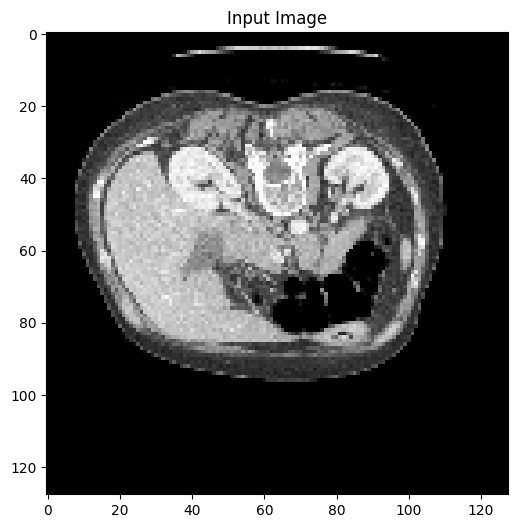

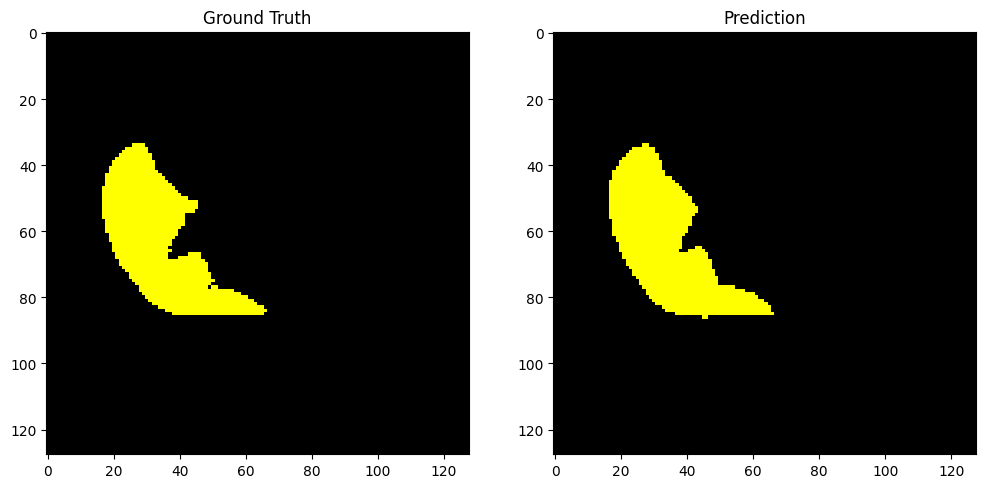

In [ ]:
num_images = 1
weight_path = "/content/drive/MyDrive/KLTN/code/weight/best_metric_model_UNet3D.pth"
visualize_results(model, val_loader, weight_path, num_images, device)